<a href="https://colab.research.google.com/github/mrMichalR/spaceship_titanic/blob/main/spaceship_titanic_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic project

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good. The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension! To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. Help save them and change history!

In [1]:
!pip install opendatasets
!pip install ydata-profiling
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import optuna
import logging
import sys
from tqdm import tqdm
import torch
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from numpy import std, mean
import matplotlib.pyplot as plt
from pandas import set_option
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import catboost as cb
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback, CatBoostPruningCallback

<ipython-input-2-c59c3da7514f>:14: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# # %cd drive/MyDrive/spaceship_titanic/

## Get data 
Get data from link: https://www.kaggle.com/competitions/spaceship-titanic/data and read to your notebook.

In [4]:
# import opendatasets as od
# dataset_url = 'https://www.kaggle.com/competitions/spaceship-titanic/data'
# od.download(dataset_url)

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/mrMichalR/spaceship_titanic/main/data/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/mrMichalR/spaceship_titanic/main/data/test.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [8]:
print(f'List of missing values:\n {df.isna().sum()}\n')
print(f'Sum of missing values: {df.isna().sum().sum()}')

List of missing values:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Sum of missing values: 2324


In [9]:
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

## Data analysis

Analyze the data and perform exploratory data analysis

### Plot histograms

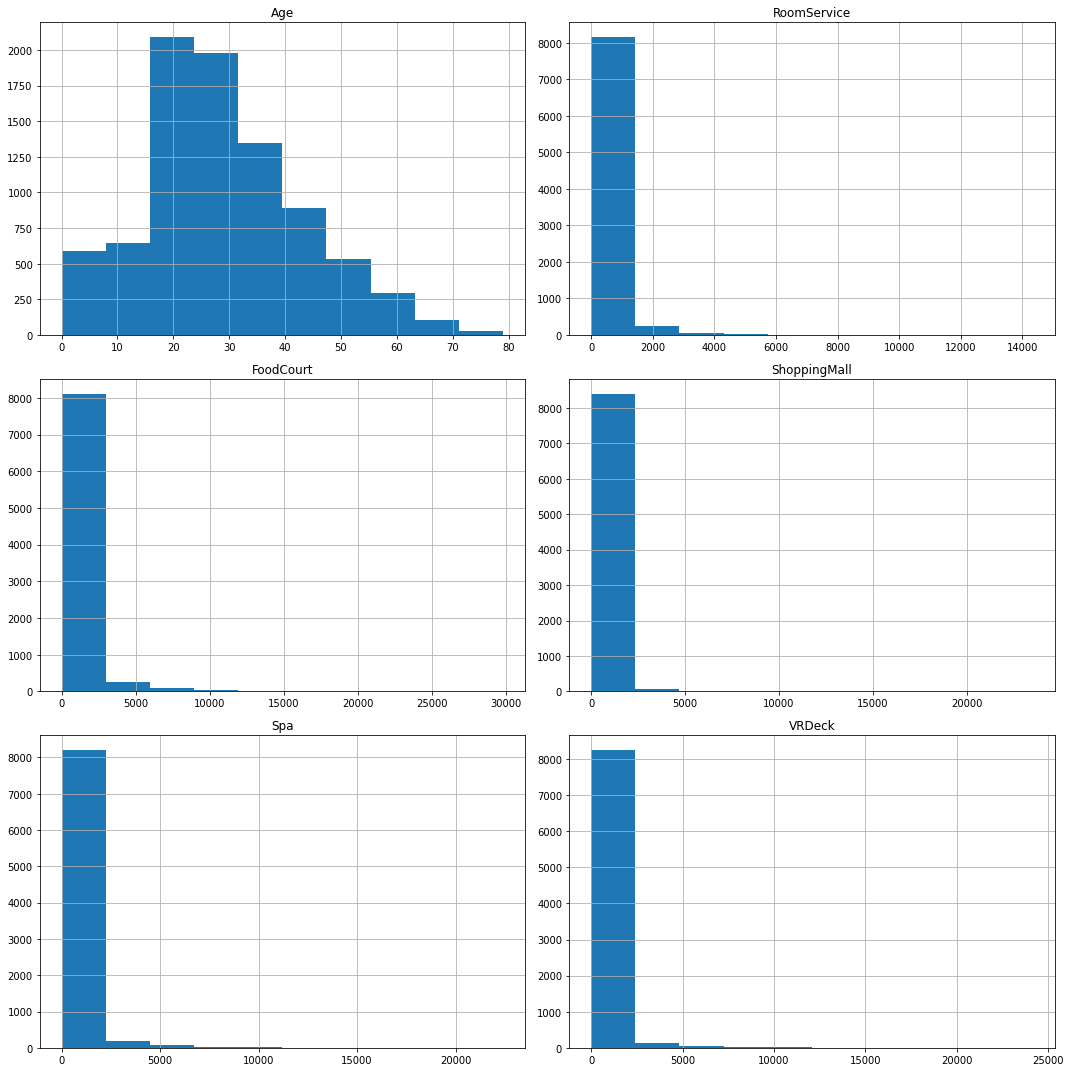

In [10]:
# histogram
df.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

### Identify correlations of data features and propose visual representation of the correlations.

In [11]:
# correlation
set_option('display.precision', 3)
df_corr = df.corr(method='pearson')
df_corr

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000,0.069,0.130,0.033,0.124,0.101,-0.075
RoomService,0.069,1.000,-0.016,0.054,0.010,-0.020,-0.245
FoodCourt,0.130,-0.016,1.000,-0.014,0.222,0.228,0.047
ShoppingMall,0.033,0.054,-0.014,1.000,0.014,-0.007,0.010
Spa,0.124,0.010,0.222,0.014,1.000,0.154,-0.221
VRDeck,0.101,-0.020,0.228,-0.007,0.154,1.000,-0.207
Transported,-0.075,-0.245,0.047,0.010,-0.221,-0.207,1.000


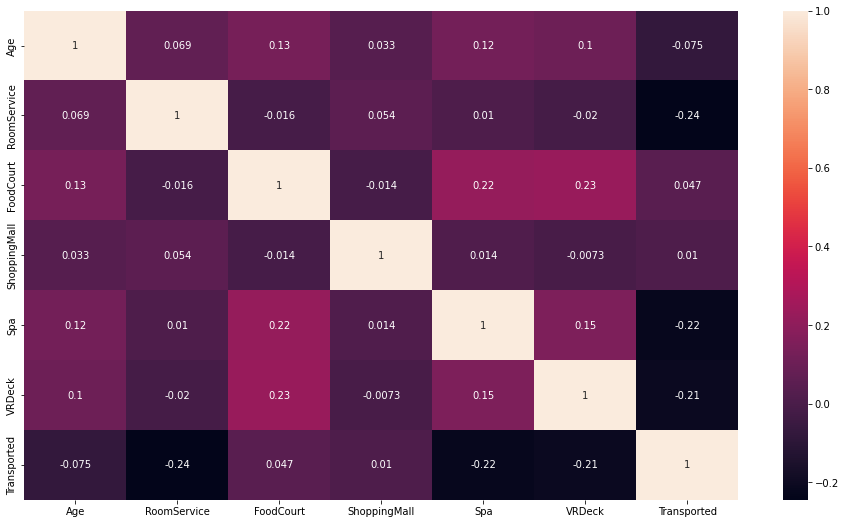

In [12]:
# correlation visualization
plt.figure(figsize=(16,9))
sns.heatmap(df_corr, annot=True)
plt.show()

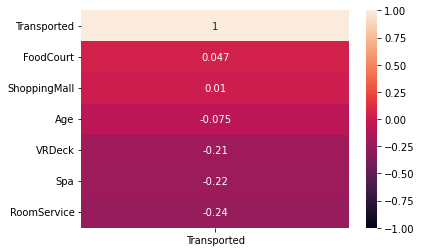

In [13]:
heatmap = sns.heatmap(df.corr()[['Transported']].sort_values(by='Transported', ascending=False), vmin=-1, vmax=1, annot=True)

### Check if the dataset is balanced (if not think about methods to aquire balance)

In [14]:
# target = "Transported"
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Target feature balanced

### Use pandas profiler to generate report in html format

In [15]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

## Data preprocessing
Prepare data using preprocessing methods.

In [16]:
target_name = "Transported"
X = df.drop(columns=[target_name])
y = df[target_name]
# y = df[target_name].astype(str)

### Think and propose how represent categorical values

Proposition:

1. Impute missing values for df

2. Since we are going to use tree-based models (XGB,LGBM, CB):

  - encoding categorical data with OrdinalEncoder is OK. 

  - no need to scale numerical.


Source: https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html#fitting-a-more-powerful-model

___
Possible simplier solution is to use pandas replace with intiger values - will be checked.
https://www.kaggle.com/code/hussainsheriff/spaceship-titanic-tensor-flow
___

Alternative encoder: one_hot_encoder or pd.get_dummies. - **careful to do not oversize df!**

In [17]:
for elem in X.columns.to_list():
  if X[elem].nunique() == 2:
    X[elem]=X[elem].astype(float)
X

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0.0,A/98/P,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,Earth,1.0,G/1499/S,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,Earth,0.0,G/1500/S,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,Europa,0.0,E/608/S,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


In [18]:
# Ordinal encoder use with encoding unknown values with np.value value

# categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
categorical_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
# numerical_preprocessor = StandardScaler()
# numerical_preprocessor = MinMaxScaler()

categorical_columns= X.select_dtypes(include=object).columns.tolist()
numerical_columns = X.select_dtypes(exclude=object).columns.tolist()

In [19]:
# Defining pipeplines

categorical_pipeline = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy='most_frequent')),
        ("Encoder", categorical_preprocessor),
        # ("Imputer", IterativeImputer(random_state=42, skip_complete=True)),
        # ("Scaler", numerical_preprocessor),
    ])

numerical_pipeline = Pipeline(
    steps=[
        # ("Imputer", IterativeImputer(random_state=42, skip_complete=True)),
        ("Imputer", SimpleImputer(missing_values=np.NaN, strategy='most_frequent'))
        # ("Scaler", numerical_preprocessor),
    ])

In [20]:
print(f'Before convert:\n{X.dtypes}\n')

# Convert categorical columns to Pandas category
for col in categorical_columns:
   X[col] = X[col].astype('category')

print(f'After convert:\n{X.dtypes}\n')

Before convert:
PassengerId      object
HomePlanet       object
CryoSleep       float64
Cabin            object
Destination      object
Age             float64
VIP             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

After convert:
PassengerId     category
HomePlanet      category
CryoSleep        float64
Cabin           category
Destination     category
Age              float64
VIP              float64
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name            category
dtype: object



### Think and propose how to handle nulls and nan values

Proposition:
* More pro - pd.replace or pd.fillna or impute (e.g. SimpleImputer) - included in above point and in Pipeline
* The simplest approach is to remove. In this case dropping caused dataset reduction: 2324 rows dropped !


### Divide dataset into train, validation and test subset

Since we have test dataset our train will be split into train and validation.

In [21]:
#Split of train to train and validation ('val') 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

print('TRAIN set:\n', 'X_train:', X_train.shape, '\n y_train2: ', y_train.shape)
print('VAL set:\n', 'X_val:', X_val.shape, '\n y_val2: ', y_val.shape)

TRAIN set:
 X_train: (6085, 13) 
 y_train2:  (6085,)
VAL set:
 X_val: (2608, 13) 
 y_val2:  (2608,)


## Machine learning methods
Use standard ML algorithms to classify passengers.

In [22]:
#define columntransformer

preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_columns),
    ('numerical', numerical_pipeline, numerical_columns)],  
    # remainder="passthrough"
    )

preprocessor

ColumnTransformer(transformers=[('categorical',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=nan),
                                 ['PassengerId', 'HomePlanet', 'Cabin',
                                  'Destination', 'Name']),
                                ('numerical',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['CryoSleep', 'Age', 'VIP', 'RoomService',
                                  'FoodCourt', 'ShoppingMall', 'Spa',
                                  'VRDeck'])])

In [23]:
X_tr = preprocessor.fit_transform(X)

In [24]:
pd.isna(X_tr).any()

True

### Use XGBoost, LightGBM and CatBoost.

In [25]:
# Spot-Check Algorithms
models = []
models.append(('XGB', XGBClassifier()))
models.append(('LightGBM', LGBMClassifier()))
models.append(('CatBoost', CatBoostClassifier(logging_level='Silent')))

### Choose metrics you want to use to evaluate those models,

Accuracy by default but in thi scase recall might be more informative

In [26]:
model_name = []
name = []
for name, model_name in models:
  model = make_pipeline(preprocessor, model_name)
  model.fit(X_train, y_train)
  model.predict(X_val)
  if name =='CatBoost':
    print(f'{name} accuracy: {accuracy_score(y_val.astype(str), model.predict(X_val))}')
    print(f'{name} recall: {recall_score(y_val.astype(str), model.predict(X_val), average="binary", pos_label="False")}')
    # print(f'{name} precision: {precision_score(y_val2.astype(str), model.predict(X_val2), average="macro")}')
    print(f'{name} f1_score: {f1_score(y_val.astype(str), model.predict(X_val),average="binary", pos_label="False")}')
    print('\n')
  else:
    print(f'{name} accuracy: {model.score(X_val, y_val)}')
    print(f'{name} recall: {recall_score(y_val, model.predict(X_val))}')
    # print(f'{name} precision: {precision_score(y_val2, model.predict(X_val2), average="macro")}')
    print(f'{name} f1_score: {f1_score(y_val, model.predict(X_val))}')
    print('\n')

XGB accuracy: 0.7523006134969326
XGB recall: 0.6653934300993124
XGB f1_score: 0.7294807370184254


LightGBM accuracy: 0.7875766871165644
LightGBM recall: 0.8036669213139801
LightGBM f1_score: 0.7915726109857035


CatBoost accuracy: 0.7707055214723927
CatBoost recall: 0.8221709006928406
CatBoost f1_score: 0.7812728602779809




In [27]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['PassengerId', 'HomePlanet',
                                                   'Cabin', 'Destination',
                                                   'Name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['CryoSleep', 'Age', 'VIP',
                                                   'RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f3cc62b2a00>)])

### Use Optuna to find the best hyperparameters.

#### LGBM

In [28]:
'''
SOURCE: 
https://colab.research.google.com/drive/1Mj9hF54UESVDRmpA09tWADq9Nbrj6M-2?usp=sharing#scrollTo=9a1haMklJ6X3
'''

# Define the objective function.
def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_val, label=y_val)
    #default parameters dictionary for optimizations(search space)
    param = {
        "objective": "binary",
        "metric": "auc", #'binary_logloss',
        "verbosity": -1,
        "boosting_type": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    # To turn on the pruning feature, you need to call :func:`~optuna.trial.Trial.report` and :func:`~optuna.trial.Trial.should_prune` after each step of the iterative training.
    # :func:`~optuna.trial.Trial.report` periodically monitors the intermediate objective values.
    # :func:`~optuna.trial.Trial.should_prune` decides termination of the trial that does not meet a predefined condition.
    # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(
        param, 
        dtrain, 
        valid_sets=[dvalid], 
        verbose_eval=False, 
        #callbacks=[pruning_callback]
        )
    #Predict the valid data
    preds = gbm.predict(X_val)
    #rounding values to its nearest integers
    pred_labels = np.rint(preds)
    #calculating accuracy
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

'''
Create an study for that ML model and optimize it
'''

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
# Method :func:`~optuna.create_study` returns a study object.
# A study object has useful properties for analyzing the optimization outcome.
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
) 
#Set minimize for minimization and maximize for maximization.
#To start the optimization, we create a study object and pass the objective function to method
study.optimize(objective, n_trials=100, timeout=600) #add timeout for model not to exceed this time limit


print(2*'\n')
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-03-24 19:28:13,788] A new study created in memory with name: no-name-9519b52b-f436-47f8-90a4-828d07a9004b


A new study created in memory with name: no-name-9519b52b-f436-47f8-90a4-828d07a9004b


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:14,089] Trial 0 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.01700216494520392, 'lambda_l2': 0.010504064595094462, 'num_leaves': 226, 'feature_fraction': 0.9366234501467865, 'bagging_fraction': 0.724760149562262, 'bagging_freq': 1, '

Trial 0 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.01700216494520392, 'lambda_l2': 0.010504064595094462, 'num_leaves': 226, 'feature_fraction': 0.9366234501467865, 'bagging_fraction': 0.724760149562262, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:14,410] Trial 1 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 4.257129549251178e-08, 'lambda_l2': 5.106514547704753e-07, 'num_leaves': 101, 'feature_fraction': 0.8838872018140489, 'bagging_fraction': 0.6213818102366842, 'bagging_freq': 

Trial 1 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 4.257129549251178e-08, 'lambda_l2': 5.106514547704753e-07, 'num_leaves': 101, 'feature_fraction': 0.8838872018140489, 'bagging_fraction': 0.6213818102366842, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:14,893] Trial 2 finished with value: 0.7868098159509203 and parameters: {'lambda_l1': 3.4879136755911536e-07, 'lambda_l2': 0.007486700602952722, 'num_leaves': 229, 'feature_fraction': 0.9824589901316567, 'bagging_fraction': 0.9318159602882663, 'bagging_freq':

Trial 2 finished with value: 0.7868098159509203 and parameters: {'lambda_l1': 3.4879136755911536e-07, 'lambda_l2': 0.007486700602952722, 'num_leaves': 229, 'feature_fraction': 0.9824589901316567, 'bagging_fraction': 0.9318159602882663, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:15,566] Trial 3 finished with value: 0.7799079754601227 and parameters: {'lambda_l1': 1.7070866321876253e-06, 'lambda_l2': 0.0008611196524478645, 'num_leaves': 91, 'feature_fraction': 0.6454830593392908, 'bagging_fraction': 0.6279767495048723, 'bagging_freq':

Trial 3 finished with value: 0.7799079754601227 and parameters: {'lambda_l1': 1.7070866321876253e-06, 'lambda_l2': 0.0008611196524478645, 'num_leaves': 91, 'feature_fraction': 0.6454830593392908, 'bagging_fraction': 0.6279767495048723, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:16,434] Trial 4 finished with value: 0.7783742331288344 and parameters: {'lambda_l1': 8.437790319404051e-06, 'lambda_l2': 1.1181257330742728e-07, 'num_leaves': 108, 'feature_fraction': 0.7558584589432713, 'bagging_fraction': 0.7328563208422834, 'bagging_freq'

Trial 4 finished with value: 0.7783742331288344 and parameters: {'lambda_l1': 8.437790319404051e-06, 'lambda_l2': 1.1181257330742728e-07, 'num_leaves': 108, 'feature_fraction': 0.7558584589432713, 'bagging_fraction': 0.7328563208422834, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:17,327] Trial 5 finished with value: 0.776840490797546 and parameters: {'lambda_l1': 0.03251885598887264, 'lambda_l2': 3.7208371522284003e-07, 'num_leaves': 222, 'feature_fraction': 0.7511457177173049, 'bagging_fraction': 0.7360080314257715, 'bagging_freq': 2

Trial 5 finished with value: 0.776840490797546 and parameters: {'lambda_l1': 0.03251885598887264, 'lambda_l2': 3.7208371522284003e-07, 'num_leaves': 222, 'feature_fraction': 0.7511457177173049, 'bagging_fraction': 0.7360080314257715, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:17,870] Trial 6 finished with value: 0.7848926380368099 and parameters: {'lambda_l1': 7.935343277098668e-06, 'lambda_l2': 5.9355503812234805e-08, 'num_leaves': 119, 'feature_fraction': 0.5215701162222701, 'bagging_fraction': 0.9169682200648185, 'bagging_freq'

Trial 6 finished with value: 0.7848926380368099 and parameters: {'lambda_l1': 7.935343277098668e-06, 'lambda_l2': 5.9355503812234805e-08, 'num_leaves': 119, 'feature_fraction': 0.5215701162222701, 'bagging_fraction': 0.9169682200648185, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:18,245] Trial 7 finished with value: 0.786042944785276 and parameters: {'lambda_l1': 0.00508203627520378, 'lambda_l2': 1.004368632635598e-07, 'num_leaves': 123, 'feature_fraction': 0.5459757817777369, 'bagging_fraction': 0.7340490243132515, 'bagging_freq': 3,

Trial 7 finished with value: 0.786042944785276 and parameters: {'lambda_l1': 0.00508203627520378, 'lambda_l2': 1.004368632635598e-07, 'num_leaves': 123, 'feature_fraction': 0.5459757817777369, 'bagging_fraction': 0.7340490243132515, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:18,780] Trial 8 finished with value: 0.7753067484662577 and parameters: {'lambda_l1': 0.0021763773245391453, 'lambda_l2': 0.000141649393504104, 'num_leaves': 135, 'feature_fraction': 0.9810845941417458, 'bagging_fraction': 0.7116702610485044, 'bagging_freq': 

Trial 8 finished with value: 0.7753067484662577 and parameters: {'lambda_l1': 0.0021763773245391453, 'lambda_l2': 0.000141649393504104, 'num_leaves': 135, 'feature_fraction': 0.9810845941417458, 'bagging_fraction': 0.7116702610485044, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:19,068] Trial 9 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 1.7066182520898105e-06, 'lambda_l2': 0.00602892032108352, 'num_leaves': 51, 'feature_fraction': 0.5671318956325769, 'bagging_fraction': 0.5027516586400308, 'bagging_freq': 3

Trial 9 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 1.7066182520898105e-06, 'lambda_l2': 0.00602892032108352, 'num_leaves': 51, 'feature_fraction': 0.5671318956325769, 'bagging_fraction': 0.5027516586400308, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 0 with value: 0.790260736196319.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:19,278] Trial 10 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 5.632816852380417, 'lambda_l2': 0.812919756627379, 'num_leaves': 175, 'feature_fraction': 0.43503334493635726, 'bagging_fraction': 0.41182944460211557, 'bagging_freq': 1, '

Trial 10 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 5.632816852380417, 'lambda_l2': 0.812919756627379, 'num_leaves': 175, 'feature_fraction': 0.43503334493635726, 'bagging_fraction': 0.41182944460211557, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 10 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:19,482] Trial 11 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 5.167575186676667, 'lambda_l2': 3.235245194151593, 'num_leaves': 179, 'feature_fraction': 0.41983261464265176, 'bagging_fraction': 0.404830892356365, 'bagging_freq': 1, 'mi

Trial 11 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 5.167575186676667, 'lambda_l2': 3.235245194151593, 'num_leaves': 179, 'feature_fraction': 0.41983261464265176, 'bagging_fraction': 0.404830892356365, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 10 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:19,701] Trial 12 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 4.540431992680056, 'lambda_l2': 2.9145526904675196, 'num_leaves': 186, 'feature_fraction': 0.41083456935100165, 'bagging_fraction': 0.41014888182737563, 'bagging_freq': 1, '

Trial 12 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 4.540431992680056, 'lambda_l2': 2.9145526904675196, 'num_leaves': 186, 'feature_fraction': 0.41083456935100165, 'bagging_fraction': 0.41014888182737563, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 10 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:19,998] Trial 13 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 0.13687949850099837, 'lambda_l2': 0.16736398611984493, 'num_leaves': 255, 'feature_fraction': 0.8371008998152252, 'bagging_fraction': 0.5152896728946098, 'bagging_freq': 1,

Trial 13 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 0.13687949850099837, 'lambda_l2': 0.16736398611984493, 'num_leaves': 255, 'feature_fraction': 0.8371008998152252, 'bagging_fraction': 0.5152896728946098, 'bagging_freq': 1, 'min_child_samples': 76}. Best is trial 10 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:20,319] Trial 14 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.3924760203254018, 'lambda_l2': 0.1936886393773546, 'num_leaves': 177, 'feature_fraction': 0.6432136409106609, 'bagging_fraction': 0.7959031214723691, 'bagging_freq': 7, '

Trial 14 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.3924760203254018, 'lambda_l2': 0.1936886393773546, 'num_leaves': 177, 'feature_fraction': 0.6432136409106609, 'bagging_fraction': 0.7959031214723691, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:20,628] Trial 15 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.4748410561289744, 'lambda_l2': 8.922936542012005, 'num_leaves': 166, 'feature_fraction': 0.6446707151774398, 'bagging_fraction': 0.8294456528061229, 'bagging_freq': 7, 'm

Trial 15 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.4748410561289744, 'lambda_l2': 8.922936542012005, 'num_leaves': 166, 'feature_fraction': 0.6446707151774398, 'bagging_fraction': 0.8294456528061229, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:20,966] Trial 16 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 0.2830363042315431, 'lambda_l2': 9.464087582246933, 'num_leaves': 157, 'feature_fraction': 0.6481686838580297, 'bagging_fraction': 0.8410955478815342, 'bagging_freq': 7, 'm

Trial 16 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 0.2830363042315431, 'lambda_l2': 9.464087582246933, 'num_leaves': 157, 'feature_fraction': 0.6481686838580297, 'bagging_fraction': 0.8410955478815342, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:21,242] Trial 17 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 0.0005194684064769517, 'lambda_l2': 0.3264058207288055, 'num_leaves': 20, 'feature_fraction': 0.6945668926232137, 'bagging_fraction': 0.8163992815076594, 'bagging_freq': 7,

Trial 17 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 0.0005194684064769517, 'lambda_l2': 0.3264058207288055, 'num_leaves': 20, 'feature_fraction': 0.6945668926232137, 'bagging_fraction': 0.8163992815076594, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:21,571] Trial 18 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.42243813016810794, 'lambda_l2': 0.10508764729111689, 'num_leaves': 201, 'feature_fraction': 0.6249695666915501, 'bagging_fraction': 0.8512957336896118, 'bagging_freq': 6,

Trial 18 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.42243813016810794, 'lambda_l2': 0.10508764729111689, 'num_leaves': 201, 'feature_fraction': 0.6249695666915501, 'bagging_fraction': 0.8512957336896118, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:21,990] Trial 19 finished with value: 0.7848926380368099 and parameters: {'lambda_l1': 0.000246489921732345, 'lambda_l2': 0.13434879684942141, 'num_leaves': 202, 'feature_fraction': 0.6002411705486542, 'bagging_fraction': 0.8970516849270734, 'bagging_freq': 5

Trial 19 finished with value: 0.7848926380368099 and parameters: {'lambda_l1': 0.000246489921732345, 'lambda_l2': 0.13434879684942141, 'num_leaves': 202, 'feature_fraction': 0.6002411705486542, 'bagging_fraction': 0.8970516849270734, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:22,373] Trial 20 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.613408927398382, 'lambda_l2': 0.03574414917899991, 'num_leaves': 147, 'feature_fraction': 0.7407009197698948, 'bagging_fraction': 0.993919237972102, 'bagging_freq': 6, 'm

Trial 20 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.613408927398382, 'lambda_l2': 0.03574414917899991, 'num_leaves': 147, 'feature_fraction': 0.7407009197698948, 'bagging_fraction': 0.993919237972102, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:22,675] Trial 21 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.7404558958767402, 'lambda_l2': 8.156763499861034, 'num_leaves': 197, 'feature_fraction': 0.6317592397333064, 'bagging_fraction': 0.7988100429623509, 'bagging_freq': 6, 'mi

Trial 21 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.7404558958767402, 'lambda_l2': 8.156763499861034, 'num_leaves': 197, 'feature_fraction': 0.6317592397333064, 'bagging_fraction': 0.7988100429623509, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:23,023] Trial 22 finished with value: 0.7871932515337423 and parameters: {'lambda_l1': 0.09196446646543799, 'lambda_l2': 0.7585695592887893, 'num_leaves': 161, 'feature_fraction': 0.6916152061992037, 'bagging_fraction': 0.8511465297450559, 'bagging_freq': 7, 

Trial 22 finished with value: 0.7871932515337423 and parameters: {'lambda_l1': 0.09196446646543799, 'lambda_l2': 0.7585695592887893, 'num_leaves': 161, 'feature_fraction': 0.6916152061992037, 'bagging_fraction': 0.8511465297450559, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:23,342] Trial 23 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.9432664005226431, 'lambda_l2': 1.381759772626743, 'num_leaves': 211, 'feature_fraction': 0.5075575581763883, 'bagging_fraction': 0.7818908549302767, 'bagging_freq': 5, 'm

Trial 23 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.9432664005226431, 'lambda_l2': 1.381759772626743, 'num_leaves': 211, 'feature_fraction': 0.5075575581763883, 'bagging_fraction': 0.7818908549302767, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:23,689] Trial 24 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.042589017509384534, 'lambda_l2': 0.11488349274405985, 'num_leaves': 255, 'feature_fraction': 0.6034064235932677, 'bagging_fraction': 0.8739430558085696, 'bagging_freq': 6

Trial 24 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.042589017509384534, 'lambda_l2': 0.11488349274405985, 'num_leaves': 255, 'feature_fraction': 0.6034064235932677, 'bagging_fraction': 0.8739430558085696, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:24,027] Trial 25 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 1.512472431582345, 'lambda_l2': 0.7922646271577986, 'num_leaves': 78, 'feature_fraction': 0.6709347090785, 'bagging_fraction': 0.796034674340041, 'bagging_freq': 7, 'min_ch

Trial 25 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 1.512472431582345, 'lambda_l2': 0.7922646271577986, 'num_leaves': 78, 'feature_fraction': 0.6709347090785, 'bagging_fraction': 0.796034674340041, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:24,387] Trial 26 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.1522145705585648, 'lambda_l2': 0.053540610744498125, 'num_leaves': 166, 'feature_fraction': 0.5827847261341241, 'bagging_fraction': 0.8639059628711021, 'bagging_freq': 7,

Trial 26 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.1522145705585648, 'lambda_l2': 0.053540610744498125, 'num_leaves': 166, 'feature_fraction': 0.5827847261341241, 'bagging_fraction': 0.8639059628711021, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:24,663] Trial 27 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 9.037393993325368, 'lambda_l2': 8.124193691512401, 'num_leaves': 141, 'feature_fraction': 0.7144639493197918, 'bagging_fraction': 0.9417023757873167, 'bagging_freq': 6, 'mi

Trial 27 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 9.037393993325368, 'lambda_l2': 8.124193691512401, 'num_leaves': 141, 'feature_fraction': 0.7144639493197918, 'bagging_fraction': 0.9417023757873167, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:25,086] Trial 28 finished with value: 0.785659509202454 and parameters: {'lambda_l1': 0.010114138411132796, 'lambda_l2': 0.7884061138643685, 'num_leaves': 190, 'feature_fraction': 0.6226561673015913, 'bagging_fraction': 0.7715081780102854, 'bagging_freq': 4, 

Trial 28 finished with value: 0.785659509202454 and parameters: {'lambda_l1': 0.010114138411132796, 'lambda_l2': 0.7884061138643685, 'num_leaves': 190, 'feature_fraction': 0.6226561673015913, 'bagging_fraction': 0.7715081780102854, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:25,460] Trial 29 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.02426063979197692, 'lambda_l2': 0.02210618369900035, 'num_leaves': 226, 'feature_fraction': 0.7853783744572145, 'bagging_fraction': 0.8198655264335044, 'bagging_freq': 5,

Trial 29 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.02426063979197692, 'lambda_l2': 0.02210618369900035, 'num_leaves': 226, 'feature_fraction': 0.7853783744572145, 'bagging_fraction': 0.8198655264335044, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:25,826] Trial 30 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.3712588242029581, 'lambda_l2': 0.24738258702990448, 'num_leaves': 238, 'feature_fraction': 0.6672606910857121, 'bagging_fraction': 0.8843526966324268, 'bagging_freq': 7, 

Trial 30 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.3712588242029581, 'lambda_l2': 0.24738258702990448, 'num_leaves': 238, 'feature_fraction': 0.6672606910857121, 'bagging_fraction': 0.8843526966324268, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 14 with value: 0.7937116564417178.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:26,138] Trial 31 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 1.4689041217313692, 'lambda_l2': 2.3967886048865625, 'num_leaves': 210, 'feature_fraction': 0.5183574751332868, 'bagging_fraction': 0.7668556638381181, 'bagging_freq': 5, '

Trial 31 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 1.4689041217313692, 'lambda_l2': 2.3967886048865625, 'num_leaves': 210, 'feature_fraction': 0.5183574751332868, 'bagging_fraction': 0.7668556638381181, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:26,427] Trial 32 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 1.447045969824467, 'lambda_l2': 3.694839024930924, 'num_leaves': 209, 'feature_fraction': 0.4859540281335399, 'bagging_fraction': 0.7664605442741822, 'bagging_freq': 4, 'mi

Trial 32 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 1.447045969824467, 'lambda_l2': 3.694839024930924, 'num_leaves': 209, 'feature_fraction': 0.4859540281335399, 'bagging_fraction': 0.7664605442741822, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:26,726] Trial 33 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 2.368364970879517, 'lambda_l2': 2.0330036429417055, 'num_leaves': 208, 'feature_fraction': 0.4790607075277714, 'bagging_fraction': 0.7671636799092185, 'bagging_freq': 4, 'm

Trial 33 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 2.368364970879517, 'lambda_l2': 2.0330036429417055, 'num_leaves': 208, 'feature_fraction': 0.4790607075277714, 'bagging_fraction': 0.7671636799092185, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:27,016] Trial 34 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 1.9486445317474748, 'lambda_l2': 1.9361573216868226, 'num_leaves': 214, 'feature_fraction': 0.463254534227499, 'bagging_fraction': 0.6781391638948571, 'bagging_freq': 4, 'm

Trial 34 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 1.9486445317474748, 'lambda_l2': 1.9361573216868226, 'num_leaves': 214, 'feature_fraction': 0.463254534227499, 'bagging_fraction': 0.6781391638948571, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:27,293] Trial 35 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 2.1769117293019167, 'lambda_l2': 2.9154661187040207, 'num_leaves': 242, 'feature_fraction': 0.463443372897154, 'bagging_fraction': 0.6688632180688304, 'bagging_freq': 4, 'm

Trial 35 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 2.1769117293019167, 'lambda_l2': 2.9154661187040207, 'num_leaves': 242, 'feature_fraction': 0.463443372897154, 'bagging_fraction': 0.6688632180688304, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:27,578] Trial 36 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 2.3054959030789215, 'lambda_l2': 1.8946245829659314, 'num_leaves': 214, 'feature_fraction': 0.4756203342104496, 'bagging_fraction': 0.6800354968779303, 'bagging_freq': 4, '

Trial 36 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 2.3054959030789215, 'lambda_l2': 1.8946245829659314, 'num_leaves': 214, 'feature_fraction': 0.4756203342104496, 'bagging_fraction': 0.6800354968779303, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:27,902] Trial 37 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 2.1927549251296887, 'lambda_l2': 0.008666624856235967, 'num_leaves': 219, 'feature_fraction': 0.4909964374641278, 'bagging_fraction': 0.7621552434392491, 'bagging_freq': 4,

Trial 37 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 2.1927549251296887, 'lambda_l2': 0.008666624856235967, 'num_leaves': 219, 'feature_fraction': 0.4909964374641278, 'bagging_fraction': 0.7621552434392491, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:28,274] Trial 38 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 9.974701701728929, 'lambda_l2': 0.0023579371244124335, 'num_leaves': 241, 'feature_fraction': 0.4447227307055748, 'bagging_fraction': 0.7484074825710738, 'bagging_freq': 5,

Trial 38 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 9.974701701728929, 'lambda_l2': 0.0023579371244124335, 'num_leaves': 241, 'feature_fraction': 0.4447227307055748, 'bagging_fraction': 0.7484074825710738, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:28,758] Trial 39 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.09660923510536502, 'lambda_l2': 0.01664146364068859, 'num_leaves': 222, 'feature_fraction': 0.40005617457390513, 'bagging_fraction': 0.7027883283698269, 'bagging_freq': 4

Trial 39 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.09660923510536502, 'lambda_l2': 0.01664146364068859, 'num_leaves': 222, 'feature_fraction': 0.40005617457390513, 'bagging_fraction': 0.7027883283698269, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:29,232] Trial 40 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 2.4149405169544815, 'lambda_l2': 0.0002742279590832398, 'num_leaves': 232, 'feature_fraction': 0.528520972157882, 'bagging_fraction': 0.7463033978627798, 'bagging_freq': 2,

Trial 40 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 2.4149405169544815, 'lambda_l2': 0.0002742279590832398, 'num_leaves': 232, 'feature_fraction': 0.528520972157882, 'bagging_fraction': 0.7463033978627798, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:29,745] Trial 41 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 1.3924053884153842, 'lambda_l2': 0.4476463490043244, 'num_leaves': 210, 'feature_fraction': 0.48093532948073736, 'bagging_fraction': 0.7582078564890365, 'bagging_freq': 4, 

Trial 41 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 1.3924053884153842, 'lambda_l2': 0.4476463490043244, 'num_leaves': 210, 'feature_fraction': 0.48093532948073736, 'bagging_fraction': 0.7582078564890365, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:30,177] Trial 42 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.8558370504128305, 'lambda_l2': 2.482474207396843, 'num_leaves': 216, 'feature_fraction': 0.4938469402102969, 'bagging_fraction': 0.731207739198859, 'bagging_freq': 3, 'mi

Trial 42 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.8558370504128305, 'lambda_l2': 2.482474207396843, 'num_leaves': 216, 'feature_fraction': 0.4938469402102969, 'bagging_fraction': 0.731207739198859, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:30,593] Trial 43 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 3.7674857315019494, 'lambda_l2': 0.3731299122498288, 'num_leaves': 194, 'feature_fraction': 0.5328407275272657, 'bagging_fraction': 0.709986393353635, 'bagging_freq': 3, 'm

Trial 43 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 3.7674857315019494, 'lambda_l2': 0.3731299122498288, 'num_leaves': 194, 'feature_fraction': 0.5328407275272657, 'bagging_fraction': 0.709986393353635, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:30,947] Trial 44 finished with value: 0.7887269938650306 and parameters: {'lambda_l1': 9.544815108588164, 'lambda_l2': 3.572343343036003e-05, 'num_leaves': 205, 'feature_fraction': 0.45042147693143697, 'bagging_fraction': 0.7693981710334459, 'bagging_freq': 5

Trial 44 finished with value: 0.7887269938650306 and parameters: {'lambda_l1': 9.544815108588164, 'lambda_l2': 3.572343343036003e-05, 'num_leaves': 205, 'feature_fraction': 0.45042147693143697, 'bagging_fraction': 0.7693981710334459, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 31 with value: 0.7952453987730062.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:31,334] Trial 45 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.17895652781447374, 'lambda_l2': 1.8145600119277094, 'num_leaves': 231, 'feature_fraction': 0.552012702020038, 'bagging_fraction': 0.6447065091537936, 'bagging_freq': 4, '

Trial 45 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.17895652781447374, 'lambda_l2': 1.8145600119277094, 'num_leaves': 231, 'feature_fraction': 0.552012702020038, 'bagging_fraction': 0.6447065091537936, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:31,671] Trial 46 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.05472172445499742, 'lambda_l2': 0.05572914483591675, 'num_leaves': 246, 'feature_fraction': 0.5552538660478696, 'bagging_fraction': 0.6423701631338024, 'bagging_freq': 4,

Trial 46 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.05472172445499742, 'lambda_l2': 0.05572914483591675, 'num_leaves': 246, 'feature_fraction': 0.5552538660478696, 'bagging_fraction': 0.6423701631338024, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:32,033] Trial 47 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.18603335308090832, 'lambda_l2': 0.009227247244174298, 'num_leaves': 231, 'feature_fraction': 0.5527815152335739, 'bagging_fraction': 0.6918614493889278, 'bagging_freq': 3

Trial 47 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.18603335308090832, 'lambda_l2': 0.009227247244174298, 'num_leaves': 231, 'feature_fraction': 0.5527815152335739, 'bagging_fraction': 0.6918614493889278, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:32,314] Trial 48 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 4.977084390977807, 'lambda_l2': 0.5431488374389757, 'num_leaves': 187, 'feature_fraction': 0.5102068391838377, 'bagging_fraction': 0.6571137237879953, 'bagging_freq': 5, 'm

Trial 48 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 4.977084390977807, 'lambda_l2': 0.5431488374389757, 'num_leaves': 187, 'feature_fraction': 0.5102068391838377, 'bagging_fraction': 0.6571137237879953, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:32,643] Trial 49 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 0.9405416508271972, 'lambda_l2': 1.2464982851663933, 'num_leaves': 108, 'feature_fraction': 0.4333822944318139, 'bagging_fraction': 0.6229741423694575, 'bagging_freq': 3, '

Trial 49 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 0.9405416508271972, 'lambda_l2': 1.2464982851663933, 'num_leaves': 108, 'feature_fraction': 0.4333822944318139, 'bagging_fraction': 0.6229741423694575, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:33,092] Trial 50 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.312271237545535, 'lambda_l2': 4.327417615237138, 'num_leaves': 223, 'feature_fraction': 0.5145779797251107, 'bagging_fraction': 0.5956155242449458, 'bagging_freq': 4, 'mi

Trial 50 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.312271237545535, 'lambda_l2': 4.327417615237138, 'num_leaves': 223, 'feature_fraction': 0.5145779797251107, 'bagging_fraction': 0.5956155242449458, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:33,419] Trial 51 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.9858096814742673, 'lambda_l2': 1.6159314947129664, 'num_leaves': 217, 'feature_fraction': 0.48514265435861176, 'bagging_fraction': 0.7189031675011649, 'bagging_freq': 4, 

Trial 51 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.9858096814742673, 'lambda_l2': 1.6159314947129664, 'num_leaves': 217, 'feature_fraction': 0.48514265435861176, 'bagging_fraction': 0.7189031675011649, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:33,731] Trial 52 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.7071955967010217, 'lambda_l2': 1.454539770370067, 'num_leaves': 179, 'feature_fraction': 0.45284320685622254, 'bagging_fraction': 0.7230100354049956, 'bagging_freq': 4, '

Trial 52 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.7071955967010217, 'lambda_l2': 1.454539770370067, 'num_leaves': 179, 'feature_fraction': 0.45284320685622254, 'bagging_fraction': 0.7230100354049956, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:34,001] Trial 53 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 3.711264521986488, 'lambda_l2': 0.2829629218795122, 'num_leaves': 250, 'feature_fraction': 0.49593828039545507, 'bagging_fraction': 0.6888988932552963, 'bagging_freq': 4, '

Trial 53 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 3.711264521986488, 'lambda_l2': 0.2829629218795122, 'num_leaves': 250, 'feature_fraction': 0.49593828039545507, 'bagging_fraction': 0.6888988932552963, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:34,313] Trial 54 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.05998318815836391, 'lambda_l2': 4.477439064306267, 'num_leaves': 234, 'feature_fraction': 0.42818906523407285, 'bagging_fraction': 0.717631023981749, 'bagging_freq': 5, '

Trial 54 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.05998318815836391, 'lambda_l2': 4.477439064306267, 'num_leaves': 234, 'feature_fraction': 0.42818906523407285, 'bagging_fraction': 0.717631023981749, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:34,615] Trial 55 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 0.05968012604231423, 'lambda_l2': 4.163239392007784, 'num_leaves': 235, 'feature_fraction': 0.47016374589802296, 'bagging_fraction': 0.7170300322662579, 'bagging_freq': 5, 

Trial 55 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 0.05968012604231423, 'lambda_l2': 4.163239392007784, 'num_leaves': 235, 'feature_fraction': 0.47016374589802296, 'bagging_fraction': 0.7170300322662579, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:34,912] Trial 56 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.14324186513215012, 'lambda_l2': 1.3543822757212627, 'num_leaves': 228, 'feature_fraction': 0.4220422316822574, 'bagging_fraction': 0.7388652754592953, 'bagging_freq': 5, 

Trial 56 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.14324186513215012, 'lambda_l2': 1.3543822757212627, 'num_leaves': 228, 'feature_fraction': 0.4220422316822574, 'bagging_fraction': 0.7388652754592953, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:35,108] Trial 57 finished with value: 0.7871932515337423 and parameters: {'lambda_l1': 0.016527672032013132, 'lambda_l2': 4.813554518985738, 'num_leaves': 5, 'feature_fraction': 0.5348743274238219, 'bagging_fraction': 0.6609034212140565, 'bagging_freq': 5, 'm

Trial 57 finished with value: 0.7871932515337423 and parameters: {'lambda_l1': 0.016527672032013132, 'lambda_l2': 4.813554518985738, 'num_leaves': 5, 'feature_fraction': 0.5348743274238219, 'bagging_fraction': 0.6609034212140565, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:35,412] Trial 58 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.30639756920394523, 'lambda_l2': 1.9433163730380583, 'num_leaves': 197, 'feature_fraction': 0.4229453982786898, 'bagging_fraction': 0.7132044451401242, 'bagging_freq': 3, 

Trial 58 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.30639756920394523, 'lambda_l2': 1.9433163730380583, 'num_leaves': 197, 'feature_fraction': 0.4229453982786898, 'bagging_fraction': 0.7132044451401242, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:35,704] Trial 59 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.7273944576340312, 'lambda_l2': 8.460309105579212, 'num_leaves': 174, 'feature_fraction': 0.4594219695481697, 'bagging_fraction': 0.6841151953605616, 'bagging_freq': 4, 'm

Trial 59 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.7273944576340312, 'lambda_l2': 8.460309105579212, 'num_leaves': 174, 'feature_fraction': 0.4594219695481697, 'bagging_fraction': 0.6841151953605616, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:36,029] Trial 60 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.20492782875086435, 'lambda_l2': 0.7003589231674513, 'num_leaves': 152, 'feature_fraction': 0.5678382770099738, 'bagging_fraction': 0.607860920412444, 'bagging_freq': 5, '

Trial 60 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.20492782875086435, 'lambda_l2': 0.7003589231674513, 'num_leaves': 152, 'feature_fraction': 0.5678382770099738, 'bagging_fraction': 0.607860920412444, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:36,320] Trial 61 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.7517671003329899, 'lambda_l2': 9.799027726892014, 'num_leaves': 172, 'feature_fraction': 0.4555860366692842, 'bagging_fraction': 0.6974693236787717, 'bagging_freq': 4, 'mi

Trial 61 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.7517671003329899, 'lambda_l2': 9.799027726892014, 'num_leaves': 172, 'feature_fraction': 0.4555860366692842, 'bagging_fraction': 0.6974693236787717, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:36,623] Trial 62 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.43709289407269214, 'lambda_l2': 4.457596601178976, 'num_leaves': 203, 'feature_fraction': 0.40161455808209273, 'bagging_fraction': 0.6777864726514091, 'bagging_freq': 4, 

Trial 62 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.43709289407269214, 'lambda_l2': 4.457596601178976, 'num_leaves': 203, 'feature_fraction': 0.40161455808209273, 'bagging_fraction': 0.6777864726514091, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:36,941] Trial 63 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.08573228326298667, 'lambda_l2': 1.26769757341817, 'num_leaves': 216, 'feature_fraction': 0.4363070079233236, 'bagging_fraction': 0.6406954466126628, 'bagging_freq': 3, 'm

Trial 63 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.08573228326298667, 'lambda_l2': 1.26769757341817, 'num_leaves': 216, 'feature_fraction': 0.4363070079233236, 'bagging_fraction': 0.6406954466126628, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:37,276] Trial 64 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.9639679422254452, 'lambda_l2': 0.21418236444001024, 'num_leaves': 185, 'feature_fraction': 0.510603732387709, 'bagging_fraction': 0.7316149419468619, 'bagging_freq': 5, '

Trial 64 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.9639679422254452, 'lambda_l2': 0.21418236444001024, 'num_leaves': 185, 'feature_fraction': 0.510603732387709, 'bagging_fraction': 0.7316149419468619, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:37,544] Trial 65 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 4.099412958636285, 'lambda_l2': 9.93683258574097, 'num_leaves': 256, 'feature_fraction': 0.47440027620886166, 'bagging_fraction': 0.7864909355182488, 'bagging_freq': 4, 'mi

Trial 65 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 4.099412958636285, 'lambda_l2': 9.93683258574097, 'num_leaves': 256, 'feature_fraction': 0.47440027620886166, 'bagging_fraction': 0.7864909355182488, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:37,879] Trial 66 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.22988204237144558, 'lambda_l2': 2.4721453222445575, 'num_leaves': 131, 'feature_fraction': 0.4647982338797876, 'bagging_fraction': 0.8058219870251193, 'bagging_freq': 6, 

Trial 66 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.22988204237144558, 'lambda_l2': 2.4721453222445575, 'num_leaves': 131, 'feature_fraction': 0.4647982338797876, 'bagging_fraction': 0.8058219870251193, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:38,169] Trial 67 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.5858939467148115, 'lambda_l2': 0.5101187446206986, 'num_leaves': 234, 'feature_fraction': 0.4222713280370447, 'bagging_fraction': 0.6985542055629722, 'bagging_freq': 4, '

Trial 67 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.5858939467148115, 'lambda_l2': 0.5101187446206986, 'num_leaves': 234, 'feature_fraction': 0.4222713280370447, 'bagging_fraction': 0.6985542055629722, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:38,485] Trial 68 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.027063772538663485, 'lambda_l2': 4.815493803237246, 'num_leaves': 60, 'feature_fraction': 0.4423308399326853, 'bagging_fraction': 0.7546417971740705, 'bagging_freq': 3, 'm

Trial 68 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.027063772538663485, 'lambda_l2': 4.815493803237246, 'num_leaves': 60, 'feature_fraction': 0.4423308399326853, 'bagging_fraction': 0.7546417971740705, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:38,798] Trial 69 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.4592192998573768, 'lambda_l2': 0.9168418403073484, 'num_leaves': 206, 'feature_fraction': 0.49982980336492594, 'bagging_fraction': 0.7786554271137595, 'bagging_freq': 4, 

Trial 69 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.4592192998573768, 'lambda_l2': 0.9168418403073484, 'num_leaves': 206, 'feature_fraction': 0.49982980336492594, 'bagging_fraction': 0.7786554271137595, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:39,132] Trial 70 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 0.10198380719000309, 'lambda_l2': 0.09196339936542715, 'num_leaves': 248, 'feature_fraction': 0.5240618787348233, 'bagging_fraction': 0.669203828903763, 'bagging_freq': 2, 

Trial 70 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 0.10198380719000309, 'lambda_l2': 0.09196339936542715, 'num_leaves': 248, 'feature_fraction': 0.5240618787348233, 'bagging_fraction': 0.669203828903763, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:39,447] Trial 71 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 2.8111485628851716, 'lambda_l2': 2.0561792679443482, 'num_leaves': 219, 'feature_fraction': 0.48697180287575664, 'bagging_fraction': 0.7416443153746671, 'bagging_freq': 4, 

Trial 71 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 2.8111485628851716, 'lambda_l2': 2.0561792679443482, 'num_leaves': 219, 'feature_fraction': 0.48697180287575664, 'bagging_fraction': 0.7416443153746671, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:39,710] Trial 72 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 6.376856960184226, 'lambda_l2': 0.28839540910237194, 'num_leaves': 226, 'feature_fraction': 0.4600050161748254, 'bagging_fraction': 0.7585613075382509, 'bagging_freq': 4, '

Trial 72 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 6.376856960184226, 'lambda_l2': 0.28839540910237194, 'num_leaves': 226, 'feature_fraction': 0.4600050161748254, 'bagging_fraction': 0.7585613075382509, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:40,013] Trial 73 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 1.2836897631780406, 'lambda_l2': 5.113386852513503, 'num_leaves': 195, 'feature_fraction': 0.48790372708180163, 'bagging_fraction': 0.7232339691113647, 'bagging_freq': 4, '

Trial 73 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 1.2836897631780406, 'lambda_l2': 5.113386852513503, 'num_leaves': 195, 'feature_fraction': 0.48790372708180163, 'bagging_fraction': 0.7232339691113647, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:40,338] Trial 74 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 2.4778390576441227, 'lambda_l2': 0.891305295717036, 'num_leaves': 240, 'feature_fraction': 0.5048468059945146, 'bagging_fraction': 0.8156159923174063, 'bagging_freq': 5, 'm

Trial 74 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 2.4778390576441227, 'lambda_l2': 0.891305295717036, 'num_leaves': 240, 'feature_fraction': 0.5048468059945146, 'bagging_fraction': 0.8156159923174063, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:40,723] Trial 75 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.5283438877928062, 'lambda_l2': 2.8430387631413003, 'num_leaves': 218, 'feature_fraction': 0.5421560074617578, 'bagging_fraction': 0.7909974005367628, 'bagging_freq': 4, '

Trial 75 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.5283438877928062, 'lambda_l2': 2.8430387631413003, 'num_leaves': 218, 'feature_fraction': 0.5421560074617578, 'bagging_fraction': 0.7909974005367628, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:41,069] Trial 76 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.28974062773696485, 'lambda_l2': 0.5118009965689148, 'num_leaves': 211, 'feature_fraction': 0.4719273305190239, 'bagging_fraction': 0.7107111323068367, 'bagging_freq': 5, 

Trial 76 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.28974062773696485, 'lambda_l2': 0.5118009965689148, 'num_leaves': 211, 'feature_fraction': 0.4719273305190239, 'bagging_fraction': 0.7107111323068367, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:41,421] Trial 77 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 5.582003436374639, 'lambda_l2': 0.13928333058330924, 'num_leaves': 170, 'feature_fraction': 0.4390910901295131, 'bagging_fraction': 0.6876893441701777, 'bagging_freq': 4, '

Trial 77 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 5.582003436374639, 'lambda_l2': 0.13928333058330924, 'num_leaves': 170, 'feature_fraction': 0.4390910901295131, 'bagging_fraction': 0.6876893441701777, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:41,890] Trial 78 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 1.830872087772855, 'lambda_l2': 6.458625505546305, 'num_leaves': 184, 'feature_fraction': 0.5141449701862159, 'bagging_fraction': 0.7596786036214344, 'bagging_freq': 4, 'mi

Trial 78 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 1.830872087772855, 'lambda_l2': 6.458625505546305, 'num_leaves': 184, 'feature_fraction': 0.5141449701862159, 'bagging_fraction': 0.7596786036214344, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:42,350] Trial 79 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.924079310559317, 'lambda_l2': 2.1962673927602405, 'num_leaves': 201, 'feature_fraction': 0.41205247427468383, 'bagging_fraction': 0.772897230503198, 'bagging_freq': 5, 'm

Trial 79 finished with value: 0.7891104294478528 and parameters: {'lambda_l1': 0.924079310559317, 'lambda_l2': 2.1962673927602405, 'num_leaves': 201, 'feature_fraction': 0.41205247427468383, 'bagging_fraction': 0.772897230503198, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:42,760] Trial 80 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 3.4593401024491155, 'lambda_l2': 6.84149326242082, 'num_leaves': 225, 'feature_fraction': 0.4876090681694053, 'bagging_fraction': 0.7411430348408586, 'bagging_freq': 4, 'mi

Trial 80 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 3.4593401024491155, 'lambda_l2': 6.84149326242082, 'num_leaves': 225, 'feature_fraction': 0.4876090681694053, 'bagging_fraction': 0.7411430348408586, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:43,233] Trial 81 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.05506584561409409, 'lambda_l2': 3.4115777726983922, 'num_leaves': 235, 'feature_fraction': 0.4690842353170383, 'bagging_fraction': 0.7150920120523666, 'bagging_freq': 5, 

Trial 81 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.05506584561409409, 'lambda_l2': 3.4115777726983922, 'num_leaves': 235, 'feature_fraction': 0.4690842353170383, 'bagging_fraction': 0.7150920120523666, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:43,710] Trial 82 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.4674572937652499, 'lambda_l2': 1.3260933779597335, 'num_leaves': 245, 'feature_fraction': 0.4533732744157712, 'bagging_fraction': 0.7254476264455669, 'bagging_freq': 5, '

Trial 82 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.4674572937652499, 'lambda_l2': 1.3260933779597335, 'num_leaves': 245, 'feature_fraction': 0.4533732744157712, 'bagging_fraction': 0.7254476264455669, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:44,173] Trial 83 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.2240326913076865, 'lambda_l2': 3.3126665511519606, 'num_leaves': 236, 'feature_fraction': 0.523113442895693, 'bagging_fraction': 0.6975849898524914, 'bagging_freq': 5, 'm

Trial 83 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.2240326913076865, 'lambda_l2': 3.3126665511519606, 'num_leaves': 236, 'feature_fraction': 0.523113442895693, 'bagging_fraction': 0.6975849898524914, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:44,588] Trial 84 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.04650564709814816, 'lambda_l2': 0.8476276815959183, 'num_leaves': 231, 'feature_fraction': 0.4761200338475918, 'bagging_fraction': 0.7473157186049938, 'bagging_freq': 4, 

Trial 84 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.04650564709814816, 'lambda_l2': 0.8476276815959183, 'num_leaves': 231, 'feature_fraction': 0.4761200338475918, 'bagging_fraction': 0.7473157186049938, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:44,914] Trial 85 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.202860949088366, 'lambda_l2': 0.39699129416828466, 'num_leaves': 212, 'feature_fraction': 0.500730341560739, 'bagging_fraction': 0.7781613208716157, 'bagging_freq': 4, 'm

Trial 85 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.202860949088366, 'lambda_l2': 0.39699129416828466, 'num_leaves': 212, 'feature_fraction': 0.500730341560739, 'bagging_fraction': 0.7781613208716157, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:45,268] Trial 86 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 0.13072214796129863, 'lambda_l2': 0.8975946447145667, 'num_leaves': 221, 'feature_fraction': 0.4796955554954782, 'bagging_fraction': 0.7442332313087434, 'bagging_freq': 3, 

Trial 86 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 0.13072214796129863, 'lambda_l2': 0.8975946447145667, 'num_leaves': 221, 'feature_fraction': 0.4796955554954782, 'bagging_fraction': 0.7442332313087434, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:45,608] Trial 87 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 2.0507449097618284, 'lambda_l2': 1.8008663960286229, 'num_leaves': 229, 'feature_fraction': 0.5433780370507448, 'bagging_fraction': 0.8303633644403052, 'bagging_freq': 4, '

Trial 87 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 2.0507449097618284, 'lambda_l2': 1.8008663960286229, 'num_leaves': 229, 'feature_fraction': 0.5433780370507448, 'bagging_fraction': 0.8303633644403052, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:45,908] Trial 88 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.5433195290737562, 'lambda_l2': 6.612111342314169, 'num_leaves': 193, 'feature_fraction': 0.43215627398898454, 'bagging_fraction': 0.6771720995737273, 'bagging_freq': 4, '

Trial 88 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.5433195290737562, 'lambda_l2': 6.612111342314169, 'num_leaves': 193, 'feature_fraction': 0.43215627398898454, 'bagging_fraction': 0.6771720995737273, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:46,234] Trial 89 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.8856247015049884, 'lambda_l2': 0.20312055787093103, 'num_leaves': 199, 'feature_fraction': 0.4565629412743284, 'bagging_fraction': 0.8027409925543787, 'bagging_freq': 6, 

Trial 89 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.8856247015049884, 'lambda_l2': 0.20312055787093103, 'num_leaves': 199, 'feature_fraction': 0.4565629412743284, 'bagging_fraction': 0.8027409925543787, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:46,494] Trial 90 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 7.535341976893473, 'lambda_l2': 0.5520854902640369, 'num_leaves': 121, 'feature_fraction': 0.4950312959372351, 'bagging_fraction': 0.7631681138466812, 'bagging_freq': 4, 'm

Trial 90 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 7.535341976893473, 'lambda_l2': 0.5520854902640369, 'num_leaves': 121, 'feature_fraction': 0.4950312959372351, 'bagging_fraction': 0.7631681138466812, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:46,820] Trial 91 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.046910141552735894, 'lambda_l2': 2.8781196583039335, 'num_leaves': 240, 'feature_fraction': 0.47123762719137396, 'bagging_fraction': 0.7187273764192667, 'bagging_freq': 4

Trial 91 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.046910141552735894, 'lambda_l2': 2.8781196583039335, 'num_leaves': 240, 'feature_fraction': 0.47123762719137396, 'bagging_fraction': 0.7187273764192667, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:47,161] Trial 92 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 0.007797144257560144, 'lambda_l2': 1.1853246279227179, 'num_leaves': 216, 'feature_fraction': 0.5262931881632408, 'bagging_fraction': 0.7076877719119915, 'bagging_freq': 5,

Trial 92 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 0.007797144257560144, 'lambda_l2': 1.1853246279227179, 'num_leaves': 216, 'feature_fraction': 0.5262931881632408, 'bagging_fraction': 0.7076877719119915, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:47,482] Trial 93 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.08693375900732615, 'lambda_l2': 4.9027141795563205, 'num_leaves': 229, 'feature_fraction': 0.446018195089356, 'bagging_fraction': 0.7331600733967641, 'bagging_freq': 5, '

Trial 93 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.08693375900732615, 'lambda_l2': 4.9027141795563205, 'num_leaves': 229, 'feature_fraction': 0.446018195089356, 'bagging_fraction': 0.7331600733967641, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:47,809] Trial 94 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.33810451977466044, 'lambda_l2': 1.7987280092262423, 'num_leaves': 207, 'feature_fraction': 0.48003948289559834, 'bagging_fraction': 0.7489510408825517, 'bagging_freq': 4,

Trial 94 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.33810451977466044, 'lambda_l2': 1.7987280092262423, 'num_leaves': 207, 'feature_fraction': 0.48003948289559834, 'bagging_fraction': 0.7489510408825517, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:48,136] Trial 95 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.19381737896652712, 'lambda_l2': 0.7614231719165545, 'num_leaves': 207, 'feature_fraction': 0.48179995909424644, 'bagging_fraction': 0.7497207641029748, 'bagging_freq': 4,

Trial 95 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.19381737896652712, 'lambda_l2': 0.7614231719165545, 'num_leaves': 207, 'feature_fraction': 0.48179995909424644, 'bagging_fraction': 0.7497207641029748, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:48,486] Trial 96 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.33045253606118846, 'lambda_l2': 1.741635245109888, 'num_leaves': 220, 'feature_fraction': 0.5034213076445133, 'bagging_fraction': 0.7843563770423414, 'bagging_freq': 3, '

Trial 96 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.33045253606118846, 'lambda_l2': 1.741635245109888, 'num_leaves': 220, 'feature_fraction': 0.5034213076445133, 'bagging_fraction': 0.7843563770423414, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:48,774] Trial 97 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 3.144675649146551, 'lambda_l2': 9.148244719632267, 'num_leaves': 179, 'feature_fraction': 0.45984542683600044, 'bagging_fraction': 0.7640276156307045, 'bagging_freq': 4, 'm

Trial 97 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 3.144675649146551, 'lambda_l2': 9.148244719632267, 'num_leaves': 179, 'feature_fraction': 0.45984542683600044, 'bagging_fraction': 0.7640276156307045, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:49,073] Trial 98 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.7426283786261134, 'lambda_l2': 0.27476951521702664, 'num_leaves': 206, 'feature_fraction': 0.4299426203343724, 'bagging_fraction': 0.7301496128138085, 'bagging_freq': 3, 

Trial 98 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 1.7426283786261134, 'lambda_l2': 0.27476951521702664, 'num_leaves': 206, 'feature_fraction': 0.4299426203343724, 'bagging_fraction': 0.7301496128138085, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 45 with value: 0.7956288343558282.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2023-03-24 19:28:49,391] Trial 99 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.7595140545246409, 'lambda_l2': 2.1104401673620528, 'num_leaves': 190, 'feature_fraction': 0.518205181052786, 'bagging_fraction': 0.6874198296020996, 'bagging_freq': 4, 'm

Trial 99 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.7595140545246409, 'lambda_l2': 2.1104401673620528, 'num_leaves': 190, 'feature_fraction': 0.518205181052786, 'bagging_fraction': 0.6874198296020996, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 45 with value: 0.7956288343558282.



Number of finished trials: 100
Best trial:
  Value: 0.7956288343558282
  Params: 
    lambda_l1: 0.17895652781447374
    lambda_l2: 1.8145600119277094
    num_leaves: 231
    feature_fraction: 0.552012702020038
    bagging_fraction: 0.6447065091537936
    bagging_freq: 4
    min_child_samples: 69


In [29]:
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

In [30]:
# Visualize parameter importances. See :func:`~optuna.visualization.plot_param_importances` for the details.
plot_param_importances(study)

#### XGB

In [31]:
'''
SOURCE: 
https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
+
https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407
'''

# Define the objective function.
def objective_xgb(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'auc', #'mlogloss'
        'use_label_encoder': False,
        'predictor': "gpu_predictor",
        'eval_metric' : 'auc',
        'objective' : 'binary:logistic',
        'tree_method': 'gpu_hist',
    }

# Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(
        param, 
        dtrain, 
        evals=[(dval, "validation")], 
        callbacks=[pruning_callback])
    preds = bst.predict(dval)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

'''
Create an study for that ML model and optimize it
'''
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
) #Set minimize for minimization and maximize for maximization.

#To start the optimization, we create a study object and pass the objective function to method
study.optimize(objective_xgb, n_trials=100, timeout=600) #add timeout for model not to exceed this time limit

print(2*'\n')
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-03-24 19:28:51,424] A new study created in memory with name: no-name-79fd7a0b-40bd-4a6f-9259-3810f1c1b95e


A new study created in memory with name: no-name-79fd7a0b-40bd-4a6f-9259-3810f1c1b95e
[19:28:51] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77155
[1]	validation-auc:0.80436
[2]	validation-auc:0.81913
[3]	validation-auc:0.83751
[4]	validation-auc:0.84731
[5]	validation-auc:0.84737
[6]	validation-auc:0.84727
[7]	validation-auc:0.84918
[8]	validation-auc:0.85088
[9]	validation-auc:0.85458


[I 2023-03-24 19:28:52,006] Trial 0 finished with value: 0.7825920245398773 and parameters: {'max_depth': 5, 'learning_rate': 0.6991479599802995, 'n_estimators': 136, 'min_child_weight': 10, 'gamma': 1.493727526895728e-06, 'subsample': 0.3098629895284846, 'colsample_bytree': 0.5097040737548405, 'reg_alpha': 0.0009703458167231839, 'reg_lambda': 0.00037340281485290255}. Best is trial 0 with value: 0.7825920245398773.


Trial 0 finished with value: 0.7825920245398773 and parameters: {'max_depth': 5, 'learning_rate': 0.6991479599802995, 'n_estimators': 136, 'min_child_weight': 10, 'gamma': 1.493727526895728e-06, 'subsample': 0.3098629895284846, 'colsample_bytree': 0.5097040737548405, 'reg_alpha': 0.0009703458167231839, 'reg_lambda': 0.00037340281485290255}. Best is trial 0 with value: 0.7825920245398773.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.51947
[1]	validation-auc:0.62404
[2]	validation-auc:0.70588
[3]	validation-auc:0.70588
[4]	validation-auc:0.70588
[5]	validation-auc:0.70588
[6]	validation-auc:0.70588
[7]	validation-auc:0.72427
[8]	validation-auc:0.69189
[9]	validation-auc:0.69189


[I 2023-03-24 19:28:52,095] Trial 1 finished with value: 0.6537576687116564 and parameters: {'max_depth': 2, 'learning_rate': 0.638851449180952, 'n_estimators': 249, 'min_child_weight': 1, 'gamma': 3.04984738411675e-07, 'subsample': 0.018139770921617226, 'colsample_bytree': 0.013247987876210525, 'reg_alpha': 0.026314486065925836, 'reg_lambda': 0.0023458375021584853}. Best is trial 0 with value: 0.7825920245398773.


Trial 1 finished with value: 0.6537576687116564 and parameters: {'max_depth': 2, 'learning_rate': 0.638851449180952, 'n_estimators': 249, 'min_child_weight': 1, 'gamma': 3.04984738411675e-07, 'subsample': 0.018139770921617226, 'colsample_bytree': 0.013247987876210525, 'reg_alpha': 0.026314486065925836, 'reg_lambda': 0.0023458375021584853}. Best is trial 0 with value: 0.7825920245398773.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.61532
[3]	validation-auc:0.61532
[4]	validation-auc:0.61532
[5]	validation-auc:0.61532
[6]	validation-auc:0.61532
[7]	validation-auc:0.61532
[8]	validation-auc:0.61532
[9]	validation-auc:0.61532


[I 2023-03-24 19:28:52,184] Trial 2 finished with value: 0.61579754601227 and parameters: {'max_depth': 6, 'learning_rate': 0.434101540435441, 'n_estimators': 415, 'min_child_weight': 9, 'gamma': 3.3546593786674076e-07, 'subsample': 0.015053246368919939, 'colsample_bytree': 0.04308288294435036, 'reg_alpha': 0.12082611694528465, 'reg_lambda': 0.03330558789787583}. Best is trial 0 with value: 0.7825920245398773.


Trial 2 finished with value: 0.61579754601227 and parameters: {'max_depth': 6, 'learning_rate': 0.434101540435441, 'n_estimators': 415, 'min_child_weight': 9, 'gamma': 3.3546593786674076e-07, 'subsample': 0.015053246368919939, 'colsample_bytree': 0.04308288294435036, 'reg_alpha': 0.12082611694528465, 'reg_lambda': 0.03330558789787583}. Best is trial 0 with value: 0.7825920245398773.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.71675
[1]	validation-auc:0.75383
[2]	validation-auc:0.76668
[3]	validation-auc:0.76668
[4]	validation-auc:0.77881
[5]	validation-auc:0.77388
[6]	validation-auc:0.79632
[7]	validation-auc:0.80147
[8]	validation-auc:0.79551
[9]	validation-auc:0.78949


[I 2023-03-24 19:28:52,268] Trial 3 finished with value: 0.727760736196319 and parameters: {'max_depth': 1, 'learning_rate': 0.19693785302298097, 'n_estimators': 422, 'min_child_weight': 3, 'gamma': 0.02204263921162967, 'subsample': 0.018036784589040285, 'colsample_bytree': 0.671544442355275, 'reg_alpha': 1.332387939069914e-06, 'reg_lambda': 3.5925406648962003e-06}. Best is trial 0 with value: 0.7825920245398773.


Trial 3 finished with value: 0.727760736196319 and parameters: {'max_depth': 1, 'learning_rate': 0.19693785302298097, 'n_estimators': 422, 'min_child_weight': 3, 'gamma': 0.02204263921162967, 'subsample': 0.018036784589040285, 'colsample_bytree': 0.671544442355275, 'reg_alpha': 1.332387939069914e-06, 'reg_lambda': 3.5925406648962003e-06}. Best is trial 0 with value: 0.7825920245398773.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.54530
[1]	validation-auc:0.69514
[2]	validation-auc:0.73834
[3]	validation-auc:0.73834
[4]	validation-auc:0.73845
[5]	validation-auc:0.73810
[6]	validation-auc:0.73810
[7]	validation-auc:0.75240
[8]	validation-auc:0.75118
[9]	validation-auc:0.75118


[I 2023-03-24 19:28:52,379] Trial 4 finished with value: 0.7151073619631901 and parameters: {'max_depth': 6, 'learning_rate': 0.5223438983491556, 'n_estimators': 431, 'min_child_weight': 8, 'gamma': 0.0001927698553348078, 'subsample': 0.17242164562484927, 'colsample_bytree': 0.033498387344345126, 'reg_alpha': 0.22284581656578253, 'reg_lambda': 0.0014632452013547078}. Best is trial 0 with value: 0.7825920245398773.


Trial 4 finished with value: 0.7151073619631901 and parameters: {'max_depth': 6, 'learning_rate': 0.5223438983491556, 'n_estimators': 431, 'min_child_weight': 8, 'gamma': 0.0001927698553348078, 'subsample': 0.17242164562484927, 'colsample_bytree': 0.033498387344345126, 'reg_alpha': 0.22284581656578253, 'reg_lambda': 0.0014632452013547078}. Best is trial 0 with value: 0.7825920245398773.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78313
[1]	validation-auc:0.82449
[2]	validation-auc:0.83757
[3]	validation-auc:0.85239
[4]	validation-auc:0.85682
[5]	validation-auc:0.85554
[6]	validation-auc:0.86014
[7]	validation-auc:0.86176
[8]	validation-auc:0.86396
[9]	validation-auc:0.86391


[I 2023-03-24 19:28:52,547] Trial 5 finished with value: 0.7848926380368099 and parameters: {'max_depth': 5, 'learning_rate': 0.3937185418077145, 'n_estimators': 125, 'min_child_weight': 7, 'gamma': 0.019074389060927063, 'subsample': 0.7366723992187851, 'colsample_bytree': 0.5910249835655955, 'reg_alpha': 1.7828585374485731e-06, 'reg_lambda': 6.423740237082747e-05}. Best is trial 5 with value: 0.7848926380368099.


Trial 5 finished with value: 0.7848926380368099 and parameters: {'max_depth': 5, 'learning_rate': 0.3937185418077145, 'n_estimators': 125, 'min_child_weight': 7, 'gamma': 0.019074389060927063, 'subsample': 0.7366723992187851, 'colsample_bytree': 0.5910249835655955, 'reg_alpha': 1.7828585374485731e-06, 'reg_lambda': 6.423740237082747e-05}. Best is trial 5 with value: 0.7848926380368099.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.71675
[1]	validation-auc:0.75383
[2]	validation-auc:0.77900
[3]	validation-auc:0.78040
[4]	validation-auc:0.77793
[5]	validation-auc:0.77265
[6]	validation-auc:0.77265
[7]	validation-auc:0.77190
[8]	validation-auc:0.77190
[9]	validation-auc:0.75773


[I 2023-03-24 19:28:52,648] Trial 6 finished with value: 0.700920245398773 and parameters: {'max_depth': 3, 'learning_rate': 0.909406400236842, 'n_estimators': 417, 'min_child_weight': 7, 'gamma': 0.0008507261631152633, 'subsample': 0.023184925908355122, 'colsample_bytree': 0.2794115073165652, 'reg_alpha': 6.143622415267524e-07, 'reg_lambda': 0.0029949251704407646}. Best is trial 5 with value: 0.7848926380368099.


Trial 6 finished with value: 0.700920245398773 and parameters: {'max_depth': 3, 'learning_rate': 0.909406400236842, 'n_estimators': 417, 'min_child_weight': 7, 'gamma': 0.0008507261631152633, 'subsample': 0.023184925908355122, 'colsample_bytree': 0.2794115073165652, 'reg_alpha': 6.143622415267524e-07, 'reg_lambda': 0.0029949251704407646}. Best is trial 5 with value: 0.7848926380368099.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75885
[1]	validation-auc:0.79930
[2]	validation-auc:0.81433
[3]	validation-auc:0.80996
[4]	validation-auc:0.81326
[5]	validation-auc:0.81603
[6]	validation-auc:0.82162
[7]	validation-auc:0.82260
[8]	validation-auc:0.82671
[9]	validation-auc:0.82804


[I 2023-03-24 19:28:52,786] Trial 7 finished with value: 0.7707055214723927 and parameters: {'max_depth': 5, 'learning_rate': 0.24354293940765978, 'n_estimators': 73, 'min_child_weight': 9, 'gamma': 4.343754751210675e-06, 'subsample': 0.862160501654136, 'colsample_bytree': 0.25344899810521027, 'reg_alpha': 0.4419354648861086, 'reg_lambda': 5.42246746091716e-08}. Best is trial 5 with value: 0.7848926380368099.


Trial 7 finished with value: 0.7707055214723927 and parameters: {'max_depth': 5, 'learning_rate': 0.24354293940765978, 'n_estimators': 73, 'min_child_weight': 9, 'gamma': 4.343754751210675e-06, 'subsample': 0.862160501654136, 'colsample_bytree': 0.25344899810521027, 'reg_alpha': 0.4419354648861086, 'reg_lambda': 5.42246746091716e-08}. Best is trial 5 with value: 0.7848926380368099.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.73248
[1]	validation-auc:0.75802
[2]	validation-auc:0.76646
[3]	validation-auc:0.76479
[4]	validation-auc:0.76479
[5]	validation-auc:0.77294
[6]	validation-auc:0.77706
[7]	validation-auc:0.78456
[8]	validation-auc:0.78818
[9]	validation-auc:0.79190


[I 2023-03-24 19:28:52,895] Trial 8 finished with value: 0.7369631901840491 and parameters: {'max_depth': 8, 'learning_rate': 0.2772030247690955, 'n_estimators': 170, 'min_child_weight': 2, 'gamma': 0.7013560371461339, 'subsample': 0.018788937430386454, 'colsample_bytree': 0.15411324849899602, 'reg_alpha': 0.09798706458524689, 'reg_lambda': 6.494905881736618e-07}. Best is trial 5 with value: 0.7848926380368099.


Trial 8 finished with value: 0.7369631901840491 and parameters: {'max_depth': 8, 'learning_rate': 0.2772030247690955, 'n_estimators': 170, 'min_child_weight': 2, 'gamma': 0.7013560371461339, 'subsample': 0.018788937430386454, 'colsample_bytree': 0.15411324849899602, 'reg_alpha': 0.09798706458524689, 'reg_lambda': 6.494905881736618e-07}. Best is trial 5 with value: 0.7848926380368099.
[19:28:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.55729
[1]	validation-auc:0.66196
[2]	validation-auc:0.70560
[3]	validation-auc:0.70560
[4]	validation-auc:0.70646
[5]	validation-auc:0.70646
[6]	validation-auc:0.70646
[7]	validation-auc:0.71977
[8]	validation-auc:0.71495
[9]	validation-auc:0.71495


[I 2023-03-24 19:28:52,998] Trial 9 finished with value: 0.6759969325153374 and parameters: {'max_depth': 8, 'learning_rate': 0.8095756599215701, 'n_estimators': 104, 'min_child_weight': 3, 'gamma': 5.360404391960651e-06, 'subsample': 0.07305962980921771, 'colsample_bytree': 0.011102691415473086, 'reg_alpha': 3.392274594298714e-07, 'reg_lambda': 6.853203096081155e-06}. Best is trial 5 with value: 0.7848926380368099.


Trial 9 finished with value: 0.6759969325153374 and parameters: {'max_depth': 8, 'learning_rate': 0.8095756599215701, 'n_estimators': 104, 'min_child_weight': 3, 'gamma': 5.360404391960651e-06, 'subsample': 0.07305962980921771, 'colsample_bytree': 0.011102691415473086, 'reg_alpha': 3.392274594298714e-07, 'reg_lambda': 6.853203096081155e-06}. Best is trial 5 with value: 0.7848926380368099.
[19:28:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.76384
[1]	validation-auc:0.80413
[2]	validation-auc:0.81798
[3]	validation-auc:0.83238
[4]	validation-auc:0.83480
[5]	validation-auc:0.83233
[6]	validation-auc:0.83744
[7]	validation-auc:0.83978
[8]	validation-auc:0.84275
[9]	validation-auc:0.84124


[I 2023-03-24 19:28:53,144] Trial 10 finished with value: 0.7710889570552147 and parameters: {'max_depth': 3, 'learning_rate': 0.05656828403802762, 'n_estimators': 274, 'min_child_weight': 6, 'gamma': 2.451119331806215e-08, 'subsample': 0.9801833001486179, 'colsample_bytree': 0.606861099308006, 'reg_alpha': 1.6950956170286174e-08, 'reg_lambda': 0.5857288207146151}. Best is trial 5 with value: 0.7848926380368099.


Trial 10 finished with value: 0.7710889570552147 and parameters: {'max_depth': 3, 'learning_rate': 0.05656828403802762, 'n_estimators': 274, 'min_child_weight': 6, 'gamma': 2.451119331806215e-08, 'subsample': 0.9801833001486179, 'colsample_bytree': 0.606861099308006, 'reg_alpha': 1.6950956170286174e-08, 'reg_lambda': 0.5857288207146151}. Best is trial 5 with value: 0.7848926380368099.
[19:28:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84061
[1]	validation-auc:0.84746
[2]	validation-auc:0.85446
[3]	validation-auc:0.85589
[4]	validation-auc:0.85700
[5]	validation-auc:0.85827
[6]	validation-auc:0.85844
[7]	validation-auc:0.85964
[8]	validation-auc:0.86020
[9]	validation-auc:0.86088


[I 2023-03-24 19:28:53,327] Trial 11 finished with value: 0.7868098159509203 and parameters: {'max_depth': 5, 'learning_rate': 0.01571577592017616, 'n_estimators': 142, 'min_child_weight': 10, 'gamma': 0.002223647470185357, 'subsample': 0.39943048073930104, 'colsample_bytree': 0.9889750263532487, 'reg_alpha': 0.000278863379984971, 'reg_lambda': 3.955417207653753e-05}. Best is trial 11 with value: 0.7868098159509203.


Trial 11 finished with value: 0.7868098159509203 and parameters: {'max_depth': 5, 'learning_rate': 0.01571577592017616, 'n_estimators': 142, 'min_child_weight': 10, 'gamma': 0.002223647470185357, 'subsample': 0.39943048073930104, 'colsample_bytree': 0.9889750263532487, 'reg_alpha': 0.000278863379984971, 'reg_lambda': 3.955417207653753e-05}. Best is trial 11 with value: 0.7868098159509203.
[19:28:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80960
[1]	validation-auc:0.82949
[2]	validation-auc:0.84357
[3]	validation-auc:0.84765
[4]	validation-auc:0.84934
[5]	validation-auc:0.84834
[6]	validation-auc:0.85071
[7]	validation-auc:0.85207
[8]	validation-auc:0.85319
[9]	validation-auc:0.85325


[I 2023-03-24 19:28:53,483] Trial 12 finished with value: 0.7799079754601227 and parameters: {'max_depth': 4, 'learning_rate': 0.02578470257619168, 'n_estimators': 201, 'min_child_weight': 5, 'gamma': 0.005254604071239762, 'subsample': 0.46649461968724304, 'colsample_bytree': 0.865565172461969, 'reg_alpha': 4.204480338423107e-05, 'reg_lambda': 3.94361454320917e-05}. Best is trial 11 with value: 0.7868098159509203.


Trial 12 finished with value: 0.7799079754601227 and parameters: {'max_depth': 4, 'learning_rate': 0.02578470257619168, 'n_estimators': 201, 'min_child_weight': 5, 'gamma': 0.005254604071239762, 'subsample': 0.46649461968724304, 'colsample_bytree': 0.865565172461969, 'reg_alpha': 4.204480338423107e-05, 'reg_lambda': 3.94361454320917e-05}. Best is trial 11 with value: 0.7868098159509203.
[19:28:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84788
[1]	validation-auc:0.85781
[2]	validation-auc:0.86124
[3]	validation-auc:0.86409
[4]	validation-auc:0.86372
[5]	validation-auc:0.86460
[6]	validation-auc:0.86535
[7]	validation-auc:0.86610
[8]	validation-auc:0.86635
[9]	validation-auc:0.86676


[I 2023-03-24 19:28:53,729] Trial 13 finished with value: 0.7921779141104295 and parameters: {'max_depth': 7, 'learning_rate': 0.012478838599002038, 'n_estimators': 55, 'min_child_weight': 5, 'gamma': 0.03507837465680455, 'subsample': 0.4165465085821566, 'colsample_bytree': 0.9908209413515513, 'reg_alpha': 9.332835457056269e-05, 'reg_lambda': 1.2435170943102982e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 13 finished with value: 0.7921779141104295 and parameters: {'max_depth': 7, 'learning_rate': 0.012478838599002038, 'n_estimators': 55, 'min_child_weight': 5, 'gamma': 0.03507837465680455, 'subsample': 0.4165465085821566, 'colsample_bytree': 0.9908209413515513, 'reg_alpha': 9.332835457056269e-05, 'reg_lambda': 1.2435170943102982e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.74197
[1]	validation-auc:0.78602
[2]	validation-auc:0.81223
[3]	validation-auc:0.80945
[4]	validation-auc:0.80558
[5]	validation-auc:0.80757
[6]	validation-auc:0.82074
[7]	validation-auc:0.82422
[8]	validation-auc:0.82705
[9]	validation-auc:0.82654


[I 2023-03-24 19:28:53,936] Trial 14 finished with value: 0.7584355828220859 and parameters: {'max_depth': 9, 'learning_rate': 0.011394865274987467, 'n_estimators': 53, 'min_child_weight': 5, 'gamma': 0.3486250352407933, 'subsample': 0.27368420210220323, 'colsample_bytree': 0.35927860151106783, 'reg_alpha': 0.0003916528582521781, 'reg_lambda': 1.7319799672530936e-08}. Best is trial 13 with value: 0.7921779141104295.


Trial 14 finished with value: 0.7584355828220859 and parameters: {'max_depth': 9, 'learning_rate': 0.011394865274987467, 'n_estimators': 53, 'min_child_weight': 5, 'gamma': 0.3486250352407933, 'subsample': 0.27368420210220323, 'colsample_bytree': 0.35927860151106783, 'reg_alpha': 0.0003916528582521781, 'reg_lambda': 1.7319799672530936e-08}. Best is trial 13 with value: 0.7921779141104295.
[19:28:53] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80912
[1]	validation-auc:0.83339
[2]	validation-auc:0.84360
[3]	validation-auc:0.85072
[4]	validation-auc:0.85202
[5]	validation-auc:0.85246
[6]	validation-auc:0.85354
[7]	validation-auc:0.85455
[8]	validation-auc:0.85615
[9]	validation-auc:0.85672


[I 2023-03-24 19:28:54,125] Trial 15 finished with value: 0.7845092024539877 and parameters: {'max_depth': 7, 'learning_rate': 0.01057996575363221, 'n_estimators': 342, 'min_child_weight': 4, 'gamma': 0.0010224098413183964, 'subsample': 0.16594345592753043, 'colsample_bytree': 0.8411522300417075, 'reg_alpha': 3.960373198225211e-05, 'reg_lambda': 1.757649805998267e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 15 finished with value: 0.7845092024539877 and parameters: {'max_depth': 7, 'learning_rate': 0.01057996575363221, 'n_estimators': 342, 'min_child_weight': 4, 'gamma': 0.0010224098413183964, 'subsample': 0.16594345592753043, 'colsample_bytree': 0.8411522300417075, 'reg_alpha': 3.960373198225211e-05, 'reg_lambda': 1.757649805998267e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84993
[1]	validation-auc:0.86094
[2]	validation-auc:0.86322
[3]	validation-auc:0.86655
[4]	validation-auc:0.86466
[5]	validation-auc:0.86475
[6]	validation-auc:0.86576
[7]	validation-auc:0.86632
[8]	validation-auc:0.86702
[9]	validation-auc:0.86746


[I 2023-03-24 19:28:54,333] Trial 16 finished with value: 0.786042944785276 and parameters: {'max_depth': 7, 'learning_rate': 0.021708287245101498, 'n_estimators': 205, 'min_child_weight': 6, 'gamma': 6.496592824098664e-05, 'subsample': 0.49210986757527914, 'colsample_bytree': 0.9682778168643977, 'reg_alpha': 0.004401094294318328, 'reg_lambda': 9.21948251567326e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 16 finished with value: 0.786042944785276 and parameters: {'max_depth': 7, 'learning_rate': 0.021708287245101498, 'n_estimators': 205, 'min_child_weight': 6, 'gamma': 6.496592824098664e-05, 'subsample': 0.49210986757527914, 'colsample_bytree': 0.9682778168643977, 'reg_alpha': 0.004401094294318328, 'reg_lambda': 9.21948251567326e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:28:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.53149
[1]	validation-auc:0.66279
[2]	validation-auc:0.72164
[3]	validation-auc:0.72164
[4]	validation-auc:0.72164
[5]	validation-auc:0.72164
[6]	validation-auc:0.72164
[7]	validation-auc:0.73739
[8]	validation-auc:0.73557
[9]	validation-auc:0.73557


[I 2023-03-24 19:28:54,457] Trial 17 finished with value: 0.6572085889570553 and parameters: {'max_depth': 6, 'learning_rate': 0.06343758204359203, 'n_estimators': 59, 'min_child_weight': 10, 'gamma': 0.08041462857733175, 'subsample': 0.09200213139617809, 'colsample_bytree': 0.1450359245015109, 'reg_alpha': 0.0002364354951653925, 'reg_lambda': 0.00014544794354008265}. Best is trial 13 with value: 0.7921779141104295.


Trial 17 finished with value: 0.6572085889570553 and parameters: {'max_depth': 6, 'learning_rate': 0.06343758204359203, 'n_estimators': 59, 'min_child_weight': 10, 'gamma': 0.08041462857733175, 'subsample': 0.09200213139617809, 'colsample_bytree': 0.1450359245015109, 'reg_alpha': 0.0002364354951653925, 'reg_lambda': 0.00014544794354008265}. Best is trial 13 with value: 0.7921779141104295.
[19:28:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77359
[1]	validation-auc:0.78871
[2]	validation-auc:0.81462
[3]	validation-auc:0.81464
[4]	validation-auc:0.81746
[5]	validation-auc:0.81923
[6]	validation-auc:0.82918
[7]	validation-auc:0.83515
[8]	validation-auc:0.83737
[9]	validation-auc:0.83641


[I 2023-03-24 19:28:54,766] Trial 18 finished with value: 0.7664877300613497 and parameters: {'max_depth': 9, 'learning_rate': 0.019323374002197455, 'n_estimators': 175, 'min_child_weight': 4, 'gamma': 0.10463417593139673, 'subsample': 0.4647462706333961, 'colsample_bytree': 0.4020588348984176, 'reg_alpha': 2.1762294632345532e-05, 'reg_lambda': 3.361894962108799e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 18 finished with value: 0.7664877300613497 and parameters: {'max_depth': 9, 'learning_rate': 0.019323374002197455, 'n_estimators': 175, 'min_child_weight': 4, 'gamma': 0.10463417593139673, 'subsample': 0.4647462706333961, 'colsample_bytree': 0.4020588348984176, 'reg_alpha': 2.1762294632345532e-05, 'reg_lambda': 3.361894962108799e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:28:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77270
[1]	validation-auc:0.78902
[2]	validation-auc:0.81614
[3]	validation-auc:0.81682
[4]	validation-auc:0.81808
[5]	validation-auc:0.81545
[6]	validation-auc:0.82532
[7]	validation-auc:0.82830
[8]	validation-auc:0.82937
[9]	validation-auc:0.82947


[I 2023-03-24 19:28:54,950] Trial 19 finished with value: 0.7603527607361963 and parameters: {'max_depth': 4, 'learning_rate': 0.0291949179366932, 'n_estimators': 341, 'min_child_weight': 7, 'gamma': 0.004549913492076808, 'subsample': 0.16775798413446727, 'colsample_bytree': 0.3971311817787611, 'reg_alpha': 0.0040828766762390015, 'reg_lambda': 7.718302647064968e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 19 finished with value: 0.7603527607361963 and parameters: {'max_depth': 4, 'learning_rate': 0.0291949179366932, 'n_estimators': 341, 'min_child_weight': 7, 'gamma': 0.004549913492076808, 'subsample': 0.16775798413446727, 'colsample_bytree': 0.3971311817787611, 'reg_alpha': 0.0040828766762390015, 'reg_lambda': 7.718302647064968e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79335
[1]	validation-auc:0.80947
[2]	validation-auc:0.81910
[3]	validation-auc:0.82966
[4]	validation-auc:0.83763
[5]	validation-auc:0.83841
[6]	validation-auc:0.83796
[7]	validation-auc:0.83789
[8]	validation-auc:0.83964
[9]	validation-auc:0.84247


[I 2023-03-24 19:28:55,147] Trial 20 finished with value: 0.7672546012269938 and parameters: {'max_depth': 7, 'learning_rate': 0.04105972692013279, 'n_estimators': 100, 'min_child_weight': 8, 'gamma': 0.7718245456353692, 'subsample': 0.057781611214139245, 'colsample_bytree': 0.9895656042301666, 'reg_alpha': 9.042621528622381e-06, 'reg_lambda': 0.00021201935759583527}. Best is trial 13 with value: 0.7921779141104295.


Trial 20 finished with value: 0.7672546012269938 and parameters: {'max_depth': 7, 'learning_rate': 0.04105972692013279, 'n_estimators': 100, 'min_child_weight': 8, 'gamma': 0.7718245456353692, 'subsample': 0.057781611214139245, 'colsample_bytree': 0.9895656042301666, 'reg_alpha': 9.042621528622381e-06, 'reg_lambda': 0.00021201935759583527}. Best is trial 13 with value: 0.7921779141104295.
[19:28:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84989
[1]	validation-auc:0.86036
[2]	validation-auc:0.86334
[3]	validation-auc:0.86512
[4]	validation-auc:0.86553
[5]	validation-auc:0.86713
[6]	validation-auc:0.86723
[7]	validation-auc:0.86733
[8]	validation-auc:0.86799
[9]	validation-auc:0.86741


[I 2023-03-24 19:28:55,418] Trial 21 finished with value: 0.7871932515337423 and parameters: {'max_depth': 7, 'learning_rate': 0.0162326669359013, 'n_estimators': 233, 'min_child_weight': 6, 'gamma': 7.3312575590556e-05, 'subsample': 0.570762972548751, 'colsample_bytree': 0.9727250976039868, 'reg_alpha': 0.002958397569794817, 'reg_lambda': 2.05027892021669e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 21 finished with value: 0.7871932515337423 and parameters: {'max_depth': 7, 'learning_rate': 0.0162326669359013, 'n_estimators': 233, 'min_child_weight': 6, 'gamma': 7.3312575590556e-05, 'subsample': 0.570762972548751, 'colsample_bytree': 0.9727250976039868, 'reg_alpha': 0.002958397569794817, 'reg_lambda': 2.05027892021669e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77386
[1]	validation-auc:0.81815
[2]	validation-auc:0.83029
[3]	validation-auc:0.84522
[4]	validation-auc:0.84717
[5]	validation-auc:0.84505
[6]	validation-auc:0.84973
[7]	validation-auc:0.85232
[8]	validation-auc:0.85511
[9]	validation-auc:0.85551


[I 2023-03-24 19:28:55,721] Trial 22 finished with value: 0.7822085889570553 and parameters: {'max_depth': 8, 'learning_rate': 0.015450320321144635, 'n_estimators': 243, 'min_child_weight': 4, 'gamma': 0.00013477542611275937, 'subsample': 0.544374179625754, 'colsample_bytree': 0.5427514308229506, 'reg_alpha': 0.00017976847066338437, 'reg_lambda': 2.3139316890460803e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 22 finished with value: 0.7822085889570553 and parameters: {'max_depth': 8, 'learning_rate': 0.015450320321144635, 'n_estimators': 243, 'min_child_weight': 4, 'gamma': 0.00013477542611275937, 'subsample': 0.544374179625754, 'colsample_bytree': 0.5427514308229506, 'reg_alpha': 0.00017976847066338437, 'reg_lambda': 2.3139316890460803e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:55] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83594
[1]	validation-auc:0.84719
[2]	validation-auc:0.85342
[3]	validation-auc:0.85632
[4]	validation-auc:0.85843
[5]	validation-auc:0.85903
[6]	validation-auc:0.85962
[7]	validation-auc:0.86073
[8]	validation-auc:0.86088
[9]	validation-auc:0.86195


[I 2023-03-24 19:28:55,959] Trial 23 finished with value: 0.7871932515337423 and parameters: {'max_depth': 6, 'learning_rate': 0.01451271838568309, 'n_estimators': 317, 'min_child_weight': 6, 'gamma': 4.807290238241404e-05, 'subsample': 0.2735623708253076, 'colsample_bytree': 0.9989024427543248, 'reg_alpha': 0.0006480959963701583, 'reg_lambda': 2.397773313115962e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 23 finished with value: 0.7871932515337423 and parameters: {'max_depth': 6, 'learning_rate': 0.01451271838568309, 'n_estimators': 317, 'min_child_weight': 6, 'gamma': 4.807290238241404e-05, 'subsample': 0.2735623708253076, 'colsample_bytree': 0.9989024427543248, 'reg_alpha': 0.0006480959963701583, 'reg_lambda': 2.397773313115962e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79815
[1]	validation-auc:0.82680
[2]	validation-auc:0.83512
[3]	validation-auc:0.84737
[4]	validation-auc:0.85008
[5]	validation-auc:0.84882
[6]	validation-auc:0.85220
[7]	validation-auc:0.85452
[8]	validation-auc:0.85721
[9]	validation-auc:0.85647


[I 2023-03-24 19:28:56,235] Trial 24 finished with value: 0.7837423312883436 and parameters: {'max_depth': 7, 'learning_rate': 0.010271802247230635, 'n_estimators': 348, 'min_child_weight': 6, 'gamma': 4.639498591646721e-05, 'subsample': 0.6487592535749294, 'colsample_bytree': 0.6703191715006515, 'reg_alpha': 0.0020297545085065454, 'reg_lambda': 1.3645134075211975e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 24 finished with value: 0.7837423312883436 and parameters: {'max_depth': 7, 'learning_rate': 0.010271802247230635, 'n_estimators': 348, 'min_child_weight': 6, 'gamma': 4.639498591646721e-05, 'subsample': 0.6487592535749294, 'colsample_bytree': 0.6703191715006515, 'reg_alpha': 0.0020297545085065454, 'reg_lambda': 1.3645134075211975e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:28:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.74379
[1]	validation-auc:0.78484
[2]	validation-auc:0.79367
[3]	validation-auc:0.79205
[4]	validation-auc:0.79116
[5]	validation-auc:0.79165
[6]	validation-auc:0.79730
[7]	validation-auc:0.79883
[8]	validation-auc:0.80366
[9]	validation-auc:0.80502


[I 2023-03-24 19:28:56,455] Trial 25 finished with value: 0.7576687116564417 and parameters: {'max_depth': 6, 'learning_rate': 0.03196617048310386, 'n_estimators': 495, 'min_child_weight': 5, 'gamma': 2.1562786801896938e-05, 'subsample': 0.2739186072935963, 'colsample_bytree': 0.2699809762149254, 'reg_alpha': 0.0122932118080746, 'reg_lambda': 2.241836282880154e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 25 finished with value: 0.7576687116564417 and parameters: {'max_depth': 6, 'learning_rate': 0.03196617048310386, 'n_estimators': 495, 'min_child_weight': 5, 'gamma': 2.1562786801896938e-05, 'subsample': 0.2739186072935963, 'colsample_bytree': 0.2699809762149254, 'reg_alpha': 0.0122932118080746, 'reg_lambda': 2.241836282880154e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77796
[1]	validation-auc:0.81062
[2]	validation-auc:0.82282
[3]	validation-auc:0.83458
[4]	validation-auc:0.83840
[5]	validation-auc:0.83814
[6]	validation-auc:0.84138
[7]	validation-auc:0.84392
[8]	validation-auc:0.84695
[9]	validation-auc:0.84650


[I 2023-03-24 19:28:56,735] Trial 26 finished with value: 0.7695552147239264 and parameters: {'max_depth': 8, 'learning_rate': 0.014508158032191711, 'n_estimators': 292, 'min_child_weight': 6, 'gamma': 0.00042839629059832475, 'subsample': 0.6870819610954215, 'colsample_bytree': 0.48600774529947716, 'reg_alpha': 0.0009578399911348961, 'reg_lambda': 1.0222136458728446e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 26 finished with value: 0.7695552147239264 and parameters: {'max_depth': 8, 'learning_rate': 0.014508158032191711, 'n_estimators': 292, 'min_child_weight': 6, 'gamma': 0.00042839629059832475, 'subsample': 0.6870819610954215, 'colsample_bytree': 0.48600774529947716, 'reg_alpha': 0.0009578399911348961, 'reg_lambda': 1.0222136458728446e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:56] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80154
[1]	validation-auc:0.83555
[2]	validation-auc:0.84591
[3]	validation-auc:0.85231
[4]	validation-auc:0.85245
[5]	validation-auc:0.85043
[6]	validation-auc:0.85180
[7]	validation-auc:0.85385
[8]	validation-auc:0.85645
[9]	validation-auc:0.85596


[I 2023-03-24 19:28:56,955] Trial 27 finished with value: 0.7833588957055214 and parameters: {'max_depth': 7, 'learning_rate': 0.018603152568488525, 'n_estimators': 306, 'min_child_weight': 7, 'gamma': 0.00020231150231856442, 'subsample': 0.33727984332282074, 'colsample_bytree': 0.7243644935446687, 'reg_alpha': 0.9274174245236251, 'reg_lambda': 2.8851305245168084e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 27 finished with value: 0.7833588957055214 and parameters: {'max_depth': 7, 'learning_rate': 0.018603152568488525, 'n_estimators': 306, 'min_child_weight': 7, 'gamma': 0.00020231150231856442, 'subsample': 0.33727984332282074, 'colsample_bytree': 0.7243644935446687, 'reg_alpha': 0.9274174245236251, 'reg_lambda': 2.8851305245168084e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:28:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79863
[1]	validation-auc:0.82569
[2]	validation-auc:0.83222
[3]	validation-auc:0.84229
[4]	validation-auc:0.84642
[5]	validation-auc:0.84665
[6]	validation-auc:0.84817
[7]	validation-auc:0.85015
[8]	validation-auc:0.85185
[9]	validation-auc:0.85117


[I 2023-03-24 19:28:57,189] Trial 28 finished with value: 0.7756901840490797 and parameters: {'max_depth': 6, 'learning_rate': 0.02333140710446423, 'n_estimators': 224, 'min_child_weight': 5, 'gamma': 2.140607356524807e-05, 'subsample': 0.22965763617242296, 'colsample_bytree': 0.7100927170141229, 'reg_alpha': 9.231721314612466e-05, 'reg_lambda': 1.7118810298988608e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 28 finished with value: 0.7756901840490797 and parameters: {'max_depth': 6, 'learning_rate': 0.02333140710446423, 'n_estimators': 224, 'min_child_weight': 5, 'gamma': 2.140607356524807e-05, 'subsample': 0.22965763617242296, 'colsample_bytree': 0.7100927170141229, 'reg_alpha': 9.231721314612466e-05, 'reg_lambda': 1.7118810298988608e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78030
[1]	validation-auc:0.79325
[2]	validation-auc:0.81722
[3]	validation-auc:0.81626
[4]	validation-auc:0.81699
[5]	validation-auc:0.81741
[6]	validation-auc:0.82755
[7]	validation-auc:0.83079
[8]	validation-auc:0.83436
[9]	validation-auc:0.83387


[I 2023-03-24 19:28:57,385] Trial 29 finished with value: 0.7561349693251533 and parameters: {'max_depth': 4, 'learning_rate': 0.01442548009279193, 'n_estimators': 377, 'min_child_weight': 3, 'gamma': 0.0003921870106464763, 'subsample': 0.3595157535886997, 'colsample_bytree': 0.4445768716736058, 'reg_alpha': 0.0007004715694736111, 'reg_lambda': 1.8820477399747673e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 29 finished with value: 0.7561349693251533 and parameters: {'max_depth': 4, 'learning_rate': 0.01442548009279193, 'n_estimators': 377, 'min_child_weight': 3, 'gamma': 0.0003921870106464763, 'subsample': 0.3595157535886997, 'colsample_bytree': 0.4445768716736058, 'reg_alpha': 0.0007004715694736111, 'reg_lambda': 1.8820477399747673e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77770
[1]	validation-auc:0.80674
[2]	validation-auc:0.82347
[3]	validation-auc:0.83535
[4]	validation-auc:0.84062
[5]	validation-auc:0.83956
[6]	validation-auc:0.84255
[7]	validation-auc:0.84463
[8]	validation-auc:0.84667
[9]	validation-auc:0.84624


[I 2023-03-24 19:28:57,654] Trial 30 finished with value: 0.7714723926380368 and parameters: {'max_depth': 9, 'learning_rate': 0.03193859064799512, 'n_estimators': 487, 'min_child_weight': 8, 'gamma': 0.0012884780479836496, 'subsample': 0.5675848126984427, 'colsample_bytree': 0.5038149264156261, 'reg_alpha': 0.0012990941512307508, 'reg_lambda': 0.00035026949761841165}. Best is trial 13 with value: 0.7921779141104295.


Trial 30 finished with value: 0.7714723926380368 and parameters: {'max_depth': 9, 'learning_rate': 0.03193859064799512, 'n_estimators': 487, 'min_child_weight': 8, 'gamma': 0.0012884780479836496, 'subsample': 0.5675848126984427, 'colsample_bytree': 0.5038149264156261, 'reg_alpha': 0.0012990941512307508, 'reg_lambda': 0.00035026949761841165}. Best is trial 13 with value: 0.7921779141104295.
[19:28:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83952
[1]	validation-auc:0.84387
[2]	validation-auc:0.85076
[3]	validation-auc:0.85430
[4]	validation-auc:0.85494
[5]	validation-auc:0.85652
[6]	validation-auc:0.85668
[7]	validation-auc:0.85758
[8]	validation-auc:0.85756
[9]	validation-auc:0.85951


[I 2023-03-24 19:28:57,887] Trial 31 finished with value: 0.786042944785276 and parameters: {'max_depth': 5, 'learning_rate': 0.01476670244820234, 'n_estimators': 158, 'min_child_weight': 10, 'gamma': 0.0023386850567175817, 'subsample': 0.38741236991832967, 'colsample_bytree': 0.9507860970234856, 'reg_alpha': 0.0003068907070230181, 'reg_lambda': 4.2616756697173894e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 31 finished with value: 0.786042944785276 and parameters: {'max_depth': 5, 'learning_rate': 0.01476670244820234, 'n_estimators': 158, 'min_child_weight': 10, 'gamma': 0.0023386850567175817, 'subsample': 0.38741236991832967, 'colsample_bytree': 0.9507860970234856, 'reg_alpha': 0.0003068907070230181, 'reg_lambda': 4.2616756697173894e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:57] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82834
[1]	validation-auc:0.83057
[2]	validation-auc:0.84680
[3]	validation-auc:0.85139
[4]	validation-auc:0.85213
[5]	validation-auc:0.85135
[6]	validation-auc:0.85429
[7]	validation-auc:0.85586
[8]	validation-auc:0.85765
[9]	validation-auc:0.85791


[I 2023-03-24 19:28:58,071] Trial 32 finished with value: 0.786042944785276 and parameters: {'max_depth': 5, 'learning_rate': 0.01779649099150726, 'n_estimators': 135, 'min_child_weight': 1, 'gamma': 0.0033125595096742924, 'subsample': 0.3903009711021254, 'colsample_bytree': 0.8074303444430408, 'reg_alpha': 0.01580771669970419, 'reg_lambda': 7.33018248357595e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 32 finished with value: 0.786042944785276 and parameters: {'max_depth': 5, 'learning_rate': 0.01779649099150726, 'n_estimators': 135, 'min_child_weight': 1, 'gamma': 0.0033125595096742924, 'subsample': 0.3903009711021254, 'colsample_bytree': 0.8074303444430408, 'reg_alpha': 0.01580771669970419, 'reg_lambda': 7.33018248357595e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84941
[1]	validation-auc:0.85238
[2]	validation-auc:0.85567
[3]	validation-auc:0.86028
[4]	validation-auc:0.86452
[5]	validation-auc:0.86516
[6]	validation-auc:0.86570
[7]	validation-auc:0.86694
[8]	validation-auc:0.86704
[9]	validation-auc:0.86743


[I 2023-03-24 19:28:58,259] Trial 33 finished with value: 0.781441717791411 and parameters: {'max_depth': 6, 'learning_rate': 0.011768932225528755, 'n_estimators': 85, 'min_child_weight': 4, 'gamma': 0.011882058279640739, 'subsample': 0.7542606875999822, 'colsample_bytree': 0.9929809983780685, 'reg_alpha': 0.0006819693609235065, 'reg_lambda': 1.851154772403931e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 33 finished with value: 0.781441717791411 and parameters: {'max_depth': 6, 'learning_rate': 0.011768932225528755, 'n_estimators': 85, 'min_child_weight': 4, 'gamma': 0.011882058279640739, 'subsample': 0.7542606875999822, 'colsample_bytree': 0.9929809983780685, 'reg_alpha': 0.0006819693609235065, 'reg_lambda': 1.851154772403931e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79418
[1]	validation-auc:0.82597
[2]	validation-auc:0.83742
[3]	validation-auc:0.84995
[4]	validation-auc:0.84944
[5]	validation-auc:0.84906
[6]	validation-auc:0.85282
[7]	validation-auc:0.85499
[8]	validation-auc:0.85807
[9]	validation-auc:0.85774


[I 2023-03-24 19:28:58,470] Trial 34 finished with value: 0.7783742331288344 and parameters: {'max_depth': 7, 'learning_rate': 0.010023171911868606, 'n_estimators': 254, 'min_child_weight': 9, 'gamma': 0.0007391472453407618, 'subsample': 0.962016494119077, 'colsample_bytree': 0.6761585584940712, 'reg_alpha': 0.00012186644549337854, 'reg_lambda': 3.9834945230675125e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 34 finished with value: 0.7783742331288344 and parameters: {'max_depth': 7, 'learning_rate': 0.010023171911868606, 'n_estimators': 254, 'min_child_weight': 9, 'gamma': 0.0007391472453407618, 'subsample': 0.962016494119077, 'colsample_bytree': 0.6761585584940712, 'reg_alpha': 0.00012186644549337854, 'reg_lambda': 3.9834945230675125e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75962
[1]	validation-auc:0.80616
[2]	validation-auc:0.82545
[3]	validation-auc:0.83913
[4]	validation-auc:0.84185
[5]	validation-auc:0.84035
[6]	validation-auc:0.84465
[7]	validation-auc:0.84753
[8]	validation-auc:0.84970
[9]	validation-auc:0.85029


[I 2023-03-24 19:28:58,651] Trial 35 finished with value: 0.7787576687116564 and parameters: {'max_depth': 6, 'learning_rate': 0.0217044295462485, 'n_estimators': 317, 'min_child_weight': 2, 'gamma': 0.010286019749398724, 'subsample': 0.2131402609472626, 'colsample_bytree': 0.5521654977868837, 'reg_alpha': 0.002940585889460324, 'reg_lambda': 0.000771925489495783}. Best is trial 13 with value: 0.7921779141104295.


Trial 35 finished with value: 0.7787576687116564 and parameters: {'max_depth': 6, 'learning_rate': 0.0217044295462485, 'n_estimators': 317, 'min_child_weight': 2, 'gamma': 0.010286019749398724, 'subsample': 0.2131402609472626, 'colsample_bytree': 0.5521654977868837, 'reg_alpha': 0.002940585889460324, 'reg_lambda': 0.000771925489495783}. Best is trial 13 with value: 0.7921779141104295.
[19:28:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.71761
[1]	validation-auc:0.71761
[2]	validation-auc:0.74158
[3]	validation-auc:0.74158
[4]	validation-auc:0.74223
[5]	validation-auc:0.75405
[6]	validation-auc:0.75405
[7]	validation-auc:0.75405
[8]	validation-auc:0.76271
[9]	validation-auc:0.77284


[I 2023-03-24 19:28:58,777] Trial 36 finished with value: 0.7170245398773006 and parameters: {'max_depth': 1, 'learning_rate': 0.014143943882116887, 'n_estimators': 113, 'min_child_weight': 8, 'gamma': 0.04284772904509487, 'subsample': 0.3094726134055927, 'colsample_bytree': 0.6859401687499637, 'reg_alpha': 0.035254288227426885, 'reg_lambda': 0.00011821135974720667}. Best is trial 13 with value: 0.7921779141104295.


Trial 36 finished with value: 0.7170245398773006 and parameters: {'max_depth': 1, 'learning_rate': 0.014143943882116887, 'n_estimators': 113, 'min_child_weight': 8, 'gamma': 0.04284772904509487, 'subsample': 0.3094726134055927, 'colsample_bytree': 0.6859401687499637, 'reg_alpha': 0.035254288227426885, 'reg_lambda': 0.00011821135974720667}. Best is trial 13 with value: 0.7921779141104295.
[19:28:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82622
[1]	validation-auc:0.83665
[2]	validation-auc:0.84093
[3]	validation-auc:0.84965
[4]	validation-auc:0.85257
[5]	validation-auc:0.85456
[6]	validation-auc:0.85523
[7]	validation-auc:0.85488
[8]	validation-auc:0.85509
[9]	validation-auc:0.85584


[I 2023-03-24 19:28:58,934] Trial 37 finished with value: 0.7806748466257669 and parameters: {'max_depth': 4, 'learning_rate': 0.04025960124653797, 'n_estimators': 149, 'min_child_weight': 7, 'gamma': 0.00021613877048670633, 'subsample': 0.6546451754610317, 'colsample_bytree': 0.9887481543609574, 'reg_alpha': 0.00048715664694997784, 'reg_lambda': 5.121176575465615e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 37 finished with value: 0.7806748466257669 and parameters: {'max_depth': 4, 'learning_rate': 0.04025960124653797, 'n_estimators': 149, 'min_child_weight': 7, 'gamma': 0.00021613877048670633, 'subsample': 0.6546451754610317, 'colsample_bytree': 0.9887481543609574, 'reg_alpha': 0.00048715664694997784, 'reg_lambda': 5.121176575465615e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75436
[1]	validation-auc:0.79184
[2]	validation-auc:0.81940
[3]	validation-auc:0.81600
[4]	validation-auc:0.81044
[5]	validation-auc:0.81299
[6]	validation-auc:0.82543
[7]	validation-auc:0.82837
[8]	validation-auc:0.83268
[9]	validation-auc:0.83056


[I 2023-03-24 19:28:59,097] Trial 38 finished with value: 0.7553680981595092 and parameters: {'max_depth': 5, 'learning_rate': 0.01764090032538868, 'n_estimators': 205, 'min_child_weight': 6, 'gamma': 0.0019209887926979257, 'subsample': 0.42725938587246093, 'colsample_bytree': 0.3332056754227695, 'reg_alpha': 0.004788430197826964, 'reg_lambda': 3.194472968231037e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 38 finished with value: 0.7553680981595092 and parameters: {'max_depth': 5, 'learning_rate': 0.01764090032538868, 'n_estimators': 205, 'min_child_weight': 6, 'gamma': 0.0019209887926979257, 'subsample': 0.42725938587246093, 'colsample_bytree': 0.3332056754227695, 'reg_alpha': 0.004788430197826964, 'reg_lambda': 3.194472968231037e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78115
[1]	validation-auc:0.82155
[2]	validation-auc:0.83127
[3]	validation-auc:0.84507
[4]	validation-auc:0.84691
[5]	validation-auc:0.84556
[6]	validation-auc:0.84858
[7]	validation-auc:0.85050
[8]	validation-auc:0.85347
[9]	validation-auc:0.85404


[I 2023-03-24 19:28:59,308] Trial 39 finished with value: 0.7825920245398773 and parameters: {'max_depth': 8, 'learning_rate': 0.02496892578376601, 'n_estimators': 378, 'min_child_weight': 10, 'gamma': 0.019772964988958495, 'subsample': 0.5946847675723503, 'colsample_bytree': 0.5508576990839535, 'reg_alpha': 0.0014856254847429333, 'reg_lambda': 9.505107328366749e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 39 finished with value: 0.7825920245398773 and parameters: {'max_depth': 8, 'learning_rate': 0.02496892578376601, 'n_estimators': 378, 'min_child_weight': 10, 'gamma': 0.019772964988958495, 'subsample': 0.5946847675723503, 'colsample_bytree': 0.5508576990839535, 'reg_alpha': 0.0014856254847429333, 'reg_lambda': 9.505107328366749e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.54604
[1]	validation-auc:0.69078
[2]	validation-auc:0.73592
[3]	validation-auc:0.73592
[4]	validation-auc:0.73611
[5]	validation-auc:0.73606
[6]	validation-auc:0.73606
[7]	validation-auc:0.74850
[8]	validation-auc:0.74565
[9]	validation-auc:0.74594


[I 2023-03-24 19:28:59,450] Trial 40 finished with value: 0.7039877300613497 and parameters: {'max_depth': 6, 'learning_rate': 0.14033150663528457, 'n_estimators': 79, 'min_child_weight': 9, 'gamma': 0.0003996103272204823, 'subsample': 0.8061052184170715, 'colsample_bytree': 0.051054194348762766, 'reg_alpha': 0.00011063401683334589, 'reg_lambda': 7.343062008328543e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 40 finished with value: 0.7039877300613497 and parameters: {'max_depth': 6, 'learning_rate': 0.14033150663528457, 'n_estimators': 79, 'min_child_weight': 9, 'gamma': 0.0003996103272204823, 'subsample': 0.8061052184170715, 'colsample_bytree': 0.051054194348762766, 'reg_alpha': 0.00011063401683334589, 'reg_lambda': 7.343062008328543e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81539
[1]	validation-auc:0.84201
[2]	validation-auc:0.84579
[3]	validation-auc:0.85298
[4]	validation-auc:0.85173
[5]	validation-auc:0.85107
[6]	validation-auc:0.85358
[7]	validation-auc:0.85544
[8]	validation-auc:0.85611
[9]	validation-auc:0.85663


[I 2023-03-24 19:28:59,654] Trial 41 finished with value: 0.7791411042944786 and parameters: {'max_depth': 7, 'learning_rate': 0.020597147029430933, 'n_estimators': 194, 'min_child_weight': 6, 'gamma': 6.389697938213916e-05, 'subsample': 0.49818587972586836, 'colsample_bytree': 0.7589688092780716, 'reg_alpha': 0.009163392925802009, 'reg_lambda': 1.331832007244631e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 41 finished with value: 0.7791411042944786 and parameters: {'max_depth': 7, 'learning_rate': 0.020597147029430933, 'n_estimators': 194, 'min_child_weight': 6, 'gamma': 6.389697938213916e-05, 'subsample': 0.49818587972586836, 'colsample_bytree': 0.7589688092780716, 'reg_alpha': 0.009163392925802009, 'reg_lambda': 1.331832007244631e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81096
[1]	validation-auc:0.84252
[2]	validation-auc:0.84793
[3]	validation-auc:0.85367
[4]	validation-auc:0.85293
[5]	validation-auc:0.85194
[6]	validation-auc:0.85378
[7]	validation-auc:0.85495
[8]	validation-auc:0.85658
[9]	validation-auc:0.85673


[I 2023-03-24 19:28:59,860] Trial 42 finished with value: 0.7818251533742331 and parameters: {'max_depth': 7, 'learning_rate': 0.01300529155333714, 'n_estimators': 224, 'min_child_weight': 5, 'gamma': 8.457267468286898e-05, 'subsample': 0.49099656573764777, 'colsample_bytree': 0.767328244032317, 'reg_alpha': 0.004678588982854304, 'reg_lambda': 4.058944389935325e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 42 finished with value: 0.7818251533742331 and parameters: {'max_depth': 7, 'learning_rate': 0.01300529155333714, 'n_estimators': 224, 'min_child_weight': 5, 'gamma': 8.457267468286898e-05, 'subsample': 0.49099656573764777, 'colsample_bytree': 0.767328244032317, 'reg_alpha': 0.004678588982854304, 'reg_lambda': 4.058944389935325e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84247
[1]	validation-auc:0.85430
[2]	validation-auc:0.85750
[3]	validation-auc:0.86053
[4]	validation-auc:0.86156
[5]	validation-auc:0.86229
[6]	validation-auc:0.86274
[7]	validation-auc:0.86320
[8]	validation-auc:0.86411
[9]	validation-auc:0.86471


[I 2023-03-24 19:29:00,042] Trial 43 finished with value: 0.7879601226993865 and parameters: {'max_depth': 6, 'learning_rate': 0.017020587102679542, 'n_estimators': 180, 'min_child_weight': 7, 'gamma': 9.548641257439675e-06, 'subsample': 0.5484982563080768, 'colsample_bytree': 0.9839627776777388, 'reg_alpha': 0.03839707647430168, 'reg_lambda': 9.693804780567672e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 43 finished with value: 0.7879601226993865 and parameters: {'max_depth': 6, 'learning_rate': 0.017020587102679542, 'n_estimators': 180, 'min_child_weight': 7, 'gamma': 9.548641257439675e-06, 'subsample': 0.5484982563080768, 'colsample_bytree': 0.9839627776777388, 'reg_alpha': 0.03839707647430168, 'reg_lambda': 9.693804780567672e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78212
[1]	validation-auc:0.81373
[2]	validation-auc:0.82619
[3]	validation-auc:0.83940
[4]	validation-auc:0.84133
[5]	validation-auc:0.83950
[6]	validation-auc:0.84365
[7]	validation-auc:0.84705
[8]	validation-auc:0.84962
[9]	validation-auc:0.84950


[I 2023-03-24 19:29:00,198] Trial 44 finished with value: 0.7799079754601227 and parameters: {'max_depth': 5, 'learning_rate': 0.017084206928860493, 'n_estimators': 247, 'min_child_weight': 7, 'gamma': 2.0112164093904123e-06, 'subsample': 0.3716718048149941, 'colsample_bytree': 0.5967878727106154, 'reg_alpha': 0.11133988143692729, 'reg_lambda': 1.3494116733664605e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 44 finished with value: 0.7799079754601227 and parameters: {'max_depth': 5, 'learning_rate': 0.017084206928860493, 'n_estimators': 247, 'min_child_weight': 7, 'gamma': 2.0112164093904123e-06, 'subsample': 0.3716718048149941, 'colsample_bytree': 0.5967878727106154, 'reg_alpha': 0.11133988143692729, 'reg_lambda': 1.3494116733664605e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78355
[1]	validation-auc:0.81411
[2]	validation-auc:0.82626
[3]	validation-auc:0.83622
[4]	validation-auc:0.84193
[5]	validation-auc:0.84160
[6]	validation-auc:0.84466
[7]	validation-auc:0.84583
[8]	validation-auc:0.84713
[9]	validation-auc:0.84645


[I 2023-03-24 19:29:00,384] Trial 45 finished with value: 0.772239263803681 and parameters: {'max_depth': 6, 'learning_rate': 0.014090321488897115, 'n_estimators': 265, 'min_child_weight': 8, 'gamma': 8.616658920088057e-06, 'subsample': 0.748233041986982, 'colsample_bytree': 0.4682774653020755, 'reg_alpha': 0.0498476260513484, 'reg_lambda': 3.2021606594310444e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 45 finished with value: 0.772239263803681 and parameters: {'max_depth': 6, 'learning_rate': 0.014090321488897115, 'n_estimators': 265, 'min_child_weight': 8, 'gamma': 8.616658920088057e-06, 'subsample': 0.748233041986982, 'colsample_bytree': 0.4682774653020755, 'reg_alpha': 0.0498476260513484, 'reg_lambda': 3.2021606594310444e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80511
[1]	validation-auc:0.80511
[2]	validation-auc:0.82834
[3]	validation-auc:0.83464
[4]	validation-auc:0.83487
[5]	validation-auc:0.83600
[6]	validation-auc:0.83722
[7]	validation-auc:0.83801
[8]	validation-auc:0.84019
[9]	validation-auc:0.84124


[I 2023-03-24 19:29:00,524] Trial 46 finished with value: 0.7714723926380368 and parameters: {'max_depth': 3, 'learning_rate': 0.012131129707103125, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 4.051788096645507e-07, 'subsample': 0.9971035567625984, 'colsample_bytree': 0.8205250228054353, 'reg_alpha': 0.040286218022272335, 'reg_lambda': 5.168419935761086e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 46 finished with value: 0.7714723926380368 and parameters: {'max_depth': 3, 'learning_rate': 0.012131129707103125, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 4.051788096645507e-07, 'subsample': 0.9971035567625984, 'colsample_bytree': 0.8205250228054353, 'reg_alpha': 0.040286218022272335, 'reg_lambda': 5.168419935761086e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79024
[1]	validation-auc:0.81545
[2]	validation-auc:0.83078
[3]	validation-auc:0.84195
[4]	validation-auc:0.84430
[5]	validation-auc:0.84415
[6]	validation-auc:0.84811
[7]	validation-auc:0.84990
[8]	validation-auc:0.85282
[9]	validation-auc:0.85221


[I 2023-03-24 19:29:00,708] Trial 47 finished with value: 0.7791411042944786 and parameters: {'max_depth': 6, 'learning_rate': 0.012659039513251702, 'n_estimators': 126, 'min_child_weight': 7, 'gamma': 2.2746430513048895e-05, 'subsample': 0.3095204887103094, 'colsample_bytree': 0.6424164593317391, 'reg_alpha': 0.21691605825015373, 'reg_lambda': 1.0524982791820835e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 47 finished with value: 0.7791411042944786 and parameters: {'max_depth': 6, 'learning_rate': 0.012659039513251702, 'n_estimators': 126, 'min_child_weight': 7, 'gamma': 2.2746430513048895e-05, 'subsample': 0.3095204887103094, 'colsample_bytree': 0.6424164593317391, 'reg_alpha': 0.21691605825015373, 'reg_lambda': 1.0524982791820835e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.73552
[1]	validation-auc:0.77934
[2]	validation-auc:0.77210
[3]	validation-auc:0.77270
[4]	validation-auc:0.77293
[5]	validation-auc:0.77796
[6]	validation-auc:0.77976
[7]	validation-auc:0.78309
[8]	validation-auc:0.78698
[9]	validation-auc:0.79224


[I 2023-03-24 19:29:00,866] Trial 48 finished with value: 0.7450153374233128 and parameters: {'max_depth': 8, 'learning_rate': 0.010092941430290254, 'n_estimators': 223, 'min_child_weight': 6, 'gamma': 1.2299673623903384e-05, 'subsample': 0.23834282110498642, 'colsample_bytree': 0.22600252274334504, 'reg_alpha': 0.000349778558606362, 'reg_lambda': 0.0001449518227395403}. Best is trial 13 with value: 0.7921779141104295.


Trial 48 finished with value: 0.7450153374233128 and parameters: {'max_depth': 8, 'learning_rate': 0.010092941430290254, 'n_estimators': 223, 'min_child_weight': 6, 'gamma': 1.2299673623903384e-05, 'subsample': 0.23834282110498642, 'colsample_bytree': 0.22600252274334504, 'reg_alpha': 0.000349778558606362, 'reg_lambda': 0.0001449518227395403}. Best is trial 13 with value: 0.7921779141104295.
[19:29:00] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80728
[1]	validation-auc:0.82566
[2]	validation-auc:0.84544
[3]	validation-auc:0.85023
[4]	validation-auc:0.85246
[5]	validation-auc:0.85205
[6]	validation-auc:0.85167
[7]	validation-auc:0.85030
[8]	validation-auc:0.85272
[9]	validation-auc:0.85552


[I 2023-03-24 19:29:01,020] Trial 49 finished with value: 0.7802914110429447 and parameters: {'max_depth': 4, 'learning_rate': 0.01719706530646229, 'n_estimators': 152, 'min_child_weight': 4, 'gamma': 3.6226532287144344e-06, 'subsample': 0.4255341986611068, 'colsample_bytree': 0.8320208771241212, 'reg_alpha': 0.008966748930041768, 'reg_lambda': 0.0003593028590911182}. Best is trial 13 with value: 0.7921779141104295.


Trial 49 finished with value: 0.7802914110429447 and parameters: {'max_depth': 4, 'learning_rate': 0.01719706530646229, 'n_estimators': 152, 'min_child_weight': 4, 'gamma': 3.6226532287144344e-06, 'subsample': 0.4255341986611068, 'colsample_bytree': 0.8320208771241212, 'reg_alpha': 0.008966748930041768, 'reg_lambda': 0.0003593028590911182}. Best is trial 13 with value: 0.7921779141104295.
[19:29:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78291
[1]	validation-auc:0.81700
[2]	validation-auc:0.83009
[3]	validation-auc:0.84586
[4]	validation-auc:0.84719
[5]	validation-auc:0.84732
[6]	validation-auc:0.84962
[7]	validation-auc:0.85270
[8]	validation-auc:0.85521
[9]	validation-auc:0.85444


[I 2023-03-24 19:29:01,192] Trial 50 finished with value: 0.7806748466257669 and parameters: {'max_depth': 5, 'learning_rate': 0.024309246260721343, 'n_estimators': 170, 'min_child_weight': 5, 'gamma': 4.321665130523175e-05, 'subsample': 0.6068274579120029, 'colsample_bytree': 0.581075844303713, 'reg_alpha': 0.0010861232738250206, 'reg_lambda': 5.539273428538853e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 50 finished with value: 0.7806748466257669 and parameters: {'max_depth': 5, 'learning_rate': 0.024309246260721343, 'n_estimators': 170, 'min_child_weight': 5, 'gamma': 4.321665130523175e-05, 'subsample': 0.6068274579120029, 'colsample_bytree': 0.581075844303713, 'reg_alpha': 0.0010861232738250206, 'reg_lambda': 5.539273428538853e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85071
[1]	validation-auc:0.85519
[2]	validation-auc:0.85948
[3]	validation-auc:0.86152
[4]	validation-auc:0.86153
[5]	validation-auc:0.86227
[6]	validation-auc:0.86279
[7]	validation-auc:0.86319
[8]	validation-auc:0.86423
[9]	validation-auc:0.86490


[I 2023-03-24 19:29:01,398] Trial 51 finished with value: 0.7879601226993865 and parameters: {'max_depth': 7, 'learning_rate': 0.02055064791994214, 'n_estimators': 215, 'min_child_weight': 6, 'gamma': 8.822024036657169e-05, 'subsample': 0.43497959909268635, 'colsample_bytree': 0.9965013416131442, 'reg_alpha': 0.0020262226270534173, 'reg_lambda': 6.504799423504431e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 51 finished with value: 0.7879601226993865 and parameters: {'max_depth': 7, 'learning_rate': 0.02055064791994214, 'n_estimators': 215, 'min_child_weight': 6, 'gamma': 8.822024036657169e-05, 'subsample': 0.43497959909268635, 'colsample_bytree': 0.9965013416131442, 'reg_alpha': 0.0020262226270534173, 'reg_lambda': 6.504799423504431e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:29:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84706
[1]	validation-auc:0.85946
[2]	validation-auc:0.86473
[3]	validation-auc:0.86577
[4]	validation-auc:0.86464
[5]	validation-auc:0.86483
[6]	validation-auc:0.86456
[7]	validation-auc:0.86407
[8]	validation-auc:0.86435
[9]	validation-auc:0.86462


[I 2023-03-24 19:29:01,590] Trial 52 finished with value: 0.7868098159509203 and parameters: {'max_depth': 7, 'learning_rate': 0.01626734636270483, 'n_estimators': 282, 'min_child_weight': 9, 'gamma': 0.00012830568978642774, 'subsample': 0.5425138944400387, 'colsample_bytree': 0.9941575937204341, 'reg_alpha': 0.0020113238906640523, 'reg_lambda': 4.4235833775331013e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 52 finished with value: 0.7868098159509203 and parameters: {'max_depth': 7, 'learning_rate': 0.01626734636270483, 'n_estimators': 282, 'min_child_weight': 9, 'gamma': 0.00012830568978642774, 'subsample': 0.5425138944400387, 'colsample_bytree': 0.9941575937204341, 'reg_alpha': 0.0020113238906640523, 'reg_lambda': 4.4235833775331013e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:29:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83147
[1]	validation-auc:0.84298
[2]	validation-auc:0.85158
[3]	validation-auc:0.85641
[4]	validation-auc:0.85567
[5]	validation-auc:0.85445
[6]	validation-auc:0.85582
[7]	validation-auc:0.85786
[8]	validation-auc:0.85903
[9]	validation-auc:0.86024


[I 2023-03-24 19:29:01,791] Trial 53 finished with value: 0.785659509202454 and parameters: {'max_depth': 7, 'learning_rate': 0.020736165074555588, 'n_estimators': 231, 'min_child_weight': 6, 'gamma': 1.1791676270988156e-05, 'subsample': 0.4413797787346963, 'colsample_bytree': 0.7974778134262288, 'reg_alpha': 0.0005346372856856074, 'reg_lambda': 1.8328608644284623e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 53 finished with value: 0.785659509202454 and parameters: {'max_depth': 7, 'learning_rate': 0.020736165074555588, 'n_estimators': 231, 'min_child_weight': 6, 'gamma': 1.1791676270988156e-05, 'subsample': 0.4413797787346963, 'colsample_bytree': 0.7974778134262288, 'reg_alpha': 0.0005346372856856074, 'reg_lambda': 1.8328608644284623e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83282
[1]	validation-auc:0.83920
[2]	validation-auc:0.84988
[3]	validation-auc:0.85389
[4]	validation-auc:0.85638
[5]	validation-auc:0.85545
[6]	validation-auc:0.85632
[7]	validation-auc:0.85750
[8]	validation-auc:0.85959
[9]	validation-auc:0.85924


[I 2023-03-24 19:29:01,984] Trial 54 finished with value: 0.7825920245398773 and parameters: {'max_depth': 6, 'learning_rate': 0.012747955117239296, 'n_estimators': 183, 'min_child_weight': 7, 'gamma': 9.810160060857962e-05, 'subsample': 0.31624588834708095, 'colsample_bytree': 0.7933871068997098, 'reg_alpha': 0.00019297029997961636, 'reg_lambda': 6.473883064476366e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 54 finished with value: 0.7825920245398773 and parameters: {'max_depth': 6, 'learning_rate': 0.012747955117239296, 'n_estimators': 183, 'min_child_weight': 7, 'gamma': 9.810160060857962e-05, 'subsample': 0.31624588834708095, 'colsample_bytree': 0.7933871068997098, 'reg_alpha': 0.00019297029997961636, 'reg_lambda': 6.473883064476366e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:29:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78240
[1]	validation-auc:0.79716
[2]	validation-auc:0.82197
[3]	validation-auc:0.81915
[4]	validation-auc:0.82011
[5]	validation-auc:0.82164
[6]	validation-auc:0.83293
[7]	validation-auc:0.83751
[8]	validation-auc:0.83911
[9]	validation-auc:0.83741


[I 2023-03-24 19:29:02,166] Trial 55 finished with value: 0.7653374233128835 and parameters: {'max_depth': 6, 'learning_rate': 0.02743276277767284, 'n_estimators': 205, 'min_child_weight': 6, 'gamma': 3.073625906856167e-05, 'subsample': 0.8412744179821405, 'colsample_bytree': 0.44924595833632286, 'reg_alpha': 0.018403726549811723, 'reg_lambda': 2.9162766157660036e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 55 finished with value: 0.7653374233128835 and parameters: {'max_depth': 6, 'learning_rate': 0.02743276277767284, 'n_estimators': 205, 'min_child_weight': 6, 'gamma': 3.073625906856167e-05, 'subsample': 0.8412744179821405, 'colsample_bytree': 0.44924595833632286, 'reg_alpha': 0.018403726549811723, 'reg_lambda': 2.9162766157660036e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84810
[1]	validation-auc:0.85859
[2]	validation-auc:0.86092
[3]	validation-auc:0.86492
[4]	validation-auc:0.86313
[5]	validation-auc:0.86201
[6]	validation-auc:0.86147
[7]	validation-auc:0.86324
[8]	validation-auc:0.86439
[9]	validation-auc:0.86526


[I 2023-03-24 19:29:02,406] Trial 56 finished with value: 0.7891104294478528 and parameters: {'max_depth': 8, 'learning_rate': 0.019896114082401432, 'n_estimators': 94, 'min_child_weight': 5, 'gamma': 0.005951375719173381, 'subsample': 0.5277481133886143, 'colsample_bytree': 0.8820043339734962, 'reg_alpha': 0.0021837611790001266, 'reg_lambda': 2.119161532824106e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 56 finished with value: 0.7891104294478528 and parameters: {'max_depth': 8, 'learning_rate': 0.019896114082401432, 'n_estimators': 94, 'min_child_weight': 5, 'gamma': 0.005951375719173381, 'subsample': 0.5277481133886143, 'colsample_bytree': 0.8820043339734962, 'reg_alpha': 0.0021837611790001266, 'reg_lambda': 2.119161532824106e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79802
[1]	validation-auc:0.82518
[2]	validation-auc:0.83466
[3]	validation-auc:0.84845
[4]	validation-auc:0.84853
[5]	validation-auc:0.84858
[6]	validation-auc:0.85288
[7]	validation-auc:0.85472
[8]	validation-auc:0.85815
[9]	validation-auc:0.85764


[I 2023-03-24 19:29:02,648] Trial 57 finished with value: 0.7806748466257669 and parameters: {'max_depth': 8, 'learning_rate': 0.02086637055199668, 'n_estimators': 59, 'min_child_weight': 5, 'gamma': 5.829551877083642e-06, 'subsample': 0.6760895211678509, 'colsample_bytree': 0.6169407774774925, 'reg_alpha': 0.007793655745263044, 'reg_lambda': 5.512642167865364e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 57 finished with value: 0.7806748466257669 and parameters: {'max_depth': 8, 'learning_rate': 0.02086637055199668, 'n_estimators': 59, 'min_child_weight': 5, 'gamma': 5.829551877083642e-06, 'subsample': 0.6760895211678509, 'colsample_bytree': 0.6169407774774925, 'reg_alpha': 0.007793655745263044, 'reg_lambda': 5.512642167865364e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84522
[1]	validation-auc:0.85681
[2]	validation-auc:0.85993
[3]	validation-auc:0.86380
[4]	validation-auc:0.86449
[5]	validation-auc:0.86283
[6]	validation-auc:0.86256
[7]	validation-auc:0.86415
[8]	validation-auc:0.86524
[9]	validation-auc:0.86574


[I 2023-03-24 19:29:02,892] Trial 58 finished with value: 0.790260736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.02794260074485644, 'n_estimators': 96, 'min_child_weight': 4, 'gamma': 4.373373172721067e-05, 'subsample': 0.5497834212268009, 'colsample_bytree': 0.8608262392352406, 'reg_alpha': 0.0025018192967503528, 'reg_lambda': 9.668116435051487e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 58 finished with value: 0.790260736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.02794260074485644, 'n_estimators': 96, 'min_child_weight': 4, 'gamma': 4.373373172721067e-05, 'subsample': 0.5497834212268009, 'colsample_bytree': 0.8608262392352406, 'reg_alpha': 0.0025018192967503528, 'reg_lambda': 9.668116435051487e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:02] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75440
[1]	validation-auc:0.78570
[2]	validation-auc:0.81448
[3]	validation-auc:0.81062
[4]	validation-auc:0.80676
[5]	validation-auc:0.80900
[6]	validation-auc:0.82120
[7]	validation-auc:0.82393
[8]	validation-auc:0.82841
[9]	validation-auc:0.82655


[I 2023-03-24 19:29:03,153] Trial 59 finished with value: 0.7626533742331288 and parameters: {'max_depth': 9, 'learning_rate': 0.02882865991422366, 'n_estimators': 94, 'min_child_weight': 3, 'gamma': 0.15408402871228594, 'subsample': 0.5479528166197226, 'colsample_bytree': 0.35915305223240857, 'reg_alpha': 0.0023105436315226553, 'reg_lambda': 8.711503364875364e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 59 finished with value: 0.7626533742331288 and parameters: {'max_depth': 9, 'learning_rate': 0.02882865991422366, 'n_estimators': 94, 'min_child_weight': 3, 'gamma': 0.15408402871228594, 'subsample': 0.5479528166197226, 'colsample_bytree': 0.35915305223240857, 'reg_alpha': 0.0023105436315226553, 'reg_lambda': 8.711503364875364e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79425
[1]	validation-auc:0.82323
[2]	validation-auc:0.83489
[3]	validation-auc:0.84866
[4]	validation-auc:0.85065
[5]	validation-auc:0.85054
[6]	validation-auc:0.85513
[7]	validation-auc:0.85728
[8]	validation-auc:0.86041
[9]	validation-auc:0.85988


[I 2023-03-24 19:29:03,426] Trial 60 finished with value: 0.7818251533742331 and parameters: {'max_depth': 8, 'learning_rate': 0.03352204539698084, 'n_estimators': 118, 'min_child_weight': 4, 'gamma': 0.005753790912324462, 'subsample': 0.829196231552945, 'colsample_bytree': 0.6529842175245955, 'reg_alpha': 0.06062363559476368, 'reg_lambda': 1.212640899524658e-07}. Best is trial 13 with value: 0.7921779141104295.


Trial 60 finished with value: 0.7818251533742331 and parameters: {'max_depth': 8, 'learning_rate': 0.03352204539698084, 'n_estimators': 118, 'min_child_weight': 4, 'gamma': 0.005753790912324462, 'subsample': 0.829196231552945, 'colsample_bytree': 0.6529842175245955, 'reg_alpha': 0.06062363559476368, 'reg_lambda': 1.212640899524658e-07}. Best is trial 13 with value: 0.7921779141104295.
[19:29:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84923
[1]	validation-auc:0.86078
[2]	validation-auc:0.86194
[3]	validation-auc:0.86329
[4]	validation-auc:0.86210
[5]	validation-auc:0.86100
[6]	validation-auc:0.86252
[7]	validation-auc:0.86406
[8]	validation-auc:0.86454
[9]	validation-auc:0.86539


[I 2023-03-24 19:29:03,652] Trial 61 finished with value: 0.790260736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.024594842675861633, 'n_estimators': 69, 'min_child_weight': 6, 'gamma': 4.9255207408760334e-05, 'subsample': 0.47531980768900295, 'colsample_bytree': 0.8792980743807898, 'reg_alpha': 0.02670266817220263, 'reg_lambda': 1.9816436493185314e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 61 finished with value: 0.790260736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.024594842675861633, 'n_estimators': 69, 'min_child_weight': 6, 'gamma': 4.9255207408760334e-05, 'subsample': 0.47531980768900295, 'colsample_bytree': 0.8792980743807898, 'reg_alpha': 0.02670266817220263, 'reg_lambda': 1.9816436493185314e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85260
[1]	validation-auc:0.86120
[2]	validation-auc:0.86162
[3]	validation-auc:0.86433
[4]	validation-auc:0.86161
[5]	validation-auc:0.86136
[6]	validation-auc:0.86321
[7]	validation-auc:0.86506
[8]	validation-auc:0.86584
[9]	validation-auc:0.86644


[I 2023-03-24 19:29:03,900] Trial 62 finished with value: 0.7891104294478528 and parameters: {'max_depth': 8, 'learning_rate': 0.02378871329119872, 'n_estimators': 77, 'min_child_weight': 5, 'gamma': 3.318440167379834e-05, 'subsample': 0.4834951025407161, 'colsample_bytree': 0.8476551119368096, 'reg_alpha': 0.020709706131671758, 'reg_lambda': 1.2576660876611616e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 62 finished with value: 0.7891104294478528 and parameters: {'max_depth': 8, 'learning_rate': 0.02378871329119872, 'n_estimators': 77, 'min_child_weight': 5, 'gamma': 3.318440167379834e-05, 'subsample': 0.4834951025407161, 'colsample_bytree': 0.8476551119368096, 'reg_alpha': 0.020709706131671758, 'reg_lambda': 1.2576660876611616e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84805
[1]	validation-auc:0.85608
[2]	validation-auc:0.85733
[3]	validation-auc:0.86121
[4]	validation-auc:0.86037
[5]	validation-auc:0.85997
[6]	validation-auc:0.86049
[7]	validation-auc:0.86239
[8]	validation-auc:0.86419
[9]	validation-auc:0.86425


[I 2023-03-24 19:29:04,135] Trial 63 finished with value: 0.7914110429447853 and parameters: {'max_depth': 8, 'learning_rate': 0.025913837663479742, 'n_estimators': 72, 'min_child_weight': 4, 'gamma': 2.014875973543114e-05, 'subsample': 0.47215186255902014, 'colsample_bytree': 0.8510624901833177, 'reg_alpha': 0.027069408102263586, 'reg_lambda': 1.3021650244602786e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 63 finished with value: 0.7914110429447853 and parameters: {'max_depth': 8, 'learning_rate': 0.025913837663479742, 'n_estimators': 72, 'min_child_weight': 4, 'gamma': 2.014875973543114e-05, 'subsample': 0.47215186255902014, 'colsample_bytree': 0.8510624901833177, 'reg_alpha': 0.027069408102263586, 'reg_lambda': 1.3021650244602786e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82184
[1]	validation-auc:0.83919
[2]	validation-auc:0.85012
[3]	validation-auc:0.85597
[4]	validation-auc:0.85688
[5]	validation-auc:0.85636
[6]	validation-auc:0.85932
[7]	validation-auc:0.85968
[8]	validation-auc:0.86049
[9]	validation-auc:0.86185


[I 2023-03-24 19:29:04,390] Trial 64 finished with value: 0.7852760736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.025748892674143577, 'n_estimators': 68, 'min_child_weight': 4, 'gamma': 1.6490813494041064e-05, 'subsample': 0.657110445759792, 'colsample_bytree': 0.8065861826611769, 'reg_alpha': 0.034856950170413424, 'reg_lambda': 2.2604966387772352e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 64 finished with value: 0.7852760736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.025748892674143577, 'n_estimators': 68, 'min_child_weight': 4, 'gamma': 1.6490813494041064e-05, 'subsample': 0.657110445759792, 'colsample_bytree': 0.8065861826611769, 'reg_alpha': 0.034856950170413424, 'reg_lambda': 2.2604966387772352e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.76865
[1]	validation-auc:0.80225
[2]	validation-auc:0.81954
[3]	validation-auc:0.83087
[4]	validation-auc:0.83722
[5]	validation-auc:0.83513
[6]	validation-auc:0.83954
[7]	validation-auc:0.84202
[8]	validation-auc:0.84592
[9]	validation-auc:0.84551


[I 2023-03-24 19:29:04,657] Trial 65 finished with value: 0.776457055214724 and parameters: {'max_depth': 9, 'learning_rate': 0.03750647386106822, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 3.925712778440959e-05, 'subsample': 0.4940699582345131, 'colsample_bytree': 0.5367681307125953, 'reg_alpha': 0.022437060276703953, 'reg_lambda': 1.138997895278076e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 65 finished with value: 0.776457055214724 and parameters: {'max_depth': 9, 'learning_rate': 0.03750647386106822, 'n_estimators': 95, 'min_child_weight': 3, 'gamma': 3.925712778440959e-05, 'subsample': 0.4940699582345131, 'colsample_bytree': 0.5367681307125953, 'reg_alpha': 0.022437060276703953, 'reg_lambda': 1.138997895278076e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84036
[1]	validation-auc:0.85420
[2]	validation-auc:0.85946
[3]	validation-auc:0.86295
[4]	validation-auc:0.86188
[5]	validation-auc:0.86113
[6]	validation-auc:0.86289
[7]	validation-auc:0.86359
[8]	validation-auc:0.86407
[9]	validation-auc:0.86476


[I 2023-03-24 19:29:04,872] Trial 66 finished with value: 0.7852760736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.05803121195886579, 'n_estimators': 50, 'min_child_weight': 5, 'gamma': 1.3009472241294221e-05, 'subsample': 0.3540387159777868, 'colsample_bytree': 0.8720063281643895, 'reg_alpha': 0.0648889987388799, 'reg_lambda': 5.05039556044017e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 66 finished with value: 0.7852760736196319 and parameters: {'max_depth': 8, 'learning_rate': 0.05803121195886579, 'n_estimators': 50, 'min_child_weight': 5, 'gamma': 1.3009472241294221e-05, 'subsample': 0.3540387159777868, 'colsample_bytree': 0.8720063281643895, 'reg_alpha': 0.0648889987388799, 'reg_lambda': 5.05039556044017e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79848
[1]	validation-auc:0.83624
[2]	validation-auc:0.84397
[3]	validation-auc:0.85086
[4]	validation-auc:0.84986
[5]	validation-auc:0.85042
[6]	validation-auc:0.85306
[7]	validation-auc:0.85482
[8]	validation-auc:0.85705
[9]	validation-auc:0.85822


[I 2023-03-24 19:29:05,128] Trial 67 finished with value: 0.7799079754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.045597358527791954, 'n_estimators': 70, 'min_child_weight': 4, 'gamma': 2.7856653695572365e-05, 'subsample': 0.5026184220364197, 'colsample_bytree': 0.70817013944309, 'reg_alpha': 0.18512216272880663, 'reg_lambda': 8.206059038543616e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 67 finished with value: 0.7799079754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.045597358527791954, 'n_estimators': 70, 'min_child_weight': 4, 'gamma': 2.7856653695572365e-05, 'subsample': 0.5026184220364197, 'colsample_bytree': 0.70817013944309, 'reg_alpha': 0.18512216272880663, 'reg_lambda': 8.206059038543616e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84478
[1]	validation-auc:0.84938
[2]	validation-auc:0.85743
[3]	validation-auc:0.86177
[4]	validation-auc:0.86269
[5]	validation-auc:0.86246
[6]	validation-auc:0.86445
[7]	validation-auc:0.86581
[8]	validation-auc:0.86604
[9]	validation-auc:0.86644


[I 2023-03-24 19:29:05,400] Trial 68 finished with value: 0.7848926380368099 and parameters: {'max_depth': 8, 'learning_rate': 0.023792011109086766, 'n_estimators': 109, 'min_child_weight': 3, 'gamma': 6.494272498426753e-06, 'subsample': 0.7458247379402799, 'colsample_bytree': 0.8498239815332812, 'reg_alpha': 0.02803820462725575, 'reg_lambda': 1.8864981477042e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 68 finished with value: 0.7848926380368099 and parameters: {'max_depth': 8, 'learning_rate': 0.023792011109086766, 'n_estimators': 109, 'min_child_weight': 3, 'gamma': 6.494272498426753e-06, 'subsample': 0.7458247379402799, 'colsample_bytree': 0.8498239815332812, 'reg_alpha': 0.02803820462725575, 'reg_lambda': 1.8864981477042e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78580
[1]	validation-auc:0.81427
[2]	validation-auc:0.82980
[3]	validation-auc:0.84334
[4]	validation-auc:0.84592
[5]	validation-auc:0.84591
[6]	validation-auc:0.85089
[7]	validation-auc:0.85481
[8]	validation-auc:0.85928
[9]	validation-auc:0.85916


[I 2023-03-24 19:29:05,686] Trial 69 finished with value: 0.7833588957055214 and parameters: {'max_depth': 9, 'learning_rate': 0.028707256623353786, 'n_estimators': 81, 'min_child_weight': 2, 'gamma': 3.0283073311494788e-06, 'subsample': 0.40751509177386774, 'colsample_bytree': 0.6245460796521434, 'reg_alpha': 0.012189198037012008, 'reg_lambda': 8.371356267146326e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 69 finished with value: 0.7833588957055214 and parameters: {'max_depth': 9, 'learning_rate': 0.028707256623353786, 'n_estimators': 81, 'min_child_weight': 2, 'gamma': 3.0283073311494788e-06, 'subsample': 0.40751509177386774, 'colsample_bytree': 0.6245460796521434, 'reg_alpha': 0.012189198037012008, 'reg_lambda': 8.371356267146326e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77529
[1]	validation-auc:0.80763
[2]	validation-auc:0.82253
[3]	validation-auc:0.83355
[4]	validation-auc:0.83885
[5]	validation-auc:0.83895
[6]	validation-auc:0.84282
[7]	validation-auc:0.84500
[8]	validation-auc:0.84723
[9]	validation-auc:0.84664


[I 2023-03-24 19:29:05,913] Trial 70 finished with value: 0.776840490797546 and parameters: {'max_depth': 8, 'learning_rate': 0.018985905773487473, 'n_estimators': 127, 'min_child_weight': 5, 'gamma': 0.0001991964958691932, 'subsample': 0.5820152160054944, 'colsample_bytree': 0.4949930824585327, 'reg_alpha': 0.08446202768486594, 'reg_lambda': 3.0152030318141194e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 70 finished with value: 0.776840490797546 and parameters: {'max_depth': 8, 'learning_rate': 0.018985905773487473, 'n_estimators': 127, 'min_child_weight': 5, 'gamma': 0.0001991964958691932, 'subsample': 0.5820152160054944, 'colsample_bytree': 0.4949930824585327, 'reg_alpha': 0.08446202768486594, 'reg_lambda': 3.0152030318141194e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81336
[1]	validation-auc:0.83675
[2]	validation-auc:0.84038
[3]	validation-auc:0.84942
[4]	validation-auc:0.84888
[5]	validation-auc:0.84902
[6]	validation-auc:0.85152
[7]	validation-auc:0.85395
[8]	validation-auc:0.85564
[9]	validation-auc:0.85608


[I 2023-03-24 19:29:06,132] Trial 71 finished with value: 0.7822085889570553 and parameters: {'max_depth': 7, 'learning_rate': 0.022595733209013633, 'n_estimators': 88, 'min_child_weight': 5, 'gamma': 4.9510451873730015e-05, 'subsample': 0.44551622541061886, 'colsample_bytree': 0.7412167463795092, 'reg_alpha': 0.006243514727462321, 'reg_lambda': 1.4818027817026117e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 71 finished with value: 0.7822085889570553 and parameters: {'max_depth': 7, 'learning_rate': 0.022595733209013633, 'n_estimators': 88, 'min_child_weight': 5, 'gamma': 4.9510451873730015e-05, 'subsample': 0.44551622541061886, 'colsample_bytree': 0.7412167463795092, 'reg_alpha': 0.006243514727462321, 'reg_lambda': 1.4818027817026117e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.83981
[1]	validation-auc:0.84984
[2]	validation-auc:0.85604
[3]	validation-auc:0.85967
[4]	validation-auc:0.86038
[5]	validation-auc:0.86038
[6]	validation-auc:0.86257
[7]	validation-auc:0.86389
[8]	validation-auc:0.86376
[9]	validation-auc:0.86380


[I 2023-03-24 19:29:06,362] Trial 72 finished with value: 0.7875766871165644 and parameters: {'max_depth': 8, 'learning_rate': 0.019998240356127052, 'n_estimators': 102, 'min_child_weight': 4, 'gamma': 7.756898927503256e-06, 'subsample': 0.3464722809998764, 'colsample_bytree': 0.8763221024451298, 'reg_alpha': 0.01735272764023165, 'reg_lambda': 6.6814545500845025e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 72 finished with value: 0.7875766871165644 and parameters: {'max_depth': 8, 'learning_rate': 0.019998240356127052, 'n_estimators': 102, 'min_child_weight': 4, 'gamma': 7.756898927503256e-06, 'subsample': 0.3464722809998764, 'colsample_bytree': 0.8763221024451298, 'reg_alpha': 0.01735272764023165, 'reg_lambda': 6.6814545500845025e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84912
[1]	validation-auc:0.85401
[2]	validation-auc:0.85794
[3]	validation-auc:0.86234
[4]	validation-auc:0.86036
[5]	validation-auc:0.86002
[6]	validation-auc:0.86070
[7]	validation-auc:0.86258
[8]	validation-auc:0.86456
[9]	validation-auc:0.86497


[I 2023-03-24 19:29:06,580] Trial 73 finished with value: 0.785659509202454 and parameters: {'max_depth': 7, 'learning_rate': 0.0345699882834013, 'n_estimators': 70, 'min_child_weight': 4, 'gamma': 2.2722812700267706e-05, 'subsample': 0.43586994816038327, 'colsample_bytree': 0.8699106936890456, 'reg_alpha': 0.002916820236426946, 'reg_lambda': 2.7155981021508278e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 73 finished with value: 0.785659509202454 and parameters: {'max_depth': 7, 'learning_rate': 0.0345699882834013, 'n_estimators': 70, 'min_child_weight': 4, 'gamma': 2.2722812700267706e-05, 'subsample': 0.43586994816038327, 'colsample_bytree': 0.8699106936890456, 'reg_alpha': 0.002916820236426946, 'reg_lambda': 2.7155981021508278e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80870
[1]	validation-auc:0.83790
[2]	validation-auc:0.84488
[3]	validation-auc:0.85217
[4]	validation-auc:0.85141
[5]	validation-auc:0.85175
[6]	validation-auc:0.85414
[7]	validation-auc:0.85520
[8]	validation-auc:0.85701
[9]	validation-auc:0.85716


[I 2023-03-24 19:29:06,819] Trial 74 finished with value: 0.7818251533742331 and parameters: {'max_depth': 8, 'learning_rate': 0.027148141209852306, 'n_estimators': 50, 'min_child_weight': 5, 'gamma': 7.19816913060237e-05, 'subsample': 0.6571107925615367, 'colsample_bytree': 0.7356976666001382, 'reg_alpha': 0.14255911116296396, 'reg_lambda': 3.725047571760551e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 74 finished with value: 0.7818251533742331 and parameters: {'max_depth': 8, 'learning_rate': 0.027148141209852306, 'n_estimators': 50, 'min_child_weight': 5, 'gamma': 7.19816913060237e-05, 'subsample': 0.6571107925615367, 'colsample_bytree': 0.7356976666001382, 'reg_alpha': 0.14255911116296396, 'reg_lambda': 3.725047571760551e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85621
[1]	validation-auc:0.86037
[2]	validation-auc:0.86201
[3]	validation-auc:0.86545
[4]	validation-auc:0.86340
[5]	validation-auc:0.86314
[6]	validation-auc:0.86265
[7]	validation-auc:0.86350
[8]	validation-auc:0.86460
[9]	validation-auc:0.86574


[I 2023-03-24 19:29:07,069] Trial 75 finished with value: 0.7891104294478528 and parameters: {'max_depth': 9, 'learning_rate': 0.01610700006705913, 'n_estimators': 107, 'min_child_weight': 6, 'gamma': 0.00012797185271853207, 'subsample': 0.531966660458085, 'colsample_bytree': 0.897308604512642, 'reg_alpha': 0.012770481232559128, 'reg_lambda': 2.72175761865115e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 75 finished with value: 0.7891104294478528 and parameters: {'max_depth': 9, 'learning_rate': 0.01610700006705913, 'n_estimators': 107, 'min_child_weight': 6, 'gamma': 0.00012797185271853207, 'subsample': 0.531966660458085, 'colsample_bytree': 0.897308604512642, 'reg_alpha': 0.012770481232559128, 'reg_lambda': 2.72175761865115e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79839
[1]	validation-auc:0.82619
[2]	validation-auc:0.83932
[3]	validation-auc:0.85116
[4]	validation-auc:0.85278
[5]	validation-auc:0.85280
[6]	validation-auc:0.85711
[7]	validation-auc:0.85930
[8]	validation-auc:0.86213
[9]	validation-auc:0.86137


[I 2023-03-24 19:29:07,345] Trial 76 finished with value: 0.781058282208589 and parameters: {'max_depth': 9, 'learning_rate': 0.016281248563372853, 'n_estimators': 65, 'min_child_weight': 5, 'gamma': 0.04455593285678767, 'subsample': 0.8911117575245279, 'colsample_bytree': 0.6661008798735254, 'reg_alpha': 0.02593949527692164, 'reg_lambda': 1.5015736519994056e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 76 finished with value: 0.781058282208589 and parameters: {'max_depth': 9, 'learning_rate': 0.016281248563372853, 'n_estimators': 65, 'min_child_weight': 5, 'gamma': 0.04455593285678767, 'subsample': 0.8911117575245279, 'colsample_bytree': 0.6661008798735254, 'reg_alpha': 0.02593949527692164, 'reg_lambda': 1.5015736519994056e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85192
[1]	validation-auc:0.86072
[2]	validation-auc:0.86036
[3]	validation-auc:0.86408
[4]	validation-auc:0.86204
[5]	validation-auc:0.86136
[6]	validation-auc:0.86250
[7]	validation-auc:0.86312
[8]	validation-auc:0.86397
[9]	validation-auc:0.86412


[I 2023-03-24 19:29:07,579] Trial 77 finished with value: 0.7910276073619632 and parameters: {'max_depth': 9, 'learning_rate': 0.011108995714762992, 'n_estimators': 132, 'min_child_weight': 7, 'gamma': 0.00015960504421761544, 'subsample': 0.5107904443122344, 'colsample_bytree': 0.892420313071349, 'reg_alpha': 0.006517078423161888, 'reg_lambda': 3.942321674263744e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 77 finished with value: 0.7910276073619632 and parameters: {'max_depth': 9, 'learning_rate': 0.011108995714762992, 'n_estimators': 132, 'min_child_weight': 7, 'gamma': 0.00015960504421761544, 'subsample': 0.5107904443122344, 'colsample_bytree': 0.892420313071349, 'reg_alpha': 0.006517078423161888, 'reg_lambda': 3.942321674263744e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77674
[1]	validation-auc:0.81647
[2]	validation-auc:0.83094
[3]	validation-auc:0.84304
[4]	validation-auc:0.84485
[5]	validation-auc:0.84148
[6]	validation-auc:0.84544
[7]	validation-auc:0.84756
[8]	validation-auc:0.85126
[9]	validation-auc:0.85139


[I 2023-03-24 19:29:07,793] Trial 78 finished with value: 0.7791411042944786 and parameters: {'max_depth': 9, 'learning_rate': 0.011253557874605491, 'n_estimators': 108, 'min_child_weight': 6, 'gamma': 0.00027816632128351536, 'subsample': 0.38053430337307476, 'colsample_bytree': 0.5875354502695267, 'reg_alpha': 0.012372549061331308, 'reg_lambda': 3.1366882871002416e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 78 finished with value: 0.7791411042944786 and parameters: {'max_depth': 9, 'learning_rate': 0.011253557874605491, 'n_estimators': 108, 'min_child_weight': 6, 'gamma': 0.00027816632128351536, 'subsample': 0.38053430337307476, 'colsample_bytree': 0.5875354502695267, 'reg_alpha': 0.012372549061331308, 'reg_lambda': 3.1366882871002416e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84087
[1]	validation-auc:0.85036
[2]	validation-auc:0.85688
[3]	validation-auc:0.86100
[4]	validation-auc:0.86152
[5]	validation-auc:0.86311
[6]	validation-auc:0.86392
[7]	validation-auc:0.86520
[8]	validation-auc:0.86633
[9]	validation-auc:0.86719


[I 2023-03-24 19:29:08,097] Trial 79 finished with value: 0.7848926380368099 and parameters: {'max_depth': 9, 'learning_rate': 0.011190654807286203, 'n_estimators': 83, 'min_child_weight': 4, 'gamma': 0.00012264174559786106, 'subsample': 0.7258950565511821, 'colsample_bytree': 0.8820775900339693, 'reg_alpha': 0.0049508445572059795, 'reg_lambda': 1.3809130809656699e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 79 finished with value: 0.7848926380368099 and parameters: {'max_depth': 9, 'learning_rate': 0.011190654807286203, 'n_estimators': 83, 'min_child_weight': 4, 'gamma': 0.00012264174559786106, 'subsample': 0.7258950565511821, 'colsample_bytree': 0.8820775900339693, 'reg_alpha': 0.0049508445572059795, 'reg_lambda': 1.3809130809656699e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.76941
[1]	validation-auc:0.80453
[2]	validation-auc:0.82056
[3]	validation-auc:0.83249
[4]	validation-auc:0.83690
[5]	validation-auc:0.83647
[6]	validation-auc:0.84085
[7]	validation-auc:0.84278
[8]	validation-auc:0.84526
[9]	validation-auc:0.84566


[I 2023-03-24 19:29:08,386] Trial 80 finished with value: 0.7749233128834356 and parameters: {'max_depth': 9, 'learning_rate': 0.013595920664966139, 'n_estimators': 138, 'min_child_weight': 5, 'gamma': 0.0008333801678715783, 'subsample': 0.49710160029791134, 'colsample_bytree': 0.5027283711717275, 'reg_alpha': 0.009424215990031262, 'reg_lambda': 5.577293938060858e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 80 finished with value: 0.7749233128834356 and parameters: {'max_depth': 9, 'learning_rate': 0.013595920664966139, 'n_estimators': 138, 'min_child_weight': 5, 'gamma': 0.0008333801678715783, 'subsample': 0.49710160029791134, 'colsample_bytree': 0.5027283711717275, 'reg_alpha': 0.009424215990031262, 'reg_lambda': 5.577293938060858e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85255
[1]	validation-auc:0.86291
[2]	validation-auc:0.86042
[3]	validation-auc:0.86338
[4]	validation-auc:0.86305
[5]	validation-auc:0.86162
[6]	validation-auc:0.86220
[7]	validation-auc:0.86326
[8]	validation-auc:0.86492
[9]	validation-auc:0.86532


[I 2023-03-24 19:29:08,647] Trial 81 finished with value: 0.7887269938650306 and parameters: {'max_depth': 8, 'learning_rate': 0.015386426160696935, 'n_estimators': 123, 'min_child_weight': 7, 'gamma': 0.00015043899049291593, 'subsample': 0.5439183015696012, 'colsample_bytree': 0.8900737294295725, 'reg_alpha': 0.018298006036532734, 'reg_lambda': 9.01691507622777e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 81 finished with value: 0.7887269938650306 and parameters: {'max_depth': 8, 'learning_rate': 0.015386426160696935, 'n_estimators': 123, 'min_child_weight': 7, 'gamma': 0.00015043899049291593, 'subsample': 0.5439183015696012, 'colsample_bytree': 0.8900737294295725, 'reg_alpha': 0.018298006036532734, 'reg_lambda': 9.01691507622777e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:08] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81350
[1]	validation-auc:0.84199
[2]	validation-auc:0.84757
[3]	validation-auc:0.85328
[4]	validation-auc:0.85339
[5]	validation-auc:0.85372
[6]	validation-auc:0.85595
[7]	validation-auc:0.85726
[8]	validation-auc:0.85856
[9]	validation-auc:0.85707


[I 2023-03-24 19:29:08,962] Trial 82 finished with value: 0.7806748466257669 and parameters: {'max_depth': 8, 'learning_rate': 0.018635038685549433, 'n_estimators': 116, 'min_child_weight': 8, 'gamma': 0.00016243888586159767, 'subsample': 0.6068872818382103, 'colsample_bytree': 0.7359233637046054, 'reg_alpha': 0.006642622496138433, 'reg_lambda': 3.8069301634886713e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 82 finished with value: 0.7806748466257669 and parameters: {'max_depth': 8, 'learning_rate': 0.018635038685549433, 'n_estimators': 116, 'min_child_weight': 8, 'gamma': 0.00016243888586159767, 'subsample': 0.6068872818382103, 'colsample_bytree': 0.7359233637046054, 'reg_alpha': 0.006642622496138433, 'reg_lambda': 3.8069301634886713e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85535
[1]	validation-auc:0.86137
[2]	validation-auc:0.86345
[3]	validation-auc:0.86474
[4]	validation-auc:0.86220
[5]	validation-auc:0.86168
[6]	validation-auc:0.86250
[7]	validation-auc:0.86331
[8]	validation-auc:0.86434
[9]	validation-auc:0.86497


[I 2023-03-24 19:29:09,258] Trial 83 finished with value: 0.790260736196319 and parameters: {'max_depth': 9, 'learning_rate': 0.014703755767047246, 'n_estimators': 98, 'min_child_weight': 7, 'gamma': 0.0006031734558082078, 'subsample': 0.4877957542337509, 'colsample_bytree': 0.8751282865944371, 'reg_alpha': 0.01975184789439873, 'reg_lambda': 2.6154278413957735e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 83 finished with value: 0.790260736196319 and parameters: {'max_depth': 9, 'learning_rate': 0.014703755767047246, 'n_estimators': 98, 'min_child_weight': 7, 'gamma': 0.0006031734558082078, 'subsample': 0.4877957542337509, 'colsample_bytree': 0.8751282865944371, 'reg_alpha': 0.01975184789439873, 'reg_lambda': 2.6154278413957735e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80676
[1]	validation-auc:0.83532
[2]	validation-auc:0.84593
[3]	validation-auc:0.85238
[4]	validation-auc:0.85219
[5]	validation-auc:0.85097
[6]	validation-auc:0.85268
[7]	validation-auc:0.85437
[8]	validation-auc:0.85620
[9]	validation-auc:0.85606


[I 2023-03-24 19:29:09,531] Trial 84 finished with value: 0.7806748466257669 and parameters: {'max_depth': 9, 'learning_rate': 0.01199970806124277, 'n_estimators': 95, 'min_child_weight': 7, 'gamma': 0.00030368461041194124, 'subsample': 0.38960977915227035, 'colsample_bytree': 0.6970972781591749, 'reg_alpha': 0.06452055902110038, 'reg_lambda': 3.1988699050237814e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 84 finished with value: 0.7806748466257669 and parameters: {'max_depth': 9, 'learning_rate': 0.01199970806124277, 'n_estimators': 95, 'min_child_weight': 7, 'gamma': 0.00030368461041194124, 'subsample': 0.38960977915227035, 'colsample_bytree': 0.6970972781591749, 'reg_alpha': 0.06452055902110038, 'reg_lambda': 3.1988699050237814e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.77397
[1]	validation-auc:0.82158
[2]	validation-auc:0.83127
[3]	validation-auc:0.84491
[4]	validation-auc:0.84591
[5]	validation-auc:0.84483
[6]	validation-auc:0.84945
[7]	validation-auc:0.85291
[8]	validation-auc:0.85521
[9]	validation-auc:0.85549


[I 2023-03-24 19:29:09,822] Trial 85 finished with value: 0.7818251533742331 and parameters: {'max_depth': 9, 'learning_rate': 0.023141734740657, 'n_estimators': 78, 'min_child_weight': 6, 'gamma': 0.00043087550064265304, 'subsample': 0.4976449887494683, 'colsample_bytree': 0.5742913049440302, 'reg_alpha': 0.0038271478781847982, 'reg_lambda': 1.6965399330360345e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 85 finished with value: 0.7818251533742331 and parameters: {'max_depth': 9, 'learning_rate': 0.023141734740657, 'n_estimators': 78, 'min_child_weight': 6, 'gamma': 0.00043087550064265304, 'subsample': 0.4976449887494683, 'colsample_bytree': 0.5742913049440302, 'reg_alpha': 0.0038271478781847982, 'reg_lambda': 1.6965399330360345e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:09] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84206
[1]	validation-auc:0.85439
[2]	validation-auc:0.85735
[3]	validation-auc:0.86292
[4]	validation-auc:0.86326
[5]	validation-auc:0.86245
[6]	validation-auc:0.86343
[7]	validation-auc:0.86406
[8]	validation-auc:0.86487
[9]	validation-auc:0.86526


[I 2023-03-24 19:29:10,156] Trial 86 finished with value: 0.7891104294478528 and parameters: {'max_depth': 9, 'learning_rate': 0.013321199181653486, 'n_estimators': 63, 'min_child_weight': 6, 'gamma': 0.000691949434335339, 'subsample': 0.6198744845662827, 'colsample_bytree': 0.913907983499514, 'reg_alpha': 0.02550500259283963, 'reg_lambda': 9.006315442941429e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 86 finished with value: 0.7891104294478528 and parameters: {'max_depth': 9, 'learning_rate': 0.013321199181653486, 'n_estimators': 63, 'min_child_weight': 6, 'gamma': 0.000691949434335339, 'subsample': 0.6198744845662827, 'colsample_bytree': 0.913907983499514, 'reg_alpha': 0.02550500259283963, 'reg_lambda': 9.006315442941429e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82221
[1]	validation-auc:0.83921
[2]	validation-auc:0.85219
[3]	validation-auc:0.85648
[4]	validation-auc:0.85860
[5]	validation-auc:0.85714
[6]	validation-auc:0.85811
[7]	validation-auc:0.85874
[8]	validation-auc:0.85948
[9]	validation-auc:0.86013


[I 2023-03-24 19:29:10,475] Trial 87 finished with value: 0.7871932515337423 and parameters: {'max_depth': 8, 'learning_rate': 0.015739742197271703, 'n_estimators': 161, 'min_child_weight': 5, 'gamma': 0.001439708636910029, 'subsample': 0.33014184932584517, 'colsample_bytree': 0.7718413999254072, 'reg_alpha': 0.35840136046954824, 'reg_lambda': 5.143788513322536e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 87 finished with value: 0.7871932515337423 and parameters: {'max_depth': 8, 'learning_rate': 0.015739742197271703, 'n_estimators': 161, 'min_child_weight': 5, 'gamma': 0.001439708636910029, 'subsample': 0.33014184932584517, 'colsample_bytree': 0.7718413999254072, 'reg_alpha': 0.35840136046954824, 'reg_lambda': 5.143788513322536e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.75536
[1]	validation-auc:0.78363
[2]	validation-auc:0.81358
[3]	validation-auc:0.81392
[4]	validation-auc:0.81658
[5]	validation-auc:0.81634
[6]	validation-auc:0.82603
[7]	validation-auc:0.83059
[8]	validation-auc:0.83304
[9]	validation-auc:0.83278


[I 2023-03-24 19:29:10,805] Trial 88 finished with value: 0.763420245398773 and parameters: {'max_depth': 9, 'learning_rate': 0.01887207532986964, 'n_estimators': 103, 'min_child_weight': 3, 'gamma': 3.4325348496002774e-05, 'subsample': 0.28479221369057506, 'colsample_bytree': 0.416955951117611, 'reg_alpha': 0.014390886889066866, 'reg_lambda': 2.2849939583145216e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 88 finished with value: 0.763420245398773 and parameters: {'max_depth': 9, 'learning_rate': 0.01887207532986964, 'n_estimators': 103, 'min_child_weight': 3, 'gamma': 3.4325348496002774e-05, 'subsample': 0.28479221369057506, 'colsample_bytree': 0.416955951117611, 'reg_alpha': 0.014390886889066866, 'reg_lambda': 2.2849939583145216e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:10] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79827
[1]	validation-auc:0.82319
[2]	validation-auc:0.82862
[3]	validation-auc:0.84290
[4]	validation-auc:0.84364
[5]	validation-auc:0.84510
[6]	validation-auc:0.84890
[7]	validation-auc:0.85130
[8]	validation-auc:0.85392
[9]	validation-auc:0.85327


[I 2023-03-24 19:29:11,120] Trial 89 finished with value: 0.781058282208589 and parameters: {'max_depth': 8, 'learning_rate': 0.011223133219020858, 'n_estimators': 133, 'min_child_weight': 7, 'gamma': 5.663338727458529e-05, 'subsample': 0.4557837772860666, 'colsample_bytree': 0.6308090149330262, 'reg_alpha': 0.09353806339736019, 'reg_lambda': 2.5731422706401008e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 89 finished with value: 0.781058282208589 and parameters: {'max_depth': 8, 'learning_rate': 0.011223133219020858, 'n_estimators': 133, 'min_child_weight': 7, 'gamma': 5.663338727458529e-05, 'subsample': 0.4557837772860666, 'colsample_bytree': 0.6308090149330262, 'reg_alpha': 0.09353806339736019, 'reg_lambda': 2.5731422706401008e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.78270
[1]	validation-auc:0.82126
[2]	validation-auc:0.83129
[3]	validation-auc:0.84522
[4]	validation-auc:0.84672
[5]	validation-auc:0.84499
[6]	validation-auc:0.84811
[7]	validation-auc:0.85224
[8]	validation-auc:0.85477
[9]	validation-auc:0.85541


[I 2023-03-24 19:29:11,413] Trial 90 finished with value: 0.7737730061349694 and parameters: {'max_depth': 8, 'learning_rate': 0.014512582035742893, 'n_estimators': 86, 'min_child_weight': 8, 'gamma': 0.00010317776350013709, 'subsample': 0.7343402031267132, 'colsample_bytree': 0.5409997261816597, 'reg_alpha': 0.005514347506220691, 'reg_lambda': 6.741051257309099e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 90 finished with value: 0.7737730061349694 and parameters: {'max_depth': 8, 'learning_rate': 0.014512582035742893, 'n_estimators': 86, 'min_child_weight': 8, 'gamma': 0.00010317776350013709, 'subsample': 0.7343402031267132, 'colsample_bytree': 0.5409997261816597, 'reg_alpha': 0.005514347506220691, 'reg_lambda': 6.741051257309099e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84522
[1]	validation-auc:0.85418
[2]	validation-auc:0.85713
[3]	validation-auc:0.86086
[4]	validation-auc:0.86165
[5]	validation-auc:0.86323
[6]	validation-auc:0.86392
[7]	validation-auc:0.86473
[8]	validation-auc:0.86539
[9]	validation-auc:0.86619


[I 2023-03-24 19:29:11,715] Trial 91 finished with value: 0.7883435582822086 and parameters: {'max_depth': 9, 'learning_rate': 0.012722688537034966, 'n_estimators': 63, 'min_child_weight': 6, 'gamma': 0.0005063186020522586, 'subsample': 0.6380887191896705, 'colsample_bytree': 0.8703892953327841, 'reg_alpha': 0.025223906077962745, 'reg_lambda': 0.00016119441201110156}. Best is trial 13 with value: 0.7921779141104295.


Trial 91 finished with value: 0.7883435582822086 and parameters: {'max_depth': 9, 'learning_rate': 0.012722688537034966, 'n_estimators': 63, 'min_child_weight': 6, 'gamma': 0.0005063186020522586, 'subsample': 0.6380887191896705, 'colsample_bytree': 0.8703892953327841, 'reg_alpha': 0.025223906077962745, 'reg_lambda': 0.00016119441201110156}. Best is trial 13 with value: 0.7921779141104295.
[19:29:11] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84310
[1]	validation-auc:0.85153
[2]	validation-auc:0.85685
[3]	validation-auc:0.86139
[4]	validation-auc:0.86186
[5]	validation-auc:0.86141
[6]	validation-auc:0.86276
[7]	validation-auc:0.86328
[8]	validation-auc:0.86401
[9]	validation-auc:0.86444


[I 2023-03-24 19:29:11,969] Trial 92 finished with value: 0.7879601226993865 and parameters: {'max_depth': 9, 'learning_rate': 0.013869146081155477, 'n_estimators': 74, 'min_child_weight': 6, 'gamma': 0.0002765203833447099, 'subsample': 0.5987585312302329, 'colsample_bytree': 0.9406414193307872, 'reg_alpha': 0.04469272870491753, 'reg_lambda': 9.424551985300379e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 92 finished with value: 0.7879601226993865 and parameters: {'max_depth': 9, 'learning_rate': 0.013869146081155477, 'n_estimators': 74, 'min_child_weight': 6, 'gamma': 0.0002765203833447099, 'subsample': 0.5987585312302329, 'colsample_bytree': 0.9406414193307872, 'reg_alpha': 0.04469272870491753, 'reg_lambda': 9.424551985300379e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.80661
[1]	validation-auc:0.83271
[2]	validation-auc:0.84441
[3]	validation-auc:0.85060
[4]	validation-auc:0.85003
[5]	validation-auc:0.84895
[6]	validation-auc:0.85125
[7]	validation-auc:0.85241
[8]	validation-auc:0.85457
[9]	validation-auc:0.85398


[I 2023-03-24 19:29:12,195] Trial 93 finished with value: 0.781058282208589 and parameters: {'max_depth': 9, 'learning_rate': 0.010040634920268035, 'n_estimators': 61, 'min_child_weight': 7, 'gamma': 0.000631201493909483, 'subsample': 0.3862469140280377, 'colsample_bytree': 0.7673209445254265, 'reg_alpha': 0.010607769261799843, 'reg_lambda': 1.2944286058282613e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 93 finished with value: 0.781058282208589 and parameters: {'max_depth': 9, 'learning_rate': 0.010040634920268035, 'n_estimators': 61, 'min_child_weight': 7, 'gamma': 0.000631201493909483, 'subsample': 0.3862469140280377, 'colsample_bytree': 0.7673209445254265, 'reg_alpha': 0.010607769261799843, 'reg_lambda': 1.2944286058282613e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.85193
[1]	validation-auc:0.86249
[2]	validation-auc:0.86187
[3]	validation-auc:0.86336
[4]	validation-auc:0.86260
[5]	validation-auc:0.86085
[6]	validation-auc:0.86169
[7]	validation-auc:0.86252
[8]	validation-auc:0.86367
[9]	validation-auc:0.86464


[I 2023-03-24 19:29:12,441] Trial 94 finished with value: 0.7883435582822086 and parameters: {'max_depth': 9, 'learning_rate': 0.022227748817262, 'n_estimators': 56, 'min_child_weight': 6, 'gamma': 0.002097057763363085, 'subsample': 0.46874757568637837, 'colsample_bytree': 0.9077858713507618, 'reg_alpha': 0.007731093103855161, 'reg_lambda': 6.589616051796735e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 94 finished with value: 0.7883435582822086 and parameters: {'max_depth': 9, 'learning_rate': 0.022227748817262, 'n_estimators': 56, 'min_child_weight': 6, 'gamma': 0.002097057763363085, 'subsample': 0.46874757568637837, 'colsample_bytree': 0.9077858713507618, 'reg_alpha': 0.007731093103855161, 'reg_lambda': 6.589616051796735e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.79091
[1]	validation-auc:0.82692
[2]	validation-auc:0.83308
[3]	validation-auc:0.84854
[4]	validation-auc:0.84787
[5]	validation-auc:0.84721
[6]	validation-auc:0.85081
[7]	validation-auc:0.85264
[8]	validation-auc:0.85489
[9]	validation-auc:0.85514


[I 2023-03-24 19:29:12,671] Trial 95 finished with value: 0.7822085889570553 and parameters: {'max_depth': 8, 'learning_rate': 0.01734555248401087, 'n_estimators': 91, 'min_child_weight': 5, 'gamma': 0.0008623598675629636, 'subsample': 0.5341263969624243, 'colsample_bytree': 0.6669231018685182, 'reg_alpha': 0.01568875171122623, 'reg_lambda': 2.0932402199741924e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 95 finished with value: 0.7822085889570553 and parameters: {'max_depth': 8, 'learning_rate': 0.01734555248401087, 'n_estimators': 91, 'min_child_weight': 5, 'gamma': 0.0008623598675629636, 'subsample': 0.5341263969624243, 'colsample_bytree': 0.6669231018685182, 'reg_alpha': 0.01568875171122623, 'reg_lambda': 2.0932402199741924e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:12] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.84308
[1]	validation-auc:0.85226
[2]	validation-auc:0.85597
[3]	validation-auc:0.86052
[4]	validation-auc:0.86100
[5]	validation-auc:0.86201
[6]	validation-auc:0.86290
[7]	validation-auc:0.86358
[8]	validation-auc:0.86471
[9]	validation-auc:0.86491


[I 2023-03-24 19:29:12,937] Trial 96 finished with value: 0.7917944785276073 and parameters: {'max_depth': 9, 'learning_rate': 0.03055215249633447, 'n_estimators': 77, 'min_child_weight': 6, 'gamma': 0.00020088351577750947, 'subsample': 0.6107032614115104, 'colsample_bytree': 0.9154616932674594, 'reg_alpha': 0.0009549126567413939, 'reg_lambda': 3.719938527506644e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 96 finished with value: 0.7917944785276073 and parameters: {'max_depth': 9, 'learning_rate': 0.03055215249633447, 'n_estimators': 77, 'min_child_weight': 6, 'gamma': 0.00020088351577750947, 'subsample': 0.6107032614115104, 'colsample_bytree': 0.9154616932674594, 'reg_alpha': 0.0009549126567413939, 'reg_lambda': 3.719938527506644e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82913
[1]	validation-auc:0.84313
[2]	validation-auc:0.85360
[3]	validation-auc:0.85716
[4]	validation-auc:0.85720
[5]	validation-auc:0.85596
[6]	validation-auc:0.85799
[7]	validation-auc:0.85901
[8]	validation-auc:0.86166
[9]	validation-auc:0.86229


[I 2023-03-24 19:29:13,165] Trial 97 finished with value: 0.7841257668711656 and parameters: {'max_depth': 8, 'learning_rate': 0.025289253666306757, 'n_estimators': 103, 'min_child_weight': 7, 'gamma': 7.10906372664917e-05, 'subsample': 0.4099553974631069, 'colsample_bytree': 0.8132024618529397, 'reg_alpha': 0.001266429381007622, 'reg_lambda': 4.2673504141608054e-05}. Best is trial 13 with value: 0.7921779141104295.


Trial 97 finished with value: 0.7841257668711656 and parameters: {'max_depth': 8, 'learning_rate': 0.025289253666306757, 'n_estimators': 103, 'min_child_weight': 7, 'gamma': 7.10906372664917e-05, 'subsample': 0.4099553974631069, 'colsample_bytree': 0.8132024618529397, 'reg_alpha': 0.001266429381007622, 'reg_lambda': 4.2673504141608054e-05}. Best is trial 13 with value: 0.7921779141104295.
[19:29:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.81253
[1]	validation-auc:0.83902
[2]	validation-auc:0.85092
[3]	validation-auc:0.85636
[4]	validation-auc:0.85659
[5]	validation-auc:0.85775
[6]	validation-auc:0.86015
[7]	validation-auc:0.86127
[8]	validation-auc:0.86327
[9]	validation-auc:0.86237


[I 2023-03-24 19:29:13,464] Trial 98 finished with value: 0.7799079754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.032236629845546094, 'n_estimators': 111, 'min_child_weight': 6, 'gamma': 3.7723899343658645e-05, 'subsample': 0.9307383717659892, 'colsample_bytree': 0.7053036983433784, 'reg_alpha': 0.003054631123564029, 'reg_lambda': 4.142536530934565e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 98 finished with value: 0.7799079754601227 and parameters: {'max_depth': 9, 'learning_rate': 0.032236629845546094, 'n_estimators': 111, 'min_child_weight': 6, 'gamma': 3.7723899343658645e-05, 'subsample': 0.9307383717659892, 'colsample_bytree': 0.7053036983433784, 'reg_alpha': 0.003054631123564029, 'reg_lambda': 4.142536530934565e-06}. Best is trial 13 with value: 0.7921779141104295.
[19:29:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

[0]	validation-auc:0.82381
[1]	validation-auc:0.84331
[2]	validation-auc:0.85194
[3]	validation-auc:0.85715
[4]	validation-auc:0.85861
[5]	validation-auc:0.85966
[6]	validation-auc:0.86083
[7]	validation-auc:0.86173
[8]	validation-auc:0.86273
[9]	validation-auc:0.86358


[I 2023-03-24 19:29:13,735] Trial 99 finished with value: 0.781058282208589 and parameters: {'max_depth': 8, 'learning_rate': 0.03120371797629334, 'n_estimators': 143, 'min_child_weight': 4, 'gamma': 1.6347208552158058e-05, 'subsample': 0.6943770241509644, 'colsample_bytree': 0.7853771738643832, 'reg_alpha': 0.0007119932840744466, 'reg_lambda': 9.771557404507254e-06}. Best is trial 13 with value: 0.7921779141104295.


Trial 99 finished with value: 0.781058282208589 and parameters: {'max_depth': 8, 'learning_rate': 0.03120371797629334, 'n_estimators': 143, 'min_child_weight': 4, 'gamma': 1.6347208552158058e-05, 'subsample': 0.6943770241509644, 'colsample_bytree': 0.7853771738643832, 'reg_alpha': 0.0007119932840744466, 'reg_lambda': 9.771557404507254e-06}. Best is trial 13 with value: 0.7921779141104295.



Number of finished trials: 100
Best trial:
  Value: 0.7921779141104295
  Params: 
    max_depth: 7
    learning_rate: 0.012478838599002038
    n_estimators: 55
    min_child_weight: 5
    gamma: 0.03507837465680455
    subsample: 0.4165465085821566
    colsample_bytree: 0.9908209413515513
    reg_alpha: 9.332835457056269e-05
    reg_lambda: 1.2435170943102982e-05


In [32]:
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

#### CB

In [33]:
def CatBoostObjective(trial, x_train = X_train, y_train = y_train):
        param = {
            'iterations':trial.suggest_int("iterations", 1000, 20000),
            'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
            'od_wait':trial.suggest_int('od_wait', 500, 2000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.02,1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',10,50),
            'depth': trial.suggest_int('depth',1,15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            'task_type' : 'GPU',
            'devices' : '0',
            'eval_metric':'AUC',
            'od_type': 'IncToDec',
            'od_pval': 1e-7, 
            'od_wait' : 100,
        }
        if param['bootstrap_type'] == 'Bayesian':
            param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
        elif param['bootstrap_type'] == 'Bernoulli':
            param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        cv_scores = np.empty(5)
        for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
            X_train, X_valid = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_train, y_valid = y_train[train_idx], y_train[test_idx]
            model = CatBoostClassifier(**param)
            #Notice: Optuna Callback not supported on CatBoost
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            preds = model.predict_proba(X_valid)
            cv_scores[idx] = roc_auc_score(y_valid, preds[:,1])
        return np.mean(cv_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print(2*'\n')
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-03-24 19:29:13,821] A new study created in memory with name: no-name-d4970e8e-6ef9-4b2e-b63a-f36ae5814350


A new study created in memory with name: no-name-d4970e8e-6ef9-4b2e-b63a-f36ae5814350


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:14,132] Trial 0 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.08253279249885885, 'lambda_l2': 7.866765117811907e-05, 'num_leaves': 107, 'feature_fraction': 0.4633961933157644, 'bagging_fraction': 0.5881595028863891, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 0 with value: 0.7894938650306749.


Trial 0 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.08253279249885885, 'lambda_l2': 7.866765117811907e-05, 'num_leaves': 107, 'feature_fraction': 0.4633961933157644, 'bagging_fraction': 0.5881595028863891, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 0 with value: 0.7894938650306749.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:14,407] Trial 1 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.3770012409749907, 'lambda_l2': 0.12360918421263506, 'num_leaves': 70, 'feature_fraction': 0.6320299388989407, 'bagging_fraction': 0.5052558404761575, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 1 with value: 0.7921779141104295.


Trial 1 finished with value: 0.7921779141104295 and parameters: {'lambda_l1': 0.3770012409749907, 'lambda_l2': 0.12360918421263506, 'num_leaves': 70, 'feature_fraction': 0.6320299388989407, 'bagging_fraction': 0.5052558404761575, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:14,733] Trial 2 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.00019221802309778182, 'lambda_l2': 0.5994231578968, 'num_leaves': 146, 'feature_fraction': 0.6624808428014229, 'bagging_fraction': 0.9164703745918811, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 1 with value: 0.7921779141104295.


Trial 2 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.00019221802309778182, 'lambda_l2': 0.5994231578968, 'num_leaves': 146, 'feature_fraction': 0.6624808428014229, 'bagging_fraction': 0.9164703745918811, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:15,029] Trial 3 finished with value: 0.7852760736196319 and parameters: {'lambda_l1': 1.3868936254831632e-08, 'lambda_l2': 5.545741695358039e-06, 'num_leaves': 111, 'feature_fraction': 0.775602902411465, 'bagging_fraction': 0.6049747650884194, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 1 with value: 0.7921779141104295.


Trial 3 finished with value: 0.7852760736196319 and parameters: {'lambda_l1': 1.3868936254831632e-08, 'lambda_l2': 5.545741695358039e-06, 'num_leaves': 111, 'feature_fraction': 0.775602902411465, 'bagging_fraction': 0.6049747650884194, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:15,709] Trial 4 finished with value: 0.7726226993865031 and parameters: {'lambda_l1': 6.266459873735595e-08, 'lambda_l2': 2.1346613319185235e-07, 'num_leaves': 195, 'feature_fraction': 0.6459589629308375, 'bagging_fraction': 0.49628459491046506, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 1 with value: 0.7921779141104295.


Trial 4 finished with value: 0.7726226993865031 and parameters: {'lambda_l1': 6.266459873735595e-08, 'lambda_l2': 2.1346613319185235e-07, 'num_leaves': 195, 'feature_fraction': 0.6459589629308375, 'bagging_fraction': 0.49628459491046506, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:16,182] Trial 5 finished with value: 0.785659509202454 and parameters: {'lambda_l1': 0.00019876736921555646, 'lambda_l2': 1.0194163431065868e-06, 'num_leaves': 188, 'feature_fraction': 0.7120756893273088, 'bagging_fraction': 0.9304402301843548, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 1 with value: 0.7921779141104295.


Trial 5 finished with value: 0.785659509202454 and parameters: {'lambda_l1': 0.00019876736921555646, 'lambda_l2': 1.0194163431065868e-06, 'num_leaves': 188, 'feature_fraction': 0.7120756893273088, 'bagging_fraction': 0.9304402301843548, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:16,531] Trial 6 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 9.022850909890183e-05, 'lambda_l2': 1.7960002561319818e-06, 'num_leaves': 216, 'feature_fraction': 0.6163699801718708, 'bagging_fraction': 0.4828567859670359, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 1 with value: 0.7921779141104295.


Trial 6 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 9.022850909890183e-05, 'lambda_l2': 1.7960002561319818e-06, 'num_leaves': 216, 'feature_fraction': 0.6163699801718708, 'bagging_fraction': 0.4828567859670359, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:16,853] Trial 7 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.0006747089841573472, 'lambda_l2': 0.00012853907139830008, 'num_leaves': 206, 'feature_fraction': 0.5155223028730372, 'bagging_fraction': 0.8780082965986021, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 1 with value: 0.7921779141104295.


Trial 7 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.0006747089841573472, 'lambda_l2': 0.00012853907139830008, 'num_leaves': 206, 'feature_fraction': 0.5155223028730372, 'bagging_fraction': 0.8780082965986021, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:17,205] Trial 8 finished with value: 0.7825920245398773 and parameters: {'lambda_l1': 0.3488918218105195, 'lambda_l2': 0.021621192301305762, 'num_leaves': 47, 'feature_fraction': 0.5219898202714577, 'bagging_fraction': 0.9868712692697587, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 1 with value: 0.7921779141104295.


Trial 8 finished with value: 0.7825920245398773 and parameters: {'lambda_l1': 0.3488918218105195, 'lambda_l2': 0.021621192301305762, 'num_leaves': 47, 'feature_fraction': 0.5219898202714577, 'bagging_fraction': 0.9868712692697587, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:17,521] Trial 9 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 4.7915328647184677e-08, 'lambda_l2': 0.5947276907668607, 'num_leaves': 128, 'feature_fraction': 0.8732765952952982, 'bagging_fraction': 0.5934274866212162, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 1 with value: 0.7921779141104295.


Trial 9 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 4.7915328647184677e-08, 'lambda_l2': 0.5947276907668607, 'num_leaves': 128, 'feature_fraction': 0.8732765952952982, 'bagging_fraction': 0.5934274866212162, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:17,699] Trial 10 finished with value: 0.7868098159509203 and parameters: {'lambda_l1': 9.717016522076587, 'lambda_l2': 9.74764612244456, 'num_leaves': 5, 'feature_fraction': 0.9850854634016686, 'bagging_fraction': 0.41741929474037637, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.7921779141104295.


Trial 10 finished with value: 0.7868098159509203 and parameters: {'lambda_l1': 9.717016522076587, 'lambda_l2': 9.74764612244456, 'num_leaves': 5, 'feature_fraction': 0.9850854634016686, 'bagging_fraction': 0.41741929474037637, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.7921779141104295.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:18,043] Trial 11 finished with value: 0.799079754601227 and parameters: {'lambda_l1': 0.002319725418947407, 'lambda_l2': 0.017508724047565635, 'num_leaves': 68, 'feature_fraction': 0.5983809962677457, 'bagging_fraction': 0.7705763516291703, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


Trial 11 finished with value: 0.799079754601227 and parameters: {'lambda_l1': 0.002319725418947407, 'lambda_l2': 0.017508724047565635, 'num_leaves': 68, 'feature_fraction': 0.5983809962677457, 'bagging_fraction': 0.7705763516291703, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:18,337] Trial 12 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.010736251718366733, 'lambda_l2': 0.004333984030309794, 'num_leaves': 66, 'feature_fraction': 0.4045492452171041, 'bagging_fraction': 0.7609483208895802, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


Trial 12 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.010736251718366733, 'lambda_l2': 0.004333984030309794, 'num_leaves': 66, 'feature_fraction': 0.4045492452171041, 'bagging_fraction': 0.7609483208895802, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:18,696] Trial 13 finished with value: 0.7822085889570553 and parameters: {'lambda_l1': 0.01921374894672683, 'lambda_l2': 0.004895194670044829, 'num_leaves': 63, 'feature_fraction': 0.583964890204454, 'bagging_fraction': 0.7344188000191231, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 11 with value: 0.799079754601227.


Trial 13 finished with value: 0.7822085889570553 and parameters: {'lambda_l1': 0.01921374894672683, 'lambda_l2': 0.004895194670044829, 'num_leaves': 63, 'feature_fraction': 0.583964890204454, 'bagging_fraction': 0.7344188000191231, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:18,971] Trial 14 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 1.0062641016680154, 'lambda_l2': 1.1750537974032702e-08, 'num_leaves': 18, 'feature_fraction': 0.7425941508779815, 'bagging_fraction': 0.8029796789992759, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 11 with value: 0.799079754601227.


Trial 14 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 1.0062641016680154, 'lambda_l2': 1.1750537974032702e-08, 'num_leaves': 18, 'feature_fraction': 0.7425941508779815, 'bagging_fraction': 0.8029796789992759, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:19,229] Trial 15 finished with value: 0.7887269938650306 and parameters: {'lambda_l1': 6.886247507293398, 'lambda_l2': 0.08385220044612748, 'num_leaves': 84, 'feature_fraction': 0.5791329854710978, 'bagging_fraction': 0.6786646142245304, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 11 with value: 0.799079754601227.


Trial 15 finished with value: 0.7887269938650306 and parameters: {'lambda_l1': 6.886247507293398, 'lambda_l2': 0.08385220044612748, 'num_leaves': 84, 'feature_fraction': 0.5791329854710978, 'bagging_fraction': 0.6786646142245304, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:19,815] Trial 16 finished with value: 0.7733895705521472 and parameters: {'lambda_l1': 0.004267053605073941, 'lambda_l2': 0.0027867714035253043, 'num_leaves': 162, 'feature_fraction': 0.6991476089205534, 'bagging_fraction': 0.8149544991546622, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 11 with value: 0.799079754601227.


Trial 16 finished with value: 0.7733895705521472 and parameters: {'lambda_l1': 0.004267053605073941, 'lambda_l2': 0.0027867714035253043, 'num_leaves': 162, 'feature_fraction': 0.6991476089205534, 'bagging_fraction': 0.8149544991546622, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:20,130] Trial 17 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.49121119922766027, 'lambda_l2': 0.00040862759616482855, 'num_leaves': 37, 'feature_fraction': 0.555887299015392, 'bagging_fraction': 0.6666032116801364, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 11 with value: 0.799079754601227.


Trial 17 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.49121119922766027, 'lambda_l2': 0.00040862759616482855, 'num_leaves': 37, 'feature_fraction': 0.555887299015392, 'bagging_fraction': 0.6666032116801364, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:20,413] Trial 18 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.04655298215444267, 'lambda_l2': 0.0003097735808600785, 'num_leaves': 28, 'feature_fraction': 0.5421571723622234, 'bagging_fraction': 0.6788407011965178, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 11 with value: 0.799079754601227.


Trial 18 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.04655298215444267, 'lambda_l2': 0.0003097735808600785, 'num_leaves': 28, 'feature_fraction': 0.5421571723622234, 'bagging_fraction': 0.6788407011965178, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:20,729] Trial 19 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.0017103162904693202, 'lambda_l2': 0.0008465703465705963, 'num_leaves': 255, 'feature_fraction': 0.4491548631346224, 'bagging_fraction': 0.6976844105994489, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 11 with value: 0.799079754601227.


Trial 19 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.0017103162904693202, 'lambda_l2': 0.0008465703465705963, 'num_leaves': 255, 'feature_fraction': 0.4491548631346224, 'bagging_fraction': 0.6976844105994489, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:21,062] Trial 20 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 4.481982512901523e-06, 'lambda_l2': 2.278836237154315e-05, 'num_leaves': 42, 'feature_fraction': 0.5736764281203914, 'bagging_fraction': 0.8218063286975711, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 11 with value: 0.799079754601227.


Trial 20 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 4.481982512901523e-06, 'lambda_l2': 2.278836237154315e-05, 'num_leaves': 42, 'feature_fraction': 0.5736764281203914, 'bagging_fraction': 0.8218063286975711, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:21,411] Trial 21 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 0.3206850330745343, 'lambda_l2': 0.03657725276997209, 'num_leaves': 86, 'feature_fraction': 0.6272964150015546, 'bagging_fraction': 0.6420145372461746, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 11 with value: 0.799079754601227.


Trial 21 finished with value: 0.7875766871165644 and parameters: {'lambda_l1': 0.3206850330745343, 'lambda_l2': 0.03657725276997209, 'num_leaves': 86, 'feature_fraction': 0.6272964150015546, 'bagging_fraction': 0.6420145372461746, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:21,834] Trial 22 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 1.2724861911880487, 'lambda_l2': 0.0004451497565700522, 'num_leaves': 81, 'feature_fraction': 0.6687114639286844, 'bagging_fraction': 0.734079698621412, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 11 with value: 0.799079754601227.


Trial 22 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 1.2724861911880487, 'lambda_l2': 0.0004451497565700522, 'num_leaves': 81, 'feature_fraction': 0.6687114639286844, 'bagging_fraction': 0.734079698621412, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:22,290] Trial 23 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 1.5798824568744398, 'lambda_l2': 0.0007086167849304849, 'num_leaves': 97, 'feature_fraction': 0.521006971716167, 'bagging_fraction': 0.7597297001678188, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 11 with value: 0.799079754601227.


Trial 23 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 1.5798824568744398, 'lambda_l2': 0.0007086167849304849, 'num_leaves': 97, 'feature_fraction': 0.521006971716167, 'bagging_fraction': 0.7597297001678188, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:22,786] Trial 24 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 0.05346133052970281, 'lambda_l2': 3.211418109854965e-05, 'num_leaves': 46, 'feature_fraction': 0.6673706497495578, 'bagging_fraction': 0.7293317321953594, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 11 with value: 0.799079754601227.


Trial 24 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 0.05346133052970281, 'lambda_l2': 3.211418109854965e-05, 'num_leaves': 46, 'feature_fraction': 0.6673706497495578, 'bagging_fraction': 0.7293317321953594, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:23,064] Trial 25 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 2.074953197341383, 'lambda_l2': 0.0005306515897392171, 'num_leaves': 4, 'feature_fraction': 0.5764824195178151, 'bagging_fraction': 0.6565435364100118, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 11 with value: 0.799079754601227.


Trial 25 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 2.074953197341383, 'lambda_l2': 0.0005306515897392171, 'num_leaves': 4, 'feature_fraction': 0.5764824195178151, 'bagging_fraction': 0.6565435364100118, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:23,721] Trial 26 finished with value: 0.7845092024539877 and parameters: {'lambda_l1': 0.1461695455822656, 'lambda_l2': 0.006054152213102234, 'num_leaves': 129, 'feature_fraction': 0.778411093343007, 'bagging_fraction': 0.7766946553533055, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 11 with value: 0.799079754601227.


Trial 26 finished with value: 0.7845092024539877 and parameters: {'lambda_l1': 0.1461695455822656, 'lambda_l2': 0.006054152213102234, 'num_leaves': 129, 'feature_fraction': 0.778411093343007, 'bagging_fraction': 0.7766946553533055, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:24,210] Trial 27 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 0.010438845467378508, 'lambda_l2': 0.00017017704096843926, 'num_leaves': 28, 'feature_fraction': 0.6877523472172942, 'bagging_fraction': 0.7254208507706703, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 11 with value: 0.799079754601227.


Trial 27 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 0.010438845467378508, 'lambda_l2': 0.00017017704096843926, 'num_leaves': 28, 'feature_fraction': 0.6877523472172942, 'bagging_fraction': 0.7254208507706703, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:24,649] Trial 28 finished with value: 0.7871932515337423 and parameters: {'lambda_l1': 0.005998897813606598, 'lambda_l2': 6.67081035360425e-05, 'num_leaves': 24, 'feature_fraction': 0.4843501556246944, 'bagging_fraction': 0.8506484528257515, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


Trial 28 finished with value: 0.7871932515337423 and parameters: {'lambda_l1': 0.005998897813606598, 'lambda_l2': 6.67081035360425e-05, 'num_leaves': 24, 'feature_fraction': 0.4843501556246944, 'bagging_fraction': 0.8506484528257515, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:24,969] Trial 29 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.03614187164075003, 'lambda_l2': 0.00014993657083487498, 'num_leaves': 38, 'feature_fraction': 0.6043598639423197, 'bagging_fraction': 0.6318039224087609, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 11 with value: 0.799079754601227.


Trial 29 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.03614187164075003, 'lambda_l2': 0.00014993657083487498, 'num_leaves': 38, 'feature_fraction': 0.6043598639423197, 'bagging_fraction': 0.6318039224087609, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:25,272] Trial 30 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 0.09879371832372973, 'lambda_l2': 0.0015519076681374362, 'num_leaves': 107, 'feature_fraction': 0.4761341301672912, 'bagging_fraction': 0.6258042204183785, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 11 with value: 0.799079754601227.


Trial 30 finished with value: 0.7879601226993865 and parameters: {'lambda_l1': 0.09879371832372973, 'lambda_l2': 0.0015519076681374362, 'num_leaves': 107, 'feature_fraction': 0.4761341301672912, 'bagging_fraction': 0.6258042204183785, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:25,576] Trial 31 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.024271045954791643, 'lambda_l2': 5.0456860306385416e-05, 'num_leaves': 33, 'feature_fraction': 0.584000256527141, 'bagging_fraction': 0.5727855450821497, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


Trial 31 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.024271045954791643, 'lambda_l2': 5.0456860306385416e-05, 'num_leaves': 33, 'feature_fraction': 0.584000256527141, 'bagging_fraction': 0.5727855450821497, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:25,829] Trial 32 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.0029732914815894717, 'lambda_l2': 0.00019938526821446076, 'num_leaves': 14, 'feature_fraction': 0.6121039072170893, 'bagging_fraction': 0.7057642223447667, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 11 with value: 0.799079754601227.


Trial 32 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.0029732914815894717, 'lambda_l2': 0.00019938526821446076, 'num_leaves': 14, 'feature_fraction': 0.6121039072170893, 'bagging_fraction': 0.7057642223447667, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:26,136] Trial 33 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.015564823859167496, 'lambda_l2': 1.6087376512179196e-05, 'num_leaves': 59, 'feature_fraction': 0.5489654523650646, 'bagging_fraction': 0.6454926561504063, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


Trial 33 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 0.015564823859167496, 'lambda_l2': 1.6087376512179196e-05, 'num_leaves': 59, 'feature_fraction': 0.5489654523650646, 'bagging_fraction': 0.6454926561504063, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:26,440] Trial 34 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.12239671955447512, 'lambda_l2': 0.00013786237805409542, 'num_leaves': 51, 'feature_fraction': 0.6179201759560526, 'bagging_fraction': 0.5785324300672917, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 11 with value: 0.799079754601227.


Trial 34 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.12239671955447512, 'lambda_l2': 0.00013786237805409542, 'num_leaves': 51, 'feature_fraction': 0.6179201759560526, 'bagging_fraction': 0.5785324300672917, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:26,759] Trial 35 finished with value: 0.7967791411042945 and parameters: {'lambda_l1': 0.03853797470617044, 'lambda_l2': 0.014696749365546274, 'num_leaves': 34, 'feature_fraction': 0.6441538958411337, 'bagging_fraction': 0.690993437868723, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


Trial 35 finished with value: 0.7967791411042945 and parameters: {'lambda_l1': 0.03853797470617044, 'lambda_l2': 0.014696749365546274, 'num_leaves': 34, 'feature_fraction': 0.6441538958411337, 'bagging_fraction': 0.690993437868723, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:27,072] Trial 36 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 0.07371632099460261, 'lambda_l2': 0.013028095642268131, 'num_leaves': 73, 'feature_fraction': 0.6479390067246955, 'bagging_fraction': 0.6811531354702909, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


Trial 36 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 0.07371632099460261, 'lambda_l2': 0.013028095642268131, 'num_leaves': 73, 'feature_fraction': 0.6479390067246955, 'bagging_fraction': 0.6811531354702909, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:27,376] Trial 37 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.3493024296961026, 'lambda_l2': 0.014038940538493756, 'num_leaves': 72, 'feature_fraction': 0.636774703869028, 'bagging_fraction': 0.6690568828756019, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


Trial 37 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.3493024296961026, 'lambda_l2': 0.014038940538493756, 'num_leaves': 72, 'feature_fraction': 0.636774703869028, 'bagging_fraction': 0.6690568828756019, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:27,697] Trial 38 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.0005898592761118113, 'lambda_l2': 0.010180711578038846, 'num_leaves': 120, 'feature_fraction': 0.6595325998282797, 'bagging_fraction': 0.6967618849241689, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


Trial 38 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.0005898592761118113, 'lambda_l2': 0.010180711578038846, 'num_leaves': 120, 'feature_fraction': 0.6595325998282797, 'bagging_fraction': 0.6967618849241689, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:28,000] Trial 39 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.10776516078365335, 'lambda_l2': 0.001701133648645479, 'num_leaves': 102, 'feature_fraction': 0.6403864993425145, 'bagging_fraction': 0.6015520465582476, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


Trial 39 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.10776516078365335, 'lambda_l2': 0.001701133648645479, 'num_leaves': 102, 'feature_fraction': 0.6403864993425145, 'bagging_fraction': 0.6015520465582476, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:28,318] Trial 40 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 0.0016579828856833885, 'lambda_l2': 0.04443932637683393, 'num_leaves': 55, 'feature_fraction': 0.5534152266526104, 'bagging_fraction': 0.7731603602718378, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


Trial 40 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 0.0016579828856833885, 'lambda_l2': 0.04443932637683393, 'num_leaves': 55, 'feature_fraction': 0.5534152266526104, 'bagging_fraction': 0.7731603602718378, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:28,640] Trial 41 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.0018583392157517638, 'lambda_l2': 0.04727197329274282, 'num_leaves': 76, 'feature_fraction': 0.5312133165483552, 'bagging_fraction': 0.7812487387732254, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


Trial 41 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.0018583392157517638, 'lambda_l2': 0.04727197329274282, 'num_leaves': 76, 'feature_fraction': 0.5312133165483552, 'bagging_fraction': 0.7812487387732254, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:28,953] Trial 42 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.00014303435287491958, 'lambda_l2': 0.022620320186430693, 'num_leaves': 49, 'feature_fraction': 0.5523866259972172, 'bagging_fraction': 0.755095340955759, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 11 with value: 0.799079754601227.


Trial 42 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.00014303435287491958, 'lambda_l2': 0.022620320186430693, 'num_leaves': 49, 'feature_fraction': 0.5523866259972172, 'bagging_fraction': 0.755095340955759, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:29,262] Trial 43 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 0.006624104179616789, 'lambda_l2': 0.25037063047307556, 'num_leaves': 157, 'feature_fraction': 0.4985288940575951, 'bagging_fraction': 0.7128004499789494, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


Trial 43 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 0.006624104179616789, 'lambda_l2': 0.25037063047307556, 'num_leaves': 157, 'feature_fraction': 0.4985288940575951, 'bagging_fraction': 0.7128004499789494, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:29,595] Trial 44 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.02940342162121595, 'lambda_l2': 0.1271717896371628, 'num_leaves': 57, 'feature_fraction': 0.6054456263930025, 'bagging_fraction': 0.792757824330015, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 11 with value: 0.799079754601227.


Trial 44 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.02940342162121595, 'lambda_l2': 0.1271717896371628, 'num_leaves': 57, 'feature_fraction': 0.6054456263930025, 'bagging_fraction': 0.792757824330015, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:29,933] Trial 45 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 0.0006224288815949295, 'lambda_l2': 0.010477580846806254, 'num_leaves': 92, 'feature_fraction': 0.559084143580202, 'bagging_fraction': 0.7582255458716067, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 11 with value: 0.799079754601227.


Trial 45 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 0.0006224288815949295, 'lambda_l2': 0.010477580846806254, 'num_leaves': 92, 'feature_fraction': 0.559084143580202, 'bagging_fraction': 0.7582255458716067, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:30,186] Trial 46 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 5.692641987253226e-05, 'lambda_l2': 0.04775719865021162, 'num_leaves': 14, 'feature_fraction': 0.5115775655748108, 'bagging_fraction': 0.6912844129250603, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 11 with value: 0.799079754601227.


Trial 46 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 5.692641987253226e-05, 'lambda_l2': 0.04775719865021162, 'num_leaves': 14, 'feature_fraction': 0.5115775655748108, 'bagging_fraction': 0.6912844129250603, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:30,606] Trial 47 finished with value: 0.7887269938650306 and parameters: {'lambda_l1': 0.014529989526446473, 'lambda_l2': 0.003104578799181164, 'num_leaves': 62, 'feature_fraction': 0.5952327124619778, 'bagging_fraction': 0.8350660591842607, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 11 with value: 0.799079754601227.


Trial 47 finished with value: 0.7887269938650306 and parameters: {'lambda_l1': 0.014529989526446473, 'lambda_l2': 0.003104578799181164, 'num_leaves': 62, 'feature_fraction': 0.5952327124619778, 'bagging_fraction': 0.8350660591842607, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:30,932] Trial 48 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.4696227792942277, 'lambda_l2': 0.5966582802594796, 'num_leaves': 38, 'feature_fraction': 0.6436759608619721, 'bagging_fraction': 0.6681310745974868, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 11 with value: 0.799079754601227.


Trial 48 finished with value: 0.7952453987730062 and parameters: {'lambda_l1': 0.4696227792942277, 'lambda_l2': 0.5966582802594796, 'num_leaves': 38, 'feature_fraction': 0.6436759608619721, 'bagging_fraction': 0.6681310745974868, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:31,420] Trial 49 finished with value: 0.7825920245398773 and parameters: {'lambda_l1': 0.06243289232722233, 'lambda_l2': 0.17609142754188573, 'num_leaves': 143, 'feature_fraction': 0.721620455734921, 'bagging_fraction': 0.8010294791660675, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 11 with value: 0.799079754601227.


Trial 49 finished with value: 0.7825920245398773 and parameters: {'lambda_l1': 0.06243289232722233, 'lambda_l2': 0.17609142754188573, 'num_leaves': 143, 'feature_fraction': 0.721620455734921, 'bagging_fraction': 0.8010294791660675, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:31,768] Trial 50 finished with value: 0.7841257668711656 and parameters: {'lambda_l1': 0.00159079656837809, 'lambda_l2': 0.018650055041455237, 'num_leaves': 69, 'feature_fraction': 0.44999737637013837, 'bagging_fraction': 0.8690848221994997, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 11 with value: 0.799079754601227.


Trial 50 finished with value: 0.7841257668711656 and parameters: {'lambda_l1': 0.00159079656837809, 'lambda_l2': 0.018650055041455237, 'num_leaves': 69, 'feature_fraction': 0.44999737637013837, 'bagging_fraction': 0.8690848221994997, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:32,086] Trial 51 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.029852238750077875, 'lambda_l2': 0.0014311679289603283, 'num_leaves': 36, 'feature_fraction': 0.6150732969163067, 'bagging_fraction': 0.6341073321934985, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


Trial 51 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.029852238750077875, 'lambda_l2': 0.0014311679289603283, 'num_leaves': 36, 'feature_fraction': 0.6150732969163067, 'bagging_fraction': 0.6341073321934985, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:32,357] Trial 52 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.007635324724103955, 'lambda_l2': 0.006197066878796352, 'num_leaves': 19, 'feature_fraction': 0.5948804051476754, 'bagging_fraction': 0.7147987366026356, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


Trial 52 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.007635324724103955, 'lambda_l2': 0.006197066878796352, 'num_leaves': 19, 'feature_fraction': 0.5948804051476754, 'bagging_fraction': 0.7147987366026356, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:32,661] Trial 53 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 0.16490865668743432, 'lambda_l2': 0.04342635338266646, 'num_leaves': 49, 'feature_fraction': 0.5592619659368394, 'bagging_fraction': 0.6201533092494889, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 11 with value: 0.799079754601227.


Trial 53 finished with value: 0.7944785276073619 and parameters: {'lambda_l1': 0.16490865668743432, 'lambda_l2': 0.04342635338266646, 'num_leaves': 49, 'feature_fraction': 0.5592619659368394, 'bagging_fraction': 0.6201533092494889, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:32,978] Trial 54 finished with value: 0.7963957055214724 and parameters: {'lambda_l1': 0.04964827164131656, 'lambda_l2': 0.0020379687718564236, 'num_leaves': 55, 'feature_fraction': 0.5701146326714386, 'bagging_fraction': 0.6826868368655911, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 11 with value: 0.799079754601227.


Trial 54 finished with value: 0.7963957055214724 and parameters: {'lambda_l1': 0.04964827164131656, 'lambda_l2': 0.0020379687718564236, 'num_leaves': 55, 'feature_fraction': 0.5701146326714386, 'bagging_fraction': 0.6826868368655911, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:33,284] Trial 55 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.003597474547222344, 'lambda_l2': 0.003408455173622302, 'num_leaves': 89, 'feature_fraction': 0.5659963383000917, 'bagging_fraction': 0.6859641045504428, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


Trial 55 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 0.003597474547222344, 'lambda_l2': 0.003408455173622302, 'num_leaves': 89, 'feature_fraction': 0.5659963383000917, 'bagging_fraction': 0.6859641045504428, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:33,613] Trial 56 finished with value: 0.7967791411042945 and parameters: {'lambda_l1': 0.06282653405083463, 'lambda_l2': 0.0011239799489220319, 'num_leaves': 116, 'feature_fraction': 0.5349832880378064, 'bagging_fraction': 0.7410813488263246, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 11 with value: 0.799079754601227.


Trial 56 finished with value: 0.7967791411042945 and parameters: {'lambda_l1': 0.06282653405083463, 'lambda_l2': 0.0011239799489220319, 'num_leaves': 116, 'feature_fraction': 0.5349832880378064, 'bagging_fraction': 0.7410813488263246, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:33,923] Trial 57 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.6600522107886432, 'lambda_l2': 0.009169166534946158, 'num_leaves': 118, 'feature_fraction': 0.5378320296345698, 'bagging_fraction': 0.747954255550871, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 11 with value: 0.799079754601227.


Trial 57 finished with value: 0.7883435582822086 and parameters: {'lambda_l1': 0.6600522107886432, 'lambda_l2': 0.009169166534946158, 'num_leaves': 118, 'feature_fraction': 0.5378320296345698, 'bagging_fraction': 0.747954255550871, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:34,257] Trial 58 finished with value: 0.785659509202454 and parameters: {'lambda_l1': 0.20543118359110188, 'lambda_l2': 0.0011221015069533308, 'num_leaves': 68, 'feature_fraction': 0.5180355557117678, 'bagging_fraction': 0.739840041270063, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 11 with value: 0.799079754601227.


Trial 58 finished with value: 0.785659509202454 and parameters: {'lambda_l1': 0.20543118359110188, 'lambda_l2': 0.0011221015069533308, 'num_leaves': 68, 'feature_fraction': 0.5180355557117678, 'bagging_fraction': 0.739840041270063, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:34,577] Trial 59 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.017487172552779914, 'lambda_l2': 0.004564850345900922, 'num_leaves': 141, 'feature_fraction': 0.49959883364100766, 'bagging_fraction': 0.7702072863737903, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 11 with value: 0.799079754601227.


Trial 59 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.017487172552779914, 'lambda_l2': 0.004564850345900922, 'num_leaves': 141, 'feature_fraction': 0.49959883364100766, 'bagging_fraction': 0.7702072863737903, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:35,100] Trial 60 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 2.424780622874495, 'lambda_l2': 0.0005345757406845479, 'num_leaves': 83, 'feature_fraction': 0.6314302488945537, 'bagging_fraction': 0.7137342264840428, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 11 with value: 0.799079754601227.


Trial 60 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 2.424780622874495, 'lambda_l2': 0.0005345757406845479, 'num_leaves': 83, 'feature_fraction': 0.6314302488945537, 'bagging_fraction': 0.7137342264840428, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:35,552] Trial 61 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.05020019954590025, 'lambda_l2': 0.0023042798043911364, 'num_leaves': 56, 'feature_fraction': 0.5815384021156808, 'bagging_fraction': 0.6595346429033594, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 11 with value: 0.799079754601227.


Trial 61 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.05020019954590025, 'lambda_l2': 0.0023042798043911364, 'num_leaves': 56, 'feature_fraction': 0.5815384021156808, 'bagging_fraction': 0.6595346429033594, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:36,011] Trial 62 finished with value: 0.7979294478527608 and parameters: {'lambda_l1': 0.21715442146747482, 'lambda_l2': 0.021656805204659228, 'num_leaves': 76, 'feature_fraction': 0.5516516565584177, 'bagging_fraction': 0.7407533407413464, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 11 with value: 0.799079754601227.


Trial 62 finished with value: 0.7979294478527608 and parameters: {'lambda_l1': 0.21715442146747482, 'lambda_l2': 0.021656805204659228, 'num_leaves': 76, 'feature_fraction': 0.5516516565584177, 'bagging_fraction': 0.7407533407413464, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:36,496] Trial 63 finished with value: 0.7983128834355828 and parameters: {'lambda_l1': 0.29397006143619264, 'lambda_l2': 0.021325144368691245, 'num_leaves': 77, 'feature_fraction': 0.5477537517044009, 'bagging_fraction': 0.7292335957953279, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


Trial 63 finished with value: 0.7983128834355828 and parameters: {'lambda_l1': 0.29397006143619264, 'lambda_l2': 0.021325144368691245, 'num_leaves': 77, 'feature_fraction': 0.5477537517044009, 'bagging_fraction': 0.7292335957953279, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:37,008] Trial 64 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.23960468195924714, 'lambda_l2': 0.028325719756139456, 'num_leaves': 79, 'feature_fraction': 0.5942839590109434, 'bagging_fraction': 0.7825164712841232, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


Trial 64 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.23960468195924714, 'lambda_l2': 0.028325719756139456, 'num_leaves': 79, 'feature_fraction': 0.5942839590109434, 'bagging_fraction': 0.7825164712841232, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:37,458] Trial 65 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 0.7345312392446302, 'lambda_l2': 0.08432553721974818, 'num_leaves': 98, 'feature_fraction': 0.5466469138049281, 'bagging_fraction': 0.7247772996541145, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 11 with value: 0.799079754601227.


Trial 65 finished with value: 0.7898773006134969 and parameters: {'lambda_l1': 0.7345312392446302, 'lambda_l2': 0.08432553721974818, 'num_leaves': 98, 'feature_fraction': 0.5466469138049281, 'bagging_fraction': 0.7247772996541145, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:37,893] Trial 66 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.40318465379576307, 'lambda_l2': 0.2816505655180463, 'num_leaves': 233, 'feature_fraction': 0.656787653053237, 'bagging_fraction': 0.7678502874991028, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


Trial 66 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 0.40318465379576307, 'lambda_l2': 0.2816505655180463, 'num_leaves': 233, 'feature_fraction': 0.656787653053237, 'bagging_fraction': 0.7678502874991028, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:38,221] Trial 67 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 1.0531926860655914, 'lambda_l2': 0.07460735915794174, 'num_leaves': 43, 'feature_fraction': 0.6873795392311493, 'bagging_fraction': 0.7973839485936738, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 11 with value: 0.799079754601227.


Trial 67 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 1.0531926860655914, 'lambda_l2': 0.07460735915794174, 'num_leaves': 43, 'feature_fraction': 0.6873795392311493, 'bagging_fraction': 0.7973839485936738, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:38,537] Trial 68 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.09469008058031005, 'lambda_l2': 0.01965361835969169, 'num_leaves': 27, 'feature_fraction': 0.6228746702395728, 'bagging_fraction': 0.7311488656054497, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


Trial 68 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.09469008058031005, 'lambda_l2': 0.01965361835969169, 'num_leaves': 27, 'feature_fraction': 0.6228746702395728, 'bagging_fraction': 0.7311488656054497, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:38,886] Trial 69 finished with value: 0.7845092024539877 and parameters: {'lambda_l1': 0.23076711116340823, 'lambda_l2': 0.005886898855907663, 'num_leaves': 184, 'feature_fraction': 0.5708843984996996, 'bagging_fraction': 0.70295042325378, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 11 with value: 0.799079754601227.


Trial 69 finished with value: 0.7845092024539877 and parameters: {'lambda_l1': 0.23076711116340823, 'lambda_l2': 0.005886898855907663, 'num_leaves': 184, 'feature_fraction': 0.5708843984996996, 'bagging_fraction': 0.70295042325378, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:39,193] Trial 70 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 4.231162537583268, 'lambda_l2': 0.013117087091373237, 'num_leaves': 74, 'feature_fraction': 0.5943582843463082, 'bagging_fraction': 0.8151854440463133, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 11 with value: 0.799079754601227.


Trial 70 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 4.231162537583268, 'lambda_l2': 0.013117087091373237, 'num_leaves': 74, 'feature_fraction': 0.5943582843463082, 'bagging_fraction': 0.8151854440463133, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:39,512] Trial 71 finished with value: 0.7986963190184049 and parameters: {'lambda_l1': 0.08026647160442761, 'lambda_l2': 0.025856972473747228, 'num_leaves': 113, 'feature_fraction': 0.5370902775699085, 'bagging_fraction': 0.7425305268434192, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


Trial 71 finished with value: 0.7986963190184049 and parameters: {'lambda_l1': 0.08026647160442761, 'lambda_l2': 0.025856972473747228, 'num_leaves': 113, 'feature_fraction': 0.5370902775699085, 'bagging_fraction': 0.7425305268434192, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:39,819] Trial 72 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.6445587566910941, 'lambda_l2': 0.029482120489850817, 'num_leaves': 63, 'feature_fraction': 0.5295431046562686, 'bagging_fraction': 0.7503553157655541, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


Trial 72 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.6445587566910941, 'lambda_l2': 0.029482120489850817, 'num_leaves': 63, 'feature_fraction': 0.5295431046562686, 'bagging_fraction': 0.7503553157655541, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:40,121] Trial 73 finished with value: 0.799079754601227 and parameters: {'lambda_l1': 0.7410370481847537, 'lambda_l2': 0.02972815259832009, 'num_leaves': 62, 'feature_fraction': 0.5345394059159844, 'bagging_fraction': 0.7482958126071366, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


Trial 73 finished with value: 0.799079754601227 and parameters: {'lambda_l1': 0.7410370481847537, 'lambda_l2': 0.02972815259832009, 'num_leaves': 62, 'feature_fraction': 0.5345394059159844, 'bagging_fraction': 0.7482958126071366, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:40,415] Trial 74 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 1.4731968627366887, 'lambda_l2': 0.028093385849076637, 'num_leaves': 92, 'feature_fraction': 0.5279193635160088, 'bagging_fraction': 0.7411652752328675, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


Trial 74 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 1.4731968627366887, 'lambda_l2': 0.028093385849076637, 'num_leaves': 92, 'feature_fraction': 0.5279193635160088, 'bagging_fraction': 0.7411652752328675, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:40,724] Trial 75 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.6035649470803346, 'lambda_l2': 0.1092269095521969, 'num_leaves': 63, 'feature_fraction': 0.5058891144599138, 'bagging_fraction': 0.7557665411664128, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


Trial 75 finished with value: 0.790260736196319 and parameters: {'lambda_l1': 0.6035649470803346, 'lambda_l2': 0.1092269095521969, 'num_leaves': 63, 'feature_fraction': 0.5058891144599138, 'bagging_fraction': 0.7557665411664128, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:40,992] Trial 76 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 3.108103793745822, 'lambda_l2': 0.00915512647530942, 'num_leaves': 103, 'feature_fraction': 0.4932677396142916, 'bagging_fraction': 0.7154886801440359, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


Trial 76 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 3.108103793745822, 'lambda_l2': 0.00915512647530942, 'num_leaves': 103, 'feature_fraction': 0.4932677396142916, 'bagging_fraction': 0.7154886801440359, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:41,316] Trial 77 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.8594310302971454, 'lambda_l2': 0.06547258515937879, 'num_leaves': 129, 'feature_fraction': 0.4715124061298682, 'bagging_fraction': 0.7483221984628662, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 11 with value: 0.799079754601227.


Trial 77 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.8594310302971454, 'lambda_l2': 0.06547258515937879, 'num_leaves': 129, 'feature_fraction': 0.4715124061298682, 'bagging_fraction': 0.7483221984628662, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:41,617] Trial 78 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.31892749526457, 'lambda_l2': 0.03212996376118394, 'num_leaves': 110, 'feature_fraction': 0.521057843073177, 'bagging_fraction': 0.6728063359417985, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


Trial 78 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.31892749526457, 'lambda_l2': 0.03212996376118394, 'num_leaves': 110, 'feature_fraction': 0.521057843073177, 'bagging_fraction': 0.6728063359417985, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:41,939] Trial 79 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.16794216530772504, 'lambda_l2': 0.01919016436505954, 'num_leaves': 81, 'feature_fraction': 0.5397029809862186, 'bagging_fraction': 0.7261242352461629, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


Trial 79 finished with value: 0.7956288343558282 and parameters: {'lambda_l1': 0.16794216530772504, 'lambda_l2': 0.01919016436505954, 'num_leaves': 81, 'feature_fraction': 0.5397029809862186, 'bagging_fraction': 0.7261242352461629, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:42,252] Trial 80 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 1.3399236564963213, 'lambda_l2': 0.007511166983147222, 'num_leaves': 67, 'feature_fraction': 0.4894523153041014, 'bagging_fraction': 0.7885508317013191, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


Trial 80 finished with value: 0.7906441717791411 and parameters: {'lambda_l1': 1.3399236564963213, 'lambda_l2': 0.007511166983147222, 'num_leaves': 67, 'feature_fraction': 0.4894523153041014, 'bagging_fraction': 0.7885508317013191, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:42,584] Trial 81 finished with value: 0.7963957055214724 and parameters: {'lambda_l1': 0.10437484143800661, 'lambda_l2': 0.05843979112079533, 'num_leaves': 74, 'feature_fraction': 0.5543964687415758, 'bagging_fraction': 0.7728324599189333, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 11 with value: 0.799079754601227.


Trial 81 finished with value: 0.7963957055214724 and parameters: {'lambda_l1': 0.10437484143800661, 'lambda_l2': 0.05843979112079533, 'num_leaves': 74, 'feature_fraction': 0.5543964687415758, 'bagging_fraction': 0.7728324599189333, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:42,913] Trial 82 finished with value: 0.7963957055214724 and parameters: {'lambda_l1': 0.49402720134062145, 'lambda_l2': 0.03280461694668767, 'num_leaves': 44, 'feature_fraction': 0.5132056806679631, 'bagging_fraction': 0.765913194152977, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


Trial 82 finished with value: 0.7963957055214724 and parameters: {'lambda_l1': 0.49402720134062145, 'lambda_l2': 0.03280461694668767, 'num_leaves': 44, 'feature_fraction': 0.5132056806679631, 'bagging_fraction': 0.765913194152977, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:43,171] Trial 83 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 6.3906134818879385, 'lambda_l2': 0.14923240004726057, 'num_leaves': 51, 'feature_fraction': 0.5429554039503356, 'bagging_fraction': 0.6984161445057272, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


Trial 83 finished with value: 0.7933282208588958 and parameters: {'lambda_l1': 6.3906134818879385, 'lambda_l2': 0.14923240004726057, 'num_leaves': 51, 'feature_fraction': 0.5429554039503356, 'bagging_fraction': 0.6984161445057272, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:43,477] Trial 84 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 2.136083179727676, 'lambda_l2': 0.004047410361713576, 'num_leaves': 63, 'feature_fraction': 0.5626887738098109, 'bagging_fraction': 0.7816475449623638, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


Trial 84 finished with value: 0.7925613496932515 and parameters: {'lambda_l1': 2.136083179727676, 'lambda_l2': 0.004047410361713576, 'num_leaves': 63, 'feature_fraction': 0.5626887738098109, 'bagging_fraction': 0.7816475449623638, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:43,823] Trial 85 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.26334657753061214, 'lambda_l2': 0.3245721568035382, 'num_leaves': 88, 'feature_fraction': 0.5789362027476089, 'bagging_fraction': 0.8105312824051927, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


Trial 85 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.26334657753061214, 'lambda_l2': 0.3245721568035382, 'num_leaves': 88, 'feature_fraction': 0.5789362027476089, 'bagging_fraction': 0.8105312824051927, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:44,163] Trial 86 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.33606313394802373, 'lambda_l2': 1.2999508035154403, 'num_leaves': 98, 'feature_fraction': 0.5778603374865355, 'bagging_fraction': 0.8216982331540116, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


Trial 86 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.33606313394802373, 'lambda_l2': 1.2999508035154403, 'num_leaves': 98, 'feature_fraction': 0.5778603374865355, 'bagging_fraction': 0.8216982331540116, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:44,518] Trial 87 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.08930842703841384, 'lambda_l2': 0.013861402617216887, 'num_leaves': 85, 'feature_fraction': 0.5815736693336331, 'bagging_fraction': 0.8124262517140179, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


Trial 87 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.08930842703841384, 'lambda_l2': 0.013861402617216887, 'num_leaves': 85, 'feature_fraction': 0.5815736693336331, 'bagging_fraction': 0.8124262517140179, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:44,838] Trial 88 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.8490988356193556, 'lambda_l2': 0.32477851676081104, 'num_leaves': 88, 'feature_fraction': 0.5308083816446136, 'bagging_fraction': 0.7525579570335822, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


Trial 88 finished with value: 0.7975460122699386 and parameters: {'lambda_l1': 0.8490988356193556, 'lambda_l2': 0.32477851676081104, 'num_leaves': 88, 'feature_fraction': 0.5308083816446136, 'bagging_fraction': 0.7525579570335822, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:45,174] Trial 89 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.861784187599768, 'lambda_l2': 0.26933384082323103, 'num_leaves': 77, 'feature_fraction': 0.528368101809687, 'bagging_fraction': 0.8007344019017918, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


Trial 89 finished with value: 0.7914110429447853 and parameters: {'lambda_l1': 0.861784187599768, 'lambda_l2': 0.26933384082323103, 'num_leaves': 77, 'feature_fraction': 0.528368101809687, 'bagging_fraction': 0.8007344019017918, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:45,512] Trial 90 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.17362822233461142, 'lambda_l2': 1.1299865516178265, 'num_leaves': 102, 'feature_fraction': 0.5057504039882322, 'bagging_fraction': 0.7457921877170611, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 11 with value: 0.799079754601227.


Trial 90 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.17362822233461142, 'lambda_l2': 1.1299865516178265, 'num_leaves': 102, 'feature_fraction': 0.5057504039882322, 'bagging_fraction': 0.7457921877170611, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:45,821] Trial 91 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 0.5313842544547579, 'lambda_l2': 0.09839749422008036, 'num_leaves': 91, 'feature_fraction': 0.5572840011162853, 'bagging_fraction': 0.7304105736423091, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 11 with value: 0.799079754601227.


Trial 91 finished with value: 0.7940950920245399 and parameters: {'lambda_l1': 0.5313842544547579, 'lambda_l2': 0.09839749422008036, 'num_leaves': 91, 'feature_fraction': 0.5572840011162853, 'bagging_fraction': 0.7304105736423091, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:46,171] Trial 92 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.2593538825640073, 'lambda_l2': 0.04474756838914411, 'num_leaves': 86, 'feature_fraction': 0.6014790619374516, 'bagging_fraction': 0.7585343614881136, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 11 with value: 0.799079754601227.


Trial 92 finished with value: 0.7937116564417178 and parameters: {'lambda_l1': 0.2593538825640073, 'lambda_l2': 0.04474756838914411, 'num_leaves': 86, 'feature_fraction': 0.6014790619374516, 'bagging_fraction': 0.7585343614881136, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:46,487] Trial 93 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 1.362122407544881, 'lambda_l2': 0.023472497746894413, 'num_leaves': 67, 'feature_fraction': 0.5340324948801963, 'bagging_fraction': 0.7030551344600282, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 11 with value: 0.799079754601227.


Trial 93 finished with value: 0.7929447852760736 and parameters: {'lambda_l1': 1.362122407544881, 'lambda_l2': 0.023472497746894413, 'num_leaves': 67, 'feature_fraction': 0.5340324948801963, 'bagging_fraction': 0.7030551344600282, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:46,812] Trial 94 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.12535349922234304, 'lambda_l2': 0.008431443978770069, 'num_leaves': 74, 'feature_fraction': 0.5216488765496663, 'bagging_fraction': 0.7895487731572225, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


Trial 94 finished with value: 0.7948619631901841 and parameters: {'lambda_l1': 0.12535349922234304, 'lambda_l2': 0.008431443978770069, 'num_leaves': 74, 'feature_fraction': 0.5216488765496663, 'bagging_fraction': 0.7895487731572225, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:47,145] Trial 95 finished with value: 0.7960122699386503 and parameters: {'lambda_l1': 0.4257314441564578, 'lambda_l2': 0.19327657343251206, 'num_leaves': 94, 'feature_fraction': 0.6113323398119785, 'bagging_fraction': 0.7193487158796332, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 11 with value: 0.799079754601227.


Trial 95 finished with value: 0.7960122699386503 and parameters: {'lambda_l1': 0.4257314441564578, 'lambda_l2': 0.19327657343251206, 'num_leaves': 94, 'feature_fraction': 0.6113323398119785, 'bagging_fraction': 0.7193487158796332, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:47,462] Trial 96 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.8060679422386173, 'lambda_l2': 0.0027224127134417788, 'num_leaves': 113, 'feature_fraction': 0.5695467286228753, 'bagging_fraction': 0.6861373651390485, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


Trial 96 finished with value: 0.7917944785276073 and parameters: {'lambda_l1': 0.8060679422386173, 'lambda_l2': 0.0027224127134417788, 'num_leaves': 113, 'feature_fraction': 0.5695467286228753, 'bagging_fraction': 0.6861373651390485, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:47,798] Trial 97 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 0.033359301532514554, 'lambda_l2': 0.06417237837204288, 'num_leaves': 79, 'feature_fraction': 0.5500495630556099, 'bagging_fraction': 0.7580940522445286, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


Trial 97 finished with value: 0.7971625766871165 and parameters: {'lambda_l1': 0.033359301532514554, 'lambda_l2': 0.06417237837204288, 'num_leaves': 79, 'feature_fraction': 0.5500495630556099, 'bagging_fraction': 0.7580940522445286, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:48,250] Trial 98 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.2520434645732425, 'lambda_l2': 0.012922637253291298, 'num_leaves': 107, 'feature_fraction': 0.48491993893249796, 'bagging_fraction': 0.7389523091108298, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


Trial 98 finished with value: 0.7894938650306749 and parameters: {'lambda_l1': 0.2520434645732425, 'lambda_l2': 0.012922637253291298, 'num_leaves': 107, 'feature_fraction': 0.48491993893249796, 'bagging_fraction': 0.7389523091108298, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 11 with value: 0.799079754601227.


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

[I 2023-03-24 19:29:48,709] Trial 99 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.07857417434790923, 'lambda_l2': 0.3436329283176797, 'num_leaves': 59, 'feature_fraction': 0.6261013968335196, 'bagging_fraction': 0.716444497792813, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.


Trial 99 finished with value: 0.7910276073619632 and parameters: {'lambda_l1': 0.07857417434790923, 'lambda_l2': 0.3436329283176797, 'num_leaves': 59, 'feature_fraction': 0.6261013968335196, 'bagging_fraction': 0.716444497792813, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.799079754601227.



Number of finished trials: 100
Best trial:
  Value: 0.799079754601227
  Params: 
    lambda_l1: 0.002319725418947407
    lambda_l2: 0.017508724047565635
    num_leaves: 68
    feature_fraction: 0.5983809962677457
    bagging_fraction: 0.7705763516291703
    bagging_freq: 7
    min_child_samples: 100


In [34]:
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

## Experiment evaluation
Prepare a summary of your work, choose the best model and discuss your choices with other groups.

- The best spot-check model is CatBoost. Gives the best/highest chosen metric Recall almost in each run. 

- Optuna gives very similar results for all 3 algorithms.


### Prepare demonstration of the research phase of this project. Describe algorithms that you used.


From data preprocessing:
- nulls imputed
- categorical features encoded with OrdinalEncoder
- no standardization of numerical

Below model/pipeline used

In [35]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['PassengerId', 'HomePlanet',
                                                   'Cabin', 'Destination',
                                                   'Name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['CryoSleep', 'Age', 'VIP',
                                                   'RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f3cc62b2a00>)])


### Present all of your results. Don't forget to demonstrate comparison of selected methods and approaches used in this project.

Spot-check algorithms results with default parameters:


- XGB accuracy: 0.769
- XGB recall: 0.753
- XGB f1_score: 0.767


- LightGBM accuracy: 0.777
- LightGBM recall: 0.764
- LightGBM f1_score: 0.777


- CatBoost accuracy: 0.775
- CatBoost recall: 0.853
- CatBoost f1_score: 0.789


___
OPTUNA:
- LGBM

Best trial:
  Value: 0.797

- XGB

Best trial:
  Value: 0.794

- CB

Best trial:
  Value: 0.795


### Beautify your notebook - it will be one of your aces during the interview

### Publish your repository on GitHub or GitLab. Don't remember add README file with description of this project.